# Import and Install Dependencies

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from math import exp
import mediapipe as mp
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

In [4]:
initial_learning_rate=0.1
batch_size=1
path="C:\\Users\\ganga\Jupyter Notebook\\FINAL YEAR PROJECT\\"

# Keypoints using MP Holistic

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    print(f'Pose: {pose}')
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    print(f'Face: {face}')
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    print(f'Left Hand: {lh}')
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    print(f'Right Hand: {rh}')
    return np.concatenate([pose, face, lh, rh])

# Setup Folders 

In [1]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['','help', 'excuse me', 'please'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map

NameError: name 'os' is not defined

# Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(os.listdir(os.path.join(DATA_PATH, action)))

array(['20230207114402176281', '20230207114402285342',
       '20230207114402394528', '20230207114402503803',
       '20230207114402613654', '20230207114402723068',
       '20230207114402832061', '20230207114402940367',
       '20230207114403048626', '20230207114403157517',
       '20230207114403266604', '20230207114403376070',
       '20230207114403484819', '20230207114403593890',
       '20230207114403703309', '20230207114403812434',
       '20230207114403922207', '20230207114404030395',
       '20230207114404139637', '20230207114404248566',
       '20230207114404357928', '20230207114404465899',
       '20230207114404575350', '20230207114404684303',
       '20230207114404794421', '20230207114404904423',
       '20230207114405013451', '20230207114405122129',
       '20230207114405231102', '20230207114405340091',
       '20230207120811635397', '20230207120811744246',
       '20230207120811851884', '20230207120811960054',
       '20230207120812068836', '20230207120812176995',
       '20

In [13]:
np.array(sequences).shape

(720, 30, 1662)

In [14]:
np.array(labels).shape

(720,)

In [15]:
X = np.array(sequences)

In [16]:
X.shape

(720, 30, 1662)

In [17]:
X

array([[[ 0.54207617,  0.36302966, -0.9649995 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54351079,  0.3640824 , -1.05005968, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54501402,  0.36557683, -1.14532971, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.54763758,  0.36452344, -1.07043803, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54843241,  0.36465889, -1.07754028, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54905778,  0.36477691, -1.0854758 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.54943639,  0.36475685, -1.07610261, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55009383,  0.36485019, -1.12124574, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54876423,  0.36416519, -1.1235069 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.49927211,  0.37452108, -1.44094789, ...,  

In [18]:
y = to_categorical(labels).astype(int)

In [19]:
y[:5]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

In [21]:
y_test.shape

(144, 4)

# Build and Train LSTM Neural Network

In [22]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [23]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1],X.shape[2])))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(128, return_sequences=True, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(64, return_sequences=False, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-trai

## 1

## 2

## 3

In [24]:
optimizer=Adam(decay=1e-4)
# optimizer=SGD(momentum=0.1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)#monitor=val_acc
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [25]:
checkpoints=ModelCheckpoint('Logs\\checkpoints\\' + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                 monitor='val_loss', save_weights_only=True, save_best_only=True)#, period=3)

In [26]:
model.fit(X, y, batch_size=30, epochs=1000, validation_data=(X_test, y_test), shuffle=True,callbacks=[early_stopping,checkpoints])

Epoch 1/1000
24/24 [==============================] - 7s 117ms/step - loss: 1.9215 - acc: 0.3042 - val_loss: 1.4839 - val_acc: 0.3194
Epoch 2/1000
24/24 [==============================] - 2s 87ms/step - loss: 1.1407 - acc: 0.4431 - val_loss: 1.6466 - val_acc: 0.1944
Epoch 3/1000
24/24 [==============================] - 2s 92ms/step - loss: 1.0798 - acc: 0.4806 - val_loss: 0.8448 - val_acc: 0.5556
Epoch 4/1000
24/24 [==============================] - 2s 88ms/step - loss: 0.8505 - acc: 0.5653 - val_loss: 0.7825 - val_acc: 0.6042
Epoch 5/1000
24/24 [==============================] - 2s 86ms/step - loss: 1.0141 - acc: 0.5611 - val_loss: 1.2717 - val_acc: 0.4167
Epoch 6/1000
24/24 [==============================] - 2s 89ms/step - loss: 1.2134 - acc: 0.4458 - val_loss: 0.9592 - val_acc: 0.5000
Epoch 7/1000
24/24 [==============================] - 2s 90ms/step - loss: 0.9221 - acc: 0.5250 - val_loss: 0.8226 - val_acc: 0.6389
Epoch 8/1000
24/24 [==============================] - 2s 87ms/step -

# Evaluation using Confusion Matrix and Accuracy

In [27]:
ypred = model.predict(X_test)

5/5 [==============================] - 2s 26ms/step


In [28]:
ypred

array([[1.59060379e-04, 4.21479344e-02, 1.38386866e-04, 9.57554579e-01],
       [9.99261677e-01, 1.64134144e-05, 9.28368271e-10, 7.21956138e-04],
       [7.63756907e-06, 8.66252184e-02, 9.13283944e-01, 8.31918514e-05],
       [6.33714197e-04, 1.87133372e-01, 1.93695026e-03, 8.10295999e-01],
       [9.86833358e-04, 1.32451952e-02, 9.38060766e-05, 9.85674083e-01],
       [2.73721753e-07, 9.82075930e-01, 1.60900988e-02, 1.83370442e-03],
       [1.64576370e-04, 1.46244084e-02, 6.13520751e-05, 9.85149622e-01],
       [9.99954462e-01, 3.20857623e-07, 5.40295135e-11, 4.52683817e-05],
       [6.42924860e-08, 2.59281188e-01, 7.40678191e-01, 4.05378050e-05],
       [2.34442457e-08, 1.82995833e-02, 9.81699646e-01, 7.34567152e-07],
       [9.99999642e-01, 1.63111675e-08, 3.00054984e-13, 2.88485552e-07],
       [2.00440860e-04, 2.94402614e-02, 1.35223017e-04, 9.70224082e-01],
       [1.79759923e-07, 5.13862148e-02, 9.48607802e-01, 5.75132799e-06],
       [3.78147602e-09, 5.85460057e-03, 9.94145155e

In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [30]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[107,   0],
        [  0,  37]],

       [[109,   2],
        [  2,  31]],

       [[104,   2],
        [  2,  36]],

       [[108,   0],
        [  0,  36]]], dtype=int64)

In [31]:
[label_map.keys()]

[dict_keys(['', 'help', 'excuse me', 'please'])]

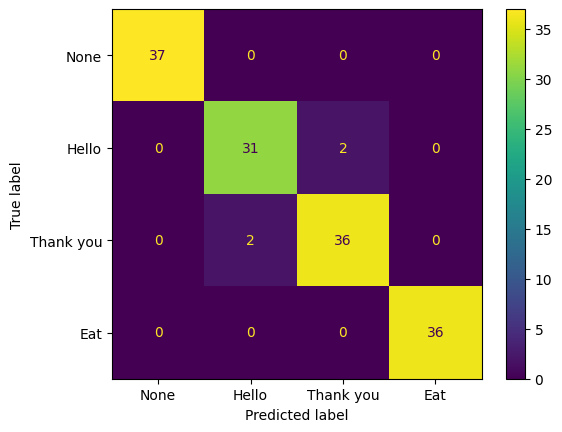

In [32]:
ConfusionMatrixDisplay.from_predictions(ytrue, ypred,display_labels=['None', 'Hello', 'Thank you', 'Eat'])

In [33]:
accuracy_score(ytrue, ypred)

0.9722222222222222

# Make Predictions

In [34]:
res = model.predict(X_test)

5/5 [==============================] - 0s 25ms/step


In [35]:
res

array([[1.59060379e-04, 4.21479344e-02, 1.38386866e-04, 9.57554579e-01],
       [9.99261677e-01, 1.64134144e-05, 9.28368271e-10, 7.21956138e-04],
       [7.63756907e-06, 8.66252184e-02, 9.13283944e-01, 8.31918514e-05],
       [6.33714197e-04, 1.87133372e-01, 1.93695026e-03, 8.10295999e-01],
       [9.86833358e-04, 1.32451952e-02, 9.38060766e-05, 9.85674083e-01],
       [2.73721753e-07, 9.82075930e-01, 1.60900988e-02, 1.83370442e-03],
       [1.64576370e-04, 1.46244084e-02, 6.13520751e-05, 9.85149622e-01],
       [9.99954462e-01, 3.20857623e-07, 5.40295135e-11, 4.52683817e-05],
       [6.42924860e-08, 2.59281188e-01, 7.40678191e-01, 4.05378050e-05],
       [2.34442457e-08, 1.82995833e-02, 9.81699646e-01, 7.34567152e-07],
       [9.99999642e-01, 1.63111675e-08, 3.00054984e-13, 2.88485552e-07],
       [2.00440860e-04, 2.94402614e-02, 1.35223017e-04, 9.70224082e-01],
       [1.79759923e-07, 5.13862148e-02, 9.48607802e-01, 5.75132799e-06],
       [3.78147602e-09, 5.85460057e-03, 9.94145155e

In [36]:
actions[np.argmax(res[4])]

'please'

In [37]:
actions[np.argmax(y_test[4])]

'please'

# Save Weights

In [39]:
model.save('action.h5')

In [43]:
test_DATA_PATH='MP_Data_Pl_HL_EM_GD'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 32ms/step


0.975

In [44]:
test_DATA_PATH='MP_Data_Pl_HL_EM_GD_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 27ms/step


0.975

In [45]:
test_DATA_PATH='MP_Data_Pl_HL_EM_UD'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 1s 122ms/step


0.975

In [46]:
test_DATA_PATH='MP_Data_Pl_HL_EM_UD_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 36ms/step


0.9666666666666667

In [84]:
test_DATA_PATH='MP_Data_Pl_HL_EM_KUN'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 2s 39ms/step


0.9583333333333334

In [85]:
test_DATA_PATH='MP_Data_Pl_HL_EM_KUN_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 1s 136ms/step


0.9833333333333333

# Test in Real Time

In [86]:
from scipy import stats

In [87]:
colors = [(255, 0, 0),(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [88]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Pose: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Face: [0. 0. 0. ... 0. 0. 0.]
Left Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Right Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pose: [ 5.25732458e-01  6.27054214e-01 -1.18244946e+00  9.99262393e-01
  5.58308780e-01  5.37247896e-01 -1.14095104e+00  9.98367965e-01
  5.81605673e-01

Pose: [ 5.28838873e-01  6.08983815e-01 -1.67524111e+00  9.99260664e-01
  5.66545725e-01  5.22219956e-01 -1.60856605e+00  9.98501420e-01
  5.88607669e-01  5.21559179e-01 -1.60898900e+00  9.98664141e-01
  6.10843897e-01  5.21423459e-01 -1.60920453e+00  9.98417616e-01
  4.93878990e-01  5.18752933e-01 -1.61774099e+00  9.98590469e-01
  4.68211591e-01  5.16804814e-01 -1.61760676e+00  9.98786986e-01
  4.47138160e-01  5.16205609e-01 -1.61837065e+00  9.98652518e-01
  6.42301977e-01  5.32354712e-01 -1.03100193e+00  9.98584986e-01
  4.17561144e-01  5.30937552e-01 -1.06342304e+00  9.99019146e-01
  5.64996600e-01  6.85098767e-01 -1.44185209e+00  9.99369860e-01
  4.85411227e-01  6.92007959e-01 -1.45223773e+00  9.99466777e-01
  8.02641869e-01  9.28262353e-01 -5.37193894e-01  9.94783938e-01
  2.61371970e-01  9.14609849e-01 -5.86039364e-01  9.97902870e-01
  8.92914295e-01  1.38346076e+00 -3.13120842e-01  1.43505365e-01
  1.46699309e-01  1.39825368e+00 -4.24361855e-01  2.03522161e-01
  8.65053058e-01  1

Pose: [ 5.40572286e-01  5.61995149e-01 -1.47123122e+00  9.99248683e-01
  5.77361703e-01  4.90063310e-01 -1.38195717e+00  9.98646796e-01
  5.99278271e-01  4.91260231e-01 -1.38258135e+00  9.98680294e-01
  6.20123386e-01  4.93612200e-01 -1.38269448e+00  9.98503149e-01
  5.13642550e-01  4.83612359e-01 -1.39047694e+00  9.98731196e-01
  4.90940958e-01  4.80287999e-01 -1.39016449e+00  9.98827577e-01
  4.72525597e-01  4.78011668e-01 -1.39083529e+00  9.98800457e-01
  6.50154889e-01  5.10611594e-01 -8.03723812e-01  9.98637080e-01
  4.42861617e-01  4.91570175e-01 -8.37170780e-01  9.99058485e-01
  5.71471095e-01  6.39678180e-01 -1.24619138e+00  9.99346077e-01
  4.99403298e-01  6.31194711e-01 -1.26126909e+00  9.99476254e-01
  8.00343633e-01  9.20394897e-01 -4.12294805e-01  9.90375757e-01
  2.90656000e-01  8.69629562e-01 -3.93511236e-01  9.94962156e-01
  8.69069278e-01  1.36490428e+00 -3.64652216e-01  1.41870931e-01
  1.79570705e-01  1.31978154e+00 -3.44568491e-01  2.03327253e-01
  8.46773744e-01  1

Pose: [ 5.43150783e-01  5.06703198e-01 -1.40153980e+00  9.99319732e-01
  5.76982915e-01  4.34682965e-01 -1.33003139e+00  9.98830378e-01
  5.96580267e-01  4.37201798e-01 -1.33047223e+00  9.98821080e-01
  6.16877019e-01  4.40117747e-01 -1.33062065e+00  9.98674333e-01
  5.15798151e-01  4.30565953e-01 -1.33180928e+00  9.98898625e-01
  4.94551003e-01  4.29983318e-01 -1.33137488e+00  9.98958528e-01
  4.76301134e-01  4.29173023e-01 -1.33207428e+00  9.98970151e-01
  6.47024512e-01  4.72357333e-01 -8.01212788e-01  9.98752594e-01
  4.51533735e-01  4.58005160e-01 -8.00358951e-01  9.99174595e-01
  5.75239539e-01  5.76424837e-01 -1.19867945e+00  9.99413490e-01
  5.03492355e-01  5.72631061e-01 -1.19822085e+00  9.99545217e-01
  8.08408380e-01  9.06612992e-01 -4.27235514e-01  9.90320385e-01
  3.00074488e-01  8.45640957e-01 -4.40264642e-01  9.94787514e-01
  8.64996135e-01  1.34470642e+00 -3.94172609e-01  1.36867449e-01
  1.72419786e-01  1.30895782e+00 -3.48836541e-01  2.29650393e-01
  8.49088013e-01  1

Pose: [ 5.88338673e-01  3.32676679e-01 -1.32123518e+00  9.99566019e-01
  6.25712395e-01  2.60621488e-01 -1.25526953e+00  9.99267459e-01
  6.47629201e-01  2.61198640e-01 -1.25567651e+00  9.99256909e-01
  6.69526517e-01  2.62176275e-01 -1.25586319e+00  9.99167264e-01
  5.58106720e-01  2.59412587e-01 -1.24956977e+00  9.99303579e-01
  5.34054279e-01  2.60006726e-01 -1.24902928e+00  9.99335051e-01
  5.11352897e-01  2.61252254e-01 -1.24935174e+00  9.99343812e-01
  6.97296321e-01  2.89365858e-01 -7.37975776e-01  9.99223530e-01
  4.86581802e-01  2.87546724e-01 -6.93632901e-01  9.99470949e-01
  6.18477762e-01  4.05712694e-01 -1.12307477e+00  9.99634504e-01
  5.43438733e-01  4.08404768e-01 -1.11548793e+00  9.99711812e-01
  8.39854240e-01  7.16358960e-01 -4.43251282e-01  9.93511319e-01
  3.38589966e-01  6.89691246e-01 -3.55818242e-01  9.95492578e-01
  9.45057690e-01  1.06102490e+00 -5.26323378e-01  1.86507806e-01
  2.22819135e-01  1.04250741e+00 -6.76105678e-01  2.36609608e-01
  9.87272561e-01  1

Pose: [ 5.80666125e-01  4.28222626e-01 -1.24206936e+00  9.99654531e-01
  6.18985355e-01  3.54917973e-01 -1.17657793e+00  9.99404907e-01
  6.34417892e-01  3.56210262e-01 -1.17693210e+00  9.99398410e-01
  6.50974870e-01  3.56691241e-01 -1.17713833e+00  9.99307156e-01
  5.52921176e-01  3.50955337e-01 -1.16430640e+00  9.99438345e-01
  5.29723704e-01  3.50125492e-01 -1.16389489e+00  9.99473155e-01
  5.07151008e-01  3.48417729e-01 -1.16434848e+00  9.99475658e-01
  6.72640085e-01  3.76801640e-01 -6.96547151e-01  9.99341190e-01
  4.82782751e-01  3.68818939e-01 -7.35001981e-01  9.99584794e-01
  6.10964656e-01  5.03461301e-01 -1.05880010e+00  9.99704003e-01
  5.37674963e-01  5.09118140e-01 -1.03863406e+00  9.99773860e-01
  8.25725436e-01  7.88834691e-01 -3.91620576e-01  9.94608998e-01
  3.18741262e-01  7.54046559e-01 -4.90945637e-01  9.96322095e-01
  8.98949146e-01  1.24194121e+00 -3.70414197e-01  1.67027310e-01
  1.86627015e-01  1.22862983e+00 -4.02953148e-01  2.63259560e-01
  8.76878858e-01  1

Pose: [ 5.78376234e-01  4.44418788e-01 -1.26164031e+00  9.99727607e-01
  6.14618599e-01  3.71871918e-01 -1.18111587e+00  9.99532461e-01
  6.31288886e-01  3.72146100e-01 -1.18147910e+00  9.99529481e-01
  6.49052501e-01  3.72750342e-01 -1.18171811e+00  9.99448419e-01
  5.49300790e-01  3.69007379e-01 -1.18357635e+00  9.99552667e-01
  5.26654422e-01  3.67641896e-01 -1.18289816e+00  9.99585748e-01
  5.06400526e-01  3.66403967e-01 -1.18322253e+00  9.99580204e-01
  6.72409356e-01  3.96202892e-01 -6.63070679e-01  9.99456286e-01
  4.80894148e-01  3.91811967e-01 -6.94853008e-01  9.99671340e-01
  6.10553503e-01  5.18150389e-01 -1.06983340e+00  9.99767363e-01
  5.38479447e-01  5.20420551e-01 -1.06845236e+00  9.99820113e-01
  8.26076210e-01  8.02743316e-01 -3.43680888e-01  9.95586812e-01
  3.19879770e-01  7.98914611e-01 -4.64147478e-01  9.96751249e-01
  8.68140340e-01  1.26529145e+00 -3.35680813e-01  1.53699204e-01
  2.18120292e-01  1.29720759e+00 -4.96406734e-01  2.81817585e-01
  8.68872821e-01  1

1/1 [==============================] - 0s 492ms/step

Pose: [ 4.82628733e-01  4.59376991e-01 -1.36175418e+00  9.99715328e-01
  5.16680300e-01  3.89007539e-01 -1.26485693e+00  9.99517202e-01
  5.37891090e-01  3.90780926e-01 -1.26529825e+00  9.99504209e-01
  5.57027042e-01  3.92701983e-01 -1.26547801e+00  9.99422729e-01
  4.58935261e-01  3.84544700e-01 -1.28854859e+00  9.99553084e-01
  4.38968599e-01  3.83874357e-01 -1.28810084e+00  9.99589145e-01
  4.21489060e-01  3.84153426e-01 -1.28874767e+00  9.99599218e-01
  5.73835790e-01  4.12970573e-01 -6.90443397e-01  9.99365091e-01
  3.94374311e-01  4.07302886e-01 -7.81765878e-01  9.99695480e-01
  5.11040211e-01  5.31937420e-01 -1.13968635e+00  9.99757051e-01
  4.45369899e-01  5.34439743e-01 -1.17062926e+00  9.99832451e-01
  6.84029877e-01  8.05978358e-01 -2.87193120e-01  9.95439172e-01
  2.19170421e-01  7.79920816e-01 -4.45341110e-01  9.97075319e-01
  7.56016374e-01  1.26012170e+00 -2.30422944e-01  1.52773619e-01
  5.12693711e-02  1.21939921e+

1/1 [==============================] - 0s 37ms/step

Pose: [ 5.11536896e-01  4.78085905e-01 -1.18932080e+00  9.99750733e-01
  5.44048786e-01  4.04717147e-01 -1.10159564e+00  9.99579608e-01
  5.65050960e-01  4.05301481e-01 -1.10233378e+00  9.99567926e-01
  5.82322001e-01  4.05869305e-01 -1.10277641e+00  9.99497175e-01
  4.78612274e-01  3.99507821e-01 -1.12846684e+00  9.99616325e-01
  4.53764617e-01  3.96805733e-01 -1.12801600e+00  9.99648333e-01
  4.37608540e-01  3.95201236e-01 -1.12864590e+00  9.99656439e-01
  6.02306485e-01  4.21029389e-01 -6.27894163e-01  9.99447465e-01
  4.09581333e-01  4.09748167e-01 -6.64126813e-01  9.99742806e-01
  5.40160418e-01  5.49001634e-01 -9.90919471e-01  9.99786198e-01
  4.70293462e-01  5.48672855e-01 -1.01171565e+00  9.99854386e-01
  7.15834975e-01  8.12023401e-01 -3.43375862e-01  9.96256649e-01
  2.27339074e-01  7.72822738e-01 -3.93080294e-01  9.97469902e-01
  7.57317841e-01  1.07855451e+00 -3.55742097e-01  1.32426530e-01
  1.47023052e-01  1.28798699e+0

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.60087979e-01  4.84625965e-01 -1.46431613e+00  9.99802232e-01
  5.95511198e-01  4.10825700e-01 -1.39936602e+00  9.99652684e-01
  6.17882311e-01  4.12111014e-01 -1.39946604e+00  9.99643683e-01
  6.37681842e-01  4.13340360e-01 -1.39963377e+00  9.99584019e-01
  5.26922941e-01  4.02282208e-01 -1.42900431e+00  9.99691963e-01
  5.00236630e-01  3.98970783e-01 -1.42812431e+00  9.99718130e-01
  4.72731590e-01  3.96059304e-01 -1.42832577e+00  9.99720693e-01
  6.53952122e-01  4.26525772e-01 -8.83367181e-01  9.99532104e-01
  4.26247925e-01  4.09417301e-01 -9.99074161e-01  9.99797940e-01
  5.84350705e-01  5.59136152e-01 -1.25881732e+00  9.99825537e-01
  5.14408469e-01  5.54390490e-01 -1.29284406e+00  9.99884963e-01
  7.67705262e-01  8.04569423e-01 -5.21174073e-01  9.97196257e-01
  2.32225105e-01  7.89627254e-01 -6.73118412e-01  9.98086333e-01
  8.24956894e-01  1.08989334e+00 -3.62398446e-01  1.35479242e-01
  1.05074450e-01  1.28075194e+0

1/1 [==============================] - 0s 45ms/step

Pose: [ 5.77847958e-01  4.95646894e-01 -1.91359079e+00  9.99828696e-01
  6.10510468e-01  4.15009856e-01 -1.87670112e+00  9.99671161e-01
  6.34691119e-01  4.12890255e-01 -1.87678683e+00  9.99672353e-01
  6.57533586e-01  4.10789222e-01 -1.87699103e+00  9.99597371e-01
  5.37921131e-01  4.11613494e-01 -1.87919712e+00  9.99714077e-01
  5.08620381e-01  4.08075780e-01 -1.87853551e+00  9.99743044e-01
  4.83493388e-01  4.06567484e-01 -1.87879527e+00  9.99736309e-01
  6.75286055e-01  4.15156543e-01 -1.37574470e+00  9.99577403e-01
  4.39026356e-01  4.14646506e-01 -1.35492063e+00  9.99830365e-01
  6.09880328e-01  5.71368039e-01 -1.70098948e+00  9.99846101e-01
  5.34185529e-01  5.71929872e-01 -1.69577408e+00  9.99903262e-01
  8.34016979e-01  7.73331225e-01 -9.23188508e-01  9.97748137e-01
  2.54282504e-01  8.01654458e-01 -9.10161972e-01  9.98387277e-01
  9.42330539e-01  1.26070952e+00 -7.93556809e-01  1.39490172e-01
  1.04059473e-01  1.33552992e+0

1/1 [==============================] - 0s 21ms/step

Pose: [ 5.03669918e-01  4.44271505e-01 -1.18642497e+00  9.99739170e-01
  5.34453630e-01  3.80499542e-01 -1.11962390e+00  9.99536157e-01
  5.55712521e-01  3.80598992e-01 -1.12015831e+00  9.99526620e-01
  5.70831656e-01  3.81566882e-01 -1.12051105e+00  9.99467373e-01
  4.73162800e-01  3.81227016e-01 -1.13162649e+00  9.99577940e-01
  4.53537464e-01  3.81673992e-01 -1.13140106e+00  9.99597490e-01
  4.35941070e-01  3.82349402e-01 -1.13182783e+00  9.99601126e-01
  5.88260889e-01  4.00565267e-01 -6.34657502e-01  9.99482334e-01
  4.16368395e-01  4.03259695e-01 -6.77750587e-01  9.99714255e-01
  5.43632448e-01  5.06875634e-01 -1.00000548e+00  9.99794304e-01
  4.64043140e-01  5.22094011e-01 -1.01213634e+00  9.99837220e-01
  7.02730954e-01  7.20042765e-01 -2.81771719e-01  9.97854352e-01
  3.02064061e-01  7.64288902e-01 -3.45485151e-01  9.98123944e-01
  7.85900712e-01  9.87846017e-01 -2.09445313e-01  1.99515209e-01
  1.98287815e-01  1.06727111e+0

1/1 [==============================] - 0s 30ms/step

Pose: [ 5.00426710e-01  4.61629599e-01 -1.23456597e+00  9.99724030e-01
  5.29633641e-01  4.06115443e-01 -1.17080736e+00  9.99543130e-01
  5.47991037e-01  4.05470341e-01 -1.17123938e+00  9.99532580e-01
  5.60757101e-01  4.04560298e-01 -1.17148125e+00  9.99494076e-01
  4.73518908e-01  4.06708926e-01 -1.18394113e+00  9.99566317e-01
  4.56635058e-01  4.07107532e-01 -1.18374705e+00  9.99573648e-01
  4.39832360e-01  4.07392085e-01 -1.18416643e+00  9.99579489e-01
  5.79951048e-01  4.19239163e-01 -7.09584594e-01  9.99523461e-01
  4.17967141e-01  4.23016846e-01 -7.59055793e-01  9.99683738e-01
  5.34766316e-01  5.12648404e-01 -1.05832362e+00  9.99800563e-01
  4.69410270e-01  5.27443707e-01 -1.07194579e+00  9.99825180e-01
  7.03693569e-01  7.31494606e-01 -3.73267472e-01  9.98108029e-01
  3.03133428e-01  7.75949538e-01 -4.36279774e-01  9.97947216e-01
  7.74293065e-01  1.02246201e+00 -2.70669013e-01  2.96787202e-01
  2.02221826e-01  1.09216368e+0

1/1 [==============================] - 0s 31ms/step

Pose: [ 5.04104018e-01  4.65585500e-01 -1.23907971e+00  9.99743342e-01
  5.32219768e-01  4.06690806e-01 -1.16868162e+00  9.99590099e-01
  5.49624562e-01  4.06369716e-01 -1.16915381e+00  9.99577045e-01
  5.62490046e-01  4.06277567e-01 -1.16937304e+00  9.99552548e-01
  4.77199316e-01  4.06702369e-01 -1.18897510e+00  9.99610960e-01
  4.58933741e-01  4.07317251e-01 -1.18891716e+00  9.99612570e-01
  4.42982346e-01  4.08192784e-01 -1.18937707e+00  9.99622047e-01
  5.82407653e-01  4.21259075e-01 -6.89582467e-01  9.99576628e-01
  4.18973207e-01  4.24362391e-01 -7.71990836e-01  9.99707997e-01
  5.36038280e-01  5.16915977e-01 -1.05646074e+00  9.99816060e-01
  4.70935643e-01  5.29406607e-01 -1.08056855e+00  9.99838531e-01
  7.05154538e-01  7.41319001e-01 -3.61939251e-01  9.98165667e-01
  3.01625043e-01  7.81274021e-01 -4.52367306e-01  9.97802734e-01
  7.73301482e-01  1.01669967e+00 -2.80727565e-01  3.50155205e-01
  1.91420346e-01  1.08904147e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.12341857e-01  4.62267756e-01 -9.77209389e-01  9.99758482e-01
  5.38731873e-01  4.05474067e-01 -9.03829873e-01  9.99629021e-01
  5.53200841e-01  4.05951023e-01 -9.04268563e-01  9.99612093e-01
  5.67804813e-01  4.06472296e-01 -9.04117405e-01  9.99595821e-01
  4.88111317e-01  4.02745426e-01 -9.14573848e-01  9.99648690e-01
  4.69107926e-01  4.02623683e-01 -9.14642155e-01  9.99647260e-01
  4.53603506e-01  4.02683556e-01 -9.15140271e-01  9.99661386e-01
  5.88093817e-01  4.21866983e-01 -4.12455708e-01  9.99611616e-01
  4.29642200e-01  4.19734180e-01 -4.61854637e-01  9.99732554e-01
  5.39310753e-01  5.19384325e-01 -7.92240500e-01  9.99826849e-01
  4.78870779e-01  5.22966087e-01 -8.08134258e-01  9.99850810e-01
  7.04600334e-01  7.37660050e-01 -1.44549385e-01  9.98297691e-01
  3.07794780e-01  7.46262729e-01 -1.92036241e-01  9.97833729e-01
  7.74645925e-01  1.01896930e+00 -6.79892123e-01  4.70007479e-01
  1.74232930e-01  1.03497028e+0

1/1 [==============================] - 0s 136ms/step
help
Pose: [ 5.22488475e-01  4.65766996e-01 -1.15278029e+00  9.99695599e-01
  5.46483397e-01  4.08978194e-01 -1.08414090e+00  9.99532461e-01
  5.61090827e-01  4.09600168e-01 -1.08465672e+00  9.99501646e-01
  5.76759398e-01  4.10422921e-01 -1.08486974e+00  9.99484420e-01
  4.95836347e-01  4.04896528e-01 -1.10830283e+00  9.99573469e-01
  4.75665629e-01  4.04267609e-01 -1.10829282e+00  9.99573231e-01
  4.59478706e-01  4.04242396e-01 -1.10886645e+00  9.99598861e-01
  5.91064811e-01  4.24618423e-01 -6.28342867e-01  9.99489248e-01
  4.34259504e-01  4.21426892e-01 -7.23033190e-01  9.99679267e-01
  5.45351088e-01  5.23957789e-01 -9.79080558e-01  9.99772191e-01
  4.86151844e-01  5.25772035e-01 -1.00711298e+00  9.99817312e-01
  7.04593301e-01  7.47031748e-01 -3.01653415e-01  9.97845769e-01
  3.07121158e-01  7.71258414e-01 -4.22583759e-01  9.97414947e-01
  7.74289966e-01  1.00098658e+00 -2.36177057e-01  4.37822998e-01
  2.01016754e-01  1.050332

1/1 [==============================] - 0s 21ms/step
help
Pose: [ 5.25068581e-01  4.68655139e-01 -1.17524076e+00  9.99617994e-01
  5.49563408e-01  4.10273135e-01 -1.10109735e+00  9.99413431e-01
  5.64882219e-01  4.11034703e-01 -1.10165453e+00  9.99364138e-01
  5.80782056e-01  4.12191689e-01 -1.10184050e+00  9.99348164e-01
  4.99584913e-01  4.05745685e-01 -1.12478662e+00  9.99474764e-01
  4.79528248e-01  4.05028313e-01 -1.12467074e+00  9.99479532e-01
  4.62762505e-01  4.04885769e-01 -1.12526095e+00  9.99525428e-01
  5.94601512e-01  4.26486194e-01 -6.20719314e-01  9.99302626e-01
  4.35914934e-01  4.22106713e-01 -7.19573617e-01  9.99607086e-01
  5.46803653e-01  5.28624892e-01 -9.93216634e-01  9.99710679e-01
  4.87569332e-01  5.27685821e-01 -1.02096796e+00  9.99783039e-01
  7.07817912e-01  7.56497264e-01 -3.04665148e-01  9.97156680e-01
  3.05808604e-01  7.74103403e-01 -4.21495587e-01  9.96988356e-01
  7.73271859e-01  1.00296760e+00 -2.39028856e-01  3.88836592e-01
  2.00121596e-01  1.0670315

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.29650807e-01  4.69760388e-01 -1.19626164e+00  9.99478042e-01
  5.52273512e-01  4.10780698e-01 -1.12323737e+00  9.99214828e-01
  5.68350255e-01  4.11482960e-01 -1.12377739e+00  9.99132037e-01
  5.83493054e-01  4.12728518e-01 -1.12391913e+00  9.99099374e-01
  5.04051268e-01  4.06346440e-01 -1.14235401e+00  9.99313354e-01
  4.84109551e-01  4.05407816e-01 -1.14225209e+00  9.99326706e-01
  4.66849178e-01  4.05056417e-01 -1.14286327e+00  9.99408603e-01
  5.96175671e-01  4.27093029e-01 -6.45128012e-01  9.98988748e-01
  4.37770277e-01  4.21815515e-01 -7.24995315e-01  9.99518514e-01
  5.49553990e-01  5.29756248e-01 -1.01426089e+00  9.99613345e-01
  4.92325246e-01  5.28165340e-01 -1.03626180e+00  9.99740064e-01
  7.10851252e-01  7.60051310e-01 -3.31125975e-01  9.95980442e-01
  3.05681169e-01  7.73816466e-01 -4.13427681e-01  9.96260762e-01
  7.68966615e-01  1.02396131e+00 -3.13064307e-01  3.43940288e-01
  1.92912772e-01  1.1628971

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.28646767e-01  4.71425682e-01 -1.23226345e+00  9.99370456e-01
  5.51968813e-01  4.12401587e-01 -1.16070664e+00  9.99052942e-01
  5.67887187e-01  4.13021922e-01 -1.16120601e+00  9.98934269e-01
  5.83294928e-01  4.14310127e-01 -1.16135001e+00  9.98904049e-01
  5.03986955e-01  4.07930732e-01 -1.17862499e+00  9.99188185e-01
  4.84495252e-01  4.06584650e-01 -1.17859185e+00  9.99202192e-01
  4.67530072e-01  4.05913144e-01 -1.17923939e+00  9.99319971e-01
  5.96279383e-01  4.28413570e-01 -6.87845469e-01  9.98715878e-01
  4.39411730e-01  4.21609193e-01 -7.62319207e-01  9.99445260e-01
  5.49373806e-01  5.31361699e-01 -1.05233169e+00  9.99534070e-01
  4.92409527e-01  5.28722227e-01 -1.07371020e+00  9.99707758e-01
  7.11710989e-01  7.62692809e-01 -3.64942133e-01  9.95083034e-01
  3.03742111e-01  7.74303019e-01 -4.45902020e-01  9.95851696e-01
  7.69092381e-01  1.02408326e+00 -3.23662370e-01  3.16884786e-01
  1.74671158e-01  1.15252542e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.26786804e-01  4.72470850e-01 -1.22426784e+00  9.99340951e-01
  5.50771236e-01  4.13273513e-01 -1.15427327e+00  9.99010623e-01
  5.66351712e-01  4.13770527e-01 -1.15475380e+00  9.98871863e-01
  5.82117200e-01  4.14970219e-01 -1.15487361e+00  9.98847783e-01
  5.02488017e-01  4.09055173e-01 -1.16958451e+00  9.99152422e-01
  4.83711541e-01  4.07451510e-01 -1.16956198e+00  9.99158204e-01
  4.67348903e-01  4.06610996e-01 -1.17019796e+00  9.99293983e-01
  5.96364617e-01  4.28951174e-01 -6.86415613e-01  9.98617470e-01
  4.39719826e-01  4.21994388e-01 -7.57192850e-01  9.99409497e-01
  5.48699796e-01  5.32194912e-01 -1.04552388e+00  9.99499500e-01
  4.91560638e-01  5.29085934e-01 -1.06384993e+00  9.99689877e-01
  7.15271831e-01  7.66887069e-01 -3.70466769e-01  9.94050205e-01
  3.06780517e-01  7.75327623e-01 -4.41757262e-01  9.95291293e-01
  7.67731071e-01  1.02635705e+00 -3.38487446e-01  2.91300148e-01
  1.81119591e-01  1.05345130e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.27434230e-01  4.59712625e-01 -1.01769054e+00  9.99518216e-01
  5.50588429e-01  4.02533501e-01 -9.45136070e-01  9.99294996e-01
  5.65769315e-01  4.02931273e-01 -9.45526600e-01  9.99199331e-01
  5.81244111e-01  4.03620124e-01 -9.45296288e-01  9.99170303e-01
  5.02264380e-01  3.99965286e-01 -9.61258054e-01  9.99397993e-01
  4.83612239e-01  3.99403900e-01 -9.61318612e-01  9.99406755e-01
  4.67358828e-01  3.99485260e-01 -9.61823165e-01  9.99500990e-01
  5.95092595e-01  4.21683669e-01 -4.50427920e-01  9.99024034e-01
  4.37902361e-01  4.19407010e-01 -5.22344172e-01  9.99586999e-01
  5.50150394e-01  5.15249729e-01 -8.28795910e-01  9.99637902e-01
  4.93290186e-01  5.13889492e-01 -8.51021767e-01  9.99777317e-01
  7.13406682e-01  7.26769507e-01 -1.16926983e-01  9.95518625e-01
  3.10752392e-01  7.28021204e-01 -2.28465408e-01  9.96552765e-01
  7.76366651e-01  1.04405463e+00 -5.93210757e-01  4.71847475e-01
  1.55021340e-01  1.05379701e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.26979148e-01  4.57876503e-01 -7.45084882e-01  9.99601007e-01
  5.50121367e-01  4.01239038e-01 -6.69203401e-01  9.99419868e-01
  5.64977646e-01  4.01746243e-01 -6.69581473e-01  9.99342144e-01
  5.80300391e-01  4.02466446e-01 -6.69398069e-01  9.99317348e-01
  5.01670003e-01  3.97619069e-01 -6.90836787e-01  9.99503076e-01
  4.83336210e-01  3.96217674e-01 -6.90809548e-01  9.99510705e-01
  4.67119128e-01  3.95666331e-01 -6.91259444e-01  9.99586999e-01
  5.94247878e-01  4.19671804e-01 -1.92466408e-01  9.99199212e-01
  4.37476099e-01  4.15336013e-01 -2.91172206e-01  9.99660075e-01
  5.49747527e-01  5.13825774e-01 -5.63484907e-01  9.99700606e-01
  4.92853492e-01  5.11646271e-01 -5.93369603e-01  9.99814749e-01
  7.07850575e-01  7.20399320e-01  6.49918765e-02  9.96246815e-01
  3.07629973e-01  7.21984267e-01 -1.26734585e-01  9.97025907e-01
  7.73650289e-01  1.03028166e+00 -5.32245994e-01  5.53231776e-01
  1.50260597e-01  9.78586018e-0

1/1 [==============================] - 0s 57ms/step
help
Pose: [ 5.25826991e-01  4.58057404e-01 -1.19363856e+00  9.99672413e-01
  5.49859762e-01  4.01374131e-01 -1.10989738e+00  9.99526262e-01
  5.64640999e-01  4.01878715e-01 -1.11018181e+00  9.99463022e-01
  5.80126584e-01  4.02591199e-01 -1.11001182e+00  9.99442637e-01
  5.01278102e-01  3.97700042e-01 -1.13367903e+00  9.99592900e-01
  4.82931763e-01  3.96261275e-01 -1.13380361e+00  9.99598742e-01
  4.66804892e-01  3.95687550e-01 -1.13416064e+00  9.99660492e-01
  5.94240010e-01  4.19367880e-01 -5.72530389e-01  9.99347508e-01
  4.36844051e-01  4.13360894e-01 -6.80547833e-01  9.99720871e-01
  5.48671842e-01  5.14176905e-01 -9.88923728e-01  9.99754667e-01
  4.91780430e-01  5.11859298e-01 -1.02099490e+00  9.99847054e-01
  7.07341552e-01  7.22977459e-01 -1.96213782e-01  9.96879995e-01
  3.00484538e-01  7.32681990e-01 -3.50878656e-01  9.97384429e-01
  8.10739160e-01  1.17261147e+00 -7.35481739e-01  6.24493420e-01
  1.54502839e-01  1.0760501

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.25514841e-01  4.59427029e-01 -1.23657346e+00  9.99695003e-01
  5.49388289e-01  4.01880950e-01 -1.16509318e+00  9.99552906e-01
  5.64248085e-01  4.02424783e-01 -1.16556239e+00  9.99493659e-01
  5.79780817e-01  4.03369367e-01 -1.16569734e+00  9.99470234e-01
  4.99611318e-01  3.97963315e-01 -1.18263149e+00  9.99615252e-01
  4.81445968e-01  3.96440178e-01 -1.18253064e+00  9.99623060e-01
  4.65176761e-01  3.95847648e-01 -1.18310356e+00  9.99678671e-01
  5.94218612e-01  4.20225710e-01 -6.88301802e-01  9.99375999e-01
  4.35601324e-01  4.13698465e-01 -7.59087682e-01  9.99744415e-01
  5.48371315e-01  5.17255485e-01 -1.05549943e+00  9.99771833e-01
  4.89905655e-01  5.16541660e-01 -1.07549787e+00  9.99857843e-01
  7.10994005e-01  7.40171850e-01 -3.55118573e-01  9.96749341e-01
  3.00095022e-01  7.63870478e-01 -4.70067203e-01  9.97241497e-01
  7.89383650e-01  1.04847944e+00 -3.07088882e-01  5.65523565e-01
  1.76747784e-01  1.08

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.23565531e-01  4.59516555e-01 -1.19351161e+00  9.99693274e-01
  5.48105180e-01  4.02673155e-01 -1.12058353e+00  9.99548435e-01
  5.62879205e-01  4.03504401e-01 -1.12103534e+00  9.99482214e-01
  5.78632772e-01  4.04761374e-01 -1.12109637e+00  9.99465644e-01
  4.97017860e-01  3.96901637e-01 -1.14011109e+00  9.99609947e-01
  4.79814827e-01  3.94843757e-01 -1.14010215e+00  9.99612510e-01
  4.63355303e-01  3.93322945e-01 -1.14069259e+00  9.99672592e-01
  5.94012320e-01  4.22439367e-01 -6.49844587e-01  9.99363899e-01
  4.34463739e-01  4.13921684e-01 -7.36219287e-01  9.99736369e-01
  5.46922803e-01  5.18146574e-01 -1.01540530e+00  9.99768496e-01
  4.87472534e-01  5.15763879e-01 -1.03964889e+00  9.99853492e-01
  7.11323857e-01  7.59417415e-01 -3.37929070e-01  9.96166408e-01
  2.98502266e-01  7.69281626e-01 -4.56241786e-01  9.96792853e-01
  7.80547500e-01  1.02564502e+00 -2.94945180e-01  4.62314367e-01
  1.81511059e-01  1.07

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.21205008e-01  4.55997407e-01 -1.21548307e+00  9.99714792e-01
  5.45755744e-01  3.96954417e-01 -1.14266813e+00  9.99583900e-01
  5.60113609e-01  3.99839550e-01 -1.14316666e+00  9.99513030e-01
  5.75907409e-01  4.02505845e-01 -1.14325094e+00  9.99504387e-01
  4.94083017e-01  3.89437497e-01 -1.15998447e+00  9.99644101e-01
  4.76912439e-01  3.87409359e-01 -1.15986693e+00  9.99640942e-01
  4.60388243e-01  3.85984868e-01 -1.16040862e+00  9.99700546e-01
  5.91997445e-01  4.22887921e-01 -6.72663093e-01  9.99406517e-01
  4.31091070e-01  4.10318255e-01 -7.44310319e-01  9.99759078e-01
  5.45022368e-01  5.16169667e-01 -1.03900874e+00  9.99787986e-01
  4.83669221e-01  5.09929717e-01 -1.05905151e+00  9.99867737e-01
  7.06004679e-01  7.56497741e-01 -3.63146096e-01  9.96051192e-01
  2.95219183e-01  7.70868480e-01 -4.47807699e-01  9.96507287e-01
  7.85467982e-01  1.01451600e+00 -3.11586797e-01  4.02218521e-01
  1.81165248e-01  1.07

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.19859552e-01  4.56292063e-01 -1.17294633e+00  9.99703169e-01
  5.44239283e-01  3.97123307e-01 -1.10394728e+00  9.99573112e-01
  5.58382332e-01  4.00160640e-01 -1.10440040e+00  9.99488771e-01
  5.73634267e-01  4.02945727e-01 -1.10458815e+00  9.99488413e-01
  4.92599785e-01  3.89546216e-01 -1.12335467e+00  9.99635696e-01
  4.75477606e-01  3.87546390e-01 -1.12312913e+00  9.99624491e-01
  4.59077448e-01  3.86190087e-01 -1.12358713e+00  9.99691725e-01
  5.89725614e-01  4.24456477e-01 -6.32275999e-01  9.99397933e-01
  4.30040121e-01  4.10328597e-01 -7.11806893e-01  9.99756217e-01
  5.43523192e-01  5.16162872e-01 -9.93246853e-01  9.99788463e-01
  4.82659966e-01  5.09953797e-01 -1.01517165e+00  9.99867618e-01
  7.00563967e-01  7.48156726e-01 -2.99711049e-01  9.96251762e-01
  2.95072228e-01  7.63963819e-01 -4.07161295e-01  9.96374428e-01
  7.93353498e-01  1.00129199e+00 -3.20464224e-01  3.89762461e-01
  1.80813879e-01  1.05

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.18383622e-01  4.54827517e-01 -1.26167560e+00  9.99725044e-01
  5.42933345e-01  3.95566016e-01 -1.19123149e+00  9.99600887e-01
  5.57166338e-01  3.98493469e-01 -1.19166064e+00  9.99520123e-01
  5.72739959e-01  4.01342005e-01 -1.19173169e+00  9.99523640e-01
  4.90921199e-01  3.89121890e-01 -1.20740390e+00  9.99658525e-01
  4.74053442e-01  3.87297660e-01 -1.20740104e+00  9.99644876e-01
  4.57945824e-01  3.86316359e-01 -1.20796835e+00  9.99710381e-01
  5.89950681e-01  4.24451500e-01 -7.20512748e-01  9.99437213e-01
  4.29783434e-01  4.11400616e-01 -7.86802530e-01  9.99765575e-01
  5.42655885e-01  5.14879704e-01 -1.08257699e+00  9.99799609e-01
  4.81525511e-01  5.09103775e-01 -1.10163736e+00  9.99873400e-01
  7.05699265e-01  7.56988585e-01 -4.03388739e-01  9.95821774e-01
  2.96488851e-01  7.64425159e-01 -4.87047106e-01  9.96217966e-01
  7.81858385e-01  1.03357017e+00 -3.83218825e-01  3.49992692e-01
  1.81719527e-01  1.0554739

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.18992066e-01  4.53914315e-01 -1.26453233e+00  9.99743164e-01
  5.42933643e-01  3.94740880e-01 -1.19521034e+00  9.99626577e-01
  5.57144940e-01  3.97232503e-01 -1.19567990e+00  9.99552667e-01
  5.72839379e-01  3.99680793e-01 -1.19570768e+00  9.99555707e-01
  4.91268098e-01  3.88931155e-01 -1.20862412e+00  9.99679446e-01
  4.74172920e-01  3.87241662e-01 -1.20868802e+00  9.99666572e-01
  4.58308756e-01  3.86236012e-01 -1.20926142e+00  9.99727428e-01
  5.89928925e-01  4.24056679e-01 -7.24979222e-01  9.99480426e-01
  4.29936409e-01  4.11901116e-01 -7.78771400e-01  9.99778807e-01
  5.43021262e-01  5.13787687e-01 -1.08589315e+00  9.99813735e-01
  4.81801838e-01  5.08465886e-01 -1.10131419e+00  9.99880791e-01
  7.08301723e-01  7.57763684e-01 -4.03618634e-01  9.95860755e-01
  3.00027162e-01  7.62670398e-01 -4.69146907e-01  9.96384203e-01
  7.80317664e-01  1.04095972e+00 -3.91864330e-01  3.36172253e-01
  1.97731763e-01  1.05841947e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.20015180e-01  4.53615367e-01 -1.28546894e+00  9.99749124e-01
  5.43135107e-01  3.94702584e-01 -1.21728611e+00  9.99632299e-01
  5.57296216e-01  3.97042364e-01 -1.21773505e+00  9.99558032e-01
  5.73123574e-01  3.99404585e-01 -1.21779263e+00  9.99561250e-01
  4.92283285e-01  3.89101148e-01 -1.23054564e+00  9.99686420e-01
  4.74824429e-01  3.87552142e-01 -1.23061585e+00  9.99673843e-01
  4.59307283e-01  3.86452764e-01 -1.23119783e+00  9.99736249e-01
  5.89939237e-01  4.24159378e-01 -7.45886445e-01  9.99481618e-01
  4.30388868e-01  4.12146240e-01 -8.01373839e-01  9.99784231e-01
  5.43468833e-01  5.13413548e-01 -1.10634124e+00  9.99817014e-01
  4.82477129e-01  5.08268714e-01 -1.12162375e+00  9.99883652e-01
  7.10025549e-01  7.58408844e-01 -4.26964104e-01  9.95680571e-01
  3.00529301e-01  7.61346459e-01 -4.86326307e-01  9.96578574e-01
  7.78734505e-01  1.04242396e+00 -4.09627587e-01  3.24680895e-01
  1.93364501e-01  1.06275797e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.19942641e-01  4.53381479e-01 -1.28553057e+00  9.99752522e-01
  5.42952180e-01  3.94385010e-01 -1.21867394e+00  9.99632835e-01
  5.57078242e-01  3.96664619e-01 -1.21909273e+00  9.99557853e-01
  5.72969615e-01  3.98994148e-01 -1.21918702e+00  9.99562085e-01
  4.91868794e-01  3.89097124e-01 -1.23217094e+00  9.99686420e-01
  4.74470675e-01  3.87575179e-01 -1.23216701e+00  9.99671936e-01
  4.58978593e-01  3.86586279e-01 -1.23270869e+00  9.99735236e-01
  5.89939892e-01  4.23988432e-01 -7.47414410e-01  9.99481142e-01
  4.30038989e-01  4.12158042e-01 -8.01853836e-01  9.99781370e-01
  5.43408692e-01  5.12955785e-01 -1.10522068e+00  9.99818087e-01
  4.82317269e-01  5.08181155e-01 -1.12064910e+00  9.99884069e-01
  7.10426450e-01  7.57926643e-01 -4.25122082e-01  9.95700657e-01
  2.99706966e-01  7.61826515e-01 -4.83547360e-01  9.96560752e-01
  7.80030131e-01  1.03993165e+00 -4.02596295e-01  3.21623445e-01
  1.83537781e-01  1.06037259e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.20350814e-01  4.53360111e-01 -1.15273976e+00  9.99761939e-01
  5.43557286e-01  3.93828064e-01 -1.08143079e+00  9.99647021e-01
  5.58011413e-01  3.95641893e-01 -1.08172679e+00  9.99580801e-01
  5.73929429e-01  3.97553802e-01 -1.08161521e+00  9.99560118e-01
  4.93939161e-01  3.89238149e-01 -1.08886981e+00  9.99703169e-01
  4.76295531e-01  3.87845784e-01 -1.08876407e+00  9.99699771e-01
  4.60910559e-01  3.86554658e-01 -1.08924651e+00  9.99752760e-01
  5.92359126e-01  4.22204345e-01 -5.92321515e-01  9.99503553e-01
  4.32645231e-01  4.11296904e-01 -6.20806217e-01  9.99798298e-01
  5.43859959e-01  5.12547135e-01 -9.71051872e-01  9.99826491e-01
  4.85128015e-01  5.07284582e-01 -9.79567826e-01  9.99890566e-01
  7.09462464e-01  7.56539524e-01 -2.32887000e-01  9.95580435e-01
  3.09880167e-01  7.32260346e-01 -3.91357154e-01  9.96787250e-01
  7.82685459e-01  1.04809630e+00 -1.96048468e-01  3.29463124e-01
  1.66956350e-01  1.04242814e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.24573207e-01  4.55092072e-01 -1.05940664e+00  9.99787986e-01
  5.46866059e-01  3.96924883e-01 -9.85666096e-01  9.99654949e-01
  5.61570406e-01  3.98767918e-01 -9.85909462e-01  9.99604106e-01
  5.76725960e-01  4.00925189e-01 -9.85892475e-01  9.99542236e-01
  5.01545548e-01  3.91671956e-01 -9.96492267e-01  9.99726713e-01
  4.83649105e-01  3.90824109e-01 -9.96385574e-01  9.99744713e-01
  4.68773603e-01  3.89965326e-01 -9.96860325e-01  9.99785781e-01
  5.94341278e-01  4.24409389e-01 -4.92382705e-01  9.99497473e-01
  4.40150499e-01  4.13589537e-01 -5.34258008e-01  9.99833822e-01
  5.47467530e-01  5.12833655e-01 -8.77249122e-01  9.99832273e-01
  4.94572878e-01  5.06984532e-01 -8.89576077e-01  9.99902070e-01
  7.04270065e-01  7.48576343e-01 -1.33888051e-01  9.95440364e-01
  3.26664060e-01  7.14115679e-01 -3.46821249e-01  9.97474015e-01
  7.74148703e-01  1.04185927e+00 -5.59273064e-02  3.48786980e-01
  1.56208158e-01  1.03591764e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.25942147e-01  4.59327012e-01 -1.05208492e+00  9.99802232e-01
  5.47985554e-01  4.00787503e-01 -9.75933731e-01  9.99650657e-01
  5.62487960e-01  4.02159601e-01 -9.76231396e-01  9.99611080e-01
  5.77570558e-01  4.03895497e-01 -9.76163685e-01  9.99509215e-01
  5.02842009e-01  3.95500064e-01 -9.88551617e-01  9.99736488e-01
  4.85045105e-01  3.94707590e-01 -9.88465190e-01  9.99773324e-01
  4.70336765e-01  3.93605828e-01 -9.88958716e-01  9.99804795e-01
  5.95701933e-01  4.25927520e-01 -4.80008841e-01  9.99483407e-01
  4.41181183e-01  4.15254593e-01 -5.30025601e-01  9.99857068e-01
  5.48988283e-01  5.15311778e-01 -8.68865192e-01  9.99828935e-01
  4.96201694e-01  5.08916855e-01 -8.83579850e-01  9.99905467e-01
  7.03221560e-01  7.47311473e-01 -1.13525845e-01  9.95142221e-01
  3.28535199e-01  7.13703334e-01 -3.45957190e-01  9.97916460e-01
  7.69143105e-01  1.03528953e+00 -2.07442082e-02  3.56539547e-01
  1.54445007e-01  1.03521311e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.29669166e-01  4.61861402e-01 -1.06250787e+00  9.99818444e-01
  5.51834464e-01  4.03959364e-01 -9.90865231e-01  9.99669671e-01
  5.66799581e-01  4.05399978e-01 -9.91145134e-01  9.99637902e-01
  5.81587970e-01  4.07204539e-01 -9.91088092e-01  9.99520540e-01
  5.07200420e-01  3.97691041e-01 -9.98295963e-01  9.99757588e-01
  4.88751084e-01  3.96265119e-01 -9.98160243e-01  9.99801815e-01
  4.74217743e-01  3.94868940e-01 -9.98532653e-01  9.99826074e-01
  5.99815488e-01  4.27400410e-01 -5.16959310e-01  9.99505043e-01
  4.44884360e-01  4.15574878e-01 -5.43342829e-01  9.99875426e-01
  5.51695824e-01  5.18438995e-01 -8.87870312e-01  9.99835849e-01
  4.99329567e-01  5.10668337e-01 -8.95701230e-01  9.99911487e-01
  7.04244733e-01  7.50682831e-01 -1.70399457e-01  9.94840920e-01
  3.29151809e-01  7.16402292e-01 -3.48293811e-01  9.98189151e-01
  7.73709714e-01  1.03746724e+00 -9.28806812e-02  3.51204067e-01
  1.70080781e-01  1.03984249e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.37568212e-01  4.63891536e-01 -1.09301519e+00  9.99832571e-01
  5.58066666e-01  4.06515777e-01 -1.01947975e+00  9.99692976e-01
  5.72967947e-01  4.07991201e-01 -1.01984334e+00  9.99665678e-01
  5.86420774e-01  4.09683973e-01 -1.01963782e+00  9.99539316e-01
  5.15490472e-01  3.99562150e-01 -1.03591108e+00  9.99781609e-01
  4.95955229e-01  3.97298664e-01 -1.03597951e+00  9.99828398e-01
  4.80493069e-01  3.96081328e-01 -1.03659427e+00  9.99846935e-01
  6.01852596e-01  4.28626925e-01 -5.23706377e-01  9.99527812e-01
  4.48168278e-01  4.16176349e-01 -5.98082304e-01  9.99893546e-01
  5.56373954e-01  5.20445645e-01 -9.07815933e-01  9.99847949e-01
  5.06978095e-01  5.12208760e-01 -9.29382622e-01  9.99921262e-01
  7.05575347e-01  7.52246976e-01 -1.52873859e-01  9.95159984e-01
  3.28588456e-01  7.18798459e-01 -3.68274063e-01  9.98486698e-01
  7.78534055e-01  1.04226291e+00 -1.26163855e-01  3.91625404e-01
  1.76632926e-01  1.04112661e+0

1/1 [==============================] - 0s 26ms/step

Pose: [ 5.37196040e-01  4.63476956e-01 -1.15405881e+00  9.99732256e-01
  5.58047831e-01  4.06228989e-01 -1.08532107e+00  9.99543667e-01
  5.72915196e-01  4.07911718e-01 -1.08582127e+00  9.99500155e-01
  5.86631358e-01  4.09761250e-01 -1.08602953e+00  9.99377549e-01
  5.15004158e-01  3.98744404e-01 -1.10373783e+00  9.99651492e-01
  4.95536655e-01  3.96793276e-01 -1.10362184e+00  9.99705732e-01
  4.80144888e-01  3.95367682e-01 -1.10427582e+00  9.99740541e-01
  6.02053463e-01  4.29187298e-01 -6.50930524e-01  9.99330044e-01
  4.49250460e-01  4.16146159e-01 -6.91585183e-01  9.99819160e-01
  5.56685567e-01  5.20782530e-01 -9.81831908e-01  9.99785244e-01
  5.05473137e-01  5.12330234e-01 -1.00353396e+00  9.99886751e-01
  7.09780097e-01  7.55657196e-01 -2.87179768e-01  9.94663656e-01
  3.26825470e-01  7.42958665e-01 -4.29970324e-01  9.97889876e-01
  7.85025001e-01  1.03635943e+00 -2.57829279e-01  3.65311384e-01
  1.97787270e-01  1.04028261e+0

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.36917150e-01  4.63253319e-01 -1.19724023e+00  9.99632120e-01
  5.58397889e-01  4.06016052e-01 -1.12463033e+00  9.99401927e-01
  5.73263586e-01  4.07905012e-01 -1.12515795e+00  9.99335945e-01
  5.87194562e-01  4.09972519e-01 -1.12535453e+00  9.99220133e-01
  5.14650881e-01  3.97925049e-01 -1.14697766e+00  9.99535084e-01
  4.95454609e-01  3.95980746e-01 -1.14692199e+00  9.99591112e-01
  4.80521351e-01  3.94240409e-01 -1.14762628e+00  9.99646664e-01
  6.02397740e-01  4.29782033e-01 -6.66329622e-01  9.99135196e-01
  4.50767666e-01  4.15558308e-01 -7.61389196e-01  9.99758303e-01
  5.57114303e-01  5.20998359e-01 -1.02221370e+00  9.99728441e-01
  5.05065084e-01  5.12239695e-01 -1.04948735e+00  9.99860585e-01
  7.11099446e-01  7.57539511e-01 -3.49165231e-01  9.94161248e-01
  3.21268797e-01  7.47781992e-01 -4.64960724e-01  9.97417450e-01
  7.84677386e-01  1.03562152e+00 -2.79185861e-01  3.53196383e-01
  2.02690408e-01  1.03952

1/1 [==============================] - 0s 22ms/step
please
Pose: [ 5.36306322e-01  4.63572323e-01 -1.20407748e+00  9.99604106e-01
  5.57941079e-01  4.06105101e-01 -1.13382971e+00  9.99356925e-01
  5.72779834e-01  4.08231199e-01 -1.13433707e+00  9.99288857e-01
  5.86897612e-01  4.10462648e-01 -1.13451505e+00  9.99185085e-01
  5.13561726e-01  3.97631109e-01 -1.15371001e+00  9.99481082e-01
  4.94861275e-01  3.95763338e-01 -1.15369940e+00  9.99535263e-01
  4.80085790e-01  3.93829167e-01 -1.15435982e+00  9.99592721e-01
  6.01891875e-01  4.30295587e-01 -6.68848634e-01  9.99087274e-01
  4.50466484e-01  4.15323555e-01 -7.49867082e-01  9.99711454e-01
  5.56872487e-01  5.21603763e-01 -1.02759492e+00  9.99711573e-01
  5.03429890e-01  5.12578309e-01 -1.05133295e+00  9.99843299e-01
  7.11126149e-01  7.58646309e-01 -3.41006011e-01  9.94377077e-01
  3.20047438e-01  7.50478327e-01 -4.69587982e-01  9.97095942e-01
  7.83197761e-01  1.03674507e+00 -2.74193108e-01  3.32971334e-01
  2.04427436e-01  1.03807

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.34008443e-01  4.64275539e-01 -1.22628045e+00  9.99589026e-01
  5.56518912e-01  4.06185031e-01 -1.15605676e+00  9.99347985e-01
  5.71269274e-01  4.08480346e-01 -1.15652227e+00  9.99279320e-01
  5.85709214e-01  4.10708845e-01 -1.15672040e+00  9.99193192e-01
  5.10427117e-01  3.97808015e-01 -1.17440772e+00  9.99461651e-01
  4.92932498e-01  3.96075189e-01 -1.17439318e+00  9.99510586e-01
  4.78313208e-01  3.94057125e-01 -1.17499900e+00  9.99569297e-01
  6.01179242e-01  4.30634707e-01 -6.94921196e-01  9.99100506e-01
  4.49642122e-01  4.15356994e-01 -7.66501188e-01  9.99687910e-01
  5.55482566e-01  5.21943569e-01 -1.05078888e+00  9.99706984e-01
  5.00016332e-01  5.13103962e-01 -1.07304311e+00  9.99833524e-01
  7.11603105e-01  7.59959280e-01 -3.62739682e-01  9.94460464e-01
  3.19866329e-01  7.51715720e-01 -4.81599271e-01  9.96782064e-01
  7.81787753e-01  1.04034483e+00 -2.84932077e-01  3.23287606e-01
  2.05635935e-01  1.03783

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.34766674e-01  4.61985648e-01 -1.14892507e+00  9.99547541e-01
  5.56908190e-01  4.03553069e-01 -1.07776701e+00  9.99284506e-01
  5.71712077e-01  4.05904561e-01 -1.07829142e+00  9.99209285e-01
  5.86050510e-01  4.08183992e-01 -1.07844281e+00  9.99124825e-01
  5.10983586e-01  3.96097332e-01 -1.09481204e+00  9.99400854e-01
  4.93272066e-01  3.94592702e-01 -1.09476304e+00  9.99454498e-01
  4.78809416e-01  3.92413765e-01 -1.09540176e+00  9.99514222e-01
  6.01303101e-01  4.29679930e-01 -6.20046854e-01  9.99007404e-01
  4.49780136e-01  4.14235979e-01 -6.98688507e-01  9.99642611e-01
  5.55980802e-01  5.19371569e-01 -9.75865483e-01  9.99677360e-01
  5.00707150e-01  5.11069000e-01 -9.95305538e-01  9.99811649e-01
  7.11314082e-01  7.59380281e-01 -3.02702188e-01  9.94392395e-01
  3.20317179e-01  7.53701746e-01 -4.49604273e-01  9.96438682e-01
  7.81245828e-01  1.03630579e+00 -2.32857987e-01  2.99173474e-01
  2.05563352e-01  1.03691220e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.35230458e-01  4.62065279e-01 -1.18471503e+00  9.99535024e-01
  5.57035804e-01  4.03486580e-01 -1.11362338e+00  9.99258637e-01
  5.71907818e-01  4.05803114e-01 -1.11405885e+00  9.99185026e-01
  5.86288154e-01  4.08073604e-01 -1.11419249e+00  9.99095440e-01
  5.10840595e-01  3.96021336e-01 -1.13380718e+00  9.99376953e-01
  4.92955357e-01  3.94481480e-01 -1.13379455e+00  9.99436021e-01
  4.78345215e-01  3.92242730e-01 -1.13439679e+00  9.99491394e-01
  6.01422846e-01  4.29846078e-01 -6.52642369e-01  9.98960912e-01
  4.49132502e-01  4.14136559e-01 -7.37791896e-01  9.99626100e-01
  5.56352735e-01  5.19490957e-01 -1.01077461e+00  9.99662757e-01
  5.00821948e-01  5.11221170e-01 -1.03487217e+00  9.99801397e-01
  7.11749613e-01  7.63763666e-01 -3.33804041e-01  9.94307578e-01
  3.17650527e-01  7.55086362e-01 -4.76428568e-01  9.96351004e-01
  7.79503584e-01  1.03997326e+00 -2.49604017e-01  2.80134916e-01
  1.98796570e-01  1.03805399e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.30733347e-01  4.57536340e-01 -1.14433587e+00  9.99565065e-01
  5.54545522e-01  3.98645341e-01 -1.07250285e+00  9.99323547e-01
  5.69436312e-01  4.00547475e-01 -1.07295585e+00  9.99252677e-01
  5.84430397e-01  4.02596503e-01 -1.07303262e+00  9.99164164e-01
  5.05207539e-01  3.93514544e-01 -1.08308876e+00  9.99432564e-01
  4.87842411e-01  3.91728014e-01 -1.08313346e+00  9.99485373e-01
  4.73107487e-01  3.89785141e-01 -1.08363736e+00  9.99538481e-01
  6.00758731e-01  4.25683528e-01 -5.89374423e-01  9.99072850e-01
  4.45513815e-01  4.12158012e-01 -6.24994159e-01  9.99662519e-01
  5.53632319e-01  5.15313089e-01 -9.64796364e-01  9.99690890e-01
  4.96024430e-01  5.07968545e-01 -9.76415634e-01  9.99817312e-01
  7.09294915e-01  7.51246333e-01 -2.47464538e-01  9.94653225e-01
  3.18930954e-01  7.41576493e-01 -3.28424335e-01  9.96339977e-01
  8.05854023e-01  1.02031100e+00 -3.61191928e-01  2.96926200e-01
  1.81703165e-01  1.03257120e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.20927370e-01  4.54863518e-01 -1.06151831e+00  9.99652982e-01
  5.47018886e-01  3.94411176e-01 -9.88148510e-01  9.99442279e-01
  5.59894443e-01  3.95686328e-01 -9.88370121e-01  9.99389112e-01
  5.74397206e-01  3.96914065e-01 -9.88243878e-01  9.99285638e-01
  4.94203746e-01  3.91100526e-01 -9.96693313e-01  9.99544382e-01
  4.76857275e-01  3.89354110e-01 -9.96623039e-01  9.99597847e-01
  4.60586369e-01  3.87612462e-01 -9.97090816e-01  9.99637008e-01
  5.93016982e-01  4.19154018e-01 -5.01076460e-01  9.99229491e-01
  4.34158325e-01  4.08929080e-01 -5.34813881e-01  9.99737442e-01
  5.46537280e-01  5.11890113e-01 -8.81026089e-01  9.99741912e-01
  4.88032430e-01  5.06734669e-01 -8.91188025e-01  9.99850631e-01
  6.98410273e-01  7.40932107e-01 -1.30265996e-01  9.95145380e-01
  3.16512108e-01  7.08655357e-01 -3.35276663e-01  9.97117877e-01
  7.77282417e-01  1.01540291e+00 -2.80658808e-02  3.55324179e-01
  1.45113662e-01  1.04099154e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.17027259e-01  4.52369601e-01 -1.01478219e+00  9.99718964e-01
  5.43534160e-01  3.91855896e-01 -9.45674539e-01  9.99535561e-01
  5.56687891e-01  3.92785460e-01 -9.45916176e-01  9.99495745e-01
  5.70846140e-01  3.93540859e-01 -9.45858836e-01  9.99383569e-01
  4.90445226e-01  3.89238030e-01 -9.49501514e-01  9.99629617e-01
  4.73383993e-01  3.87583613e-01 -9.49185014e-01  9.99682128e-01
  4.57519054e-01  3.86052579e-01 -9.49506402e-01  9.99711335e-01
  5.90809047e-01  4.15000349e-01 -4.78624344e-01  9.99353290e-01
  4.32873547e-01  4.06953722e-01 -4.85806078e-01  9.99794722e-01
  5.44493556e-01  5.08409739e-01 -8.42991948e-01  9.99784172e-01
  4.85105038e-01  5.04934609e-01 -8.45499516e-01  9.99877453e-01
  6.98740840e-01  7.38767743e-01 -1.33284852e-01  9.95297074e-01
  3.15743864e-01  7.07582891e-01 -3.06318402e-01  9.97685194e-01
  7.78439403e-01  1.01685190e+00 -6.71593174e-02  3.60615015e-01
  1.47893697e-01  1.03550506e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.12343109e-01  4.50026423e-01 -1.24360359e+00  9.99771476e-01
  5.41106343e-01  3.89061630e-01 -1.17638278e+00  9.99613404e-01
  5.54765403e-01  3.89740497e-01 -1.17659283e+00  9.99584317e-01
  5.69234014e-01  3.90063912e-01 -1.17632413e+00  9.99471903e-01
  4.86126721e-01  3.87585491e-01 -1.18223011e+00  9.99697864e-01
  4.68986928e-01  3.86279225e-01 -1.18223274e+00  9.99747217e-01
  4.52368200e-01  3.85349572e-01 -1.18279302e+00  9.99768615e-01
  5.90490460e-01  4.11617070e-01 -6.82246864e-01  9.99462187e-01
  4.29907411e-01  4.06571746e-01 -7.01374650e-01  9.99838650e-01
  5.42523444e-01  5.04806757e-01 -1.05686951e+00  9.99820173e-01
  4.80649292e-01  5.03154218e-01 -1.06274760e+00  9.99899328e-01
  6.98731542e-01  7.35627174e-01 -2.70703077e-01  9.95563269e-01
  3.14017862e-01  7.08736479e-01 -4.45138127e-01  9.98124182e-01
  7.80307055e-01  1.01992309e+00 -3.43603551e-01  3.78664315e-01
  1.44655123e-01  1.05156541e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.17551899e-01  4.54178810e-01 -1.03587472e+00  9.99806941e-01
  5.42300284e-01  3.92823607e-01 -9.66089725e-01  9.99666274e-01
  5.55610657e-01  3.93255174e-01 -9.66394246e-01  9.99642670e-01
  5.70481002e-01  3.93586695e-01 -9.66334820e-01  9.99531090e-01
  4.89965677e-01  3.90311837e-01 -9.74447548e-01  9.99744833e-01
  4.72971052e-01  3.89054090e-01 -9.74170685e-01  9.99792337e-01
  4.56689447e-01  3.88349026e-01 -9.74518895e-01  9.99808669e-01
  5.90550661e-01  4.12822634e-01 -4.88863558e-01  9.99536633e-01
  4.31200445e-01  4.08685148e-01 -5.15865624e-01  9.99869943e-01
  5.44164062e-01  5.09167135e-01 -8.59017670e-01  9.99847531e-01
  4.85128731e-01  5.06036997e-01 -8.67093444e-01  9.99914825e-01
  6.97102547e-01  7.31306493e-01 -1.28604755e-01  9.95915592e-01
  3.18970054e-01  7.11213827e-01 -3.25809777e-01  9.98425901e-01
  7.83492446e-01  1.01554680e+00 -6.09284751e-02  3.61532122e-01
  1.75303221e-01  1.02971399e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.19072056e-01  4.56318706e-01 -1.16670549e+00  9.99817073e-01
  5.43193221e-01  3.96441042e-01 -1.09683156e+00  9.99674261e-01
  5.56480527e-01  3.97301614e-01 -1.09717679e+00  9.99658048e-01
  5.71316957e-01  3.98174822e-01 -1.09689605e+00  9.99521613e-01
  4.92295921e-01  3.92347306e-01 -1.10972857e+00  9.99764442e-01
  4.75961447e-01  3.91081154e-01 -1.10972178e+00  9.99818146e-01
  4.59913552e-01  3.90164226e-01 -1.11032414e+00  9.99830186e-01
  5.90599358e-01  4.16477710e-01 -5.96046567e-01  9.99545634e-01
  4.32691157e-01  4.09609258e-01 -6.43466830e-01  9.99890745e-01
  5.44623196e-01  5.10736167e-01 -9.78561580e-01  9.99858975e-01
  4.86213595e-01  5.07425129e-01 -9.92555976e-01  9.99925077e-01
  6.97498381e-01  7.32841134e-01 -2.04298943e-01  9.96176839e-01
  3.18225503e-01  7.18905449e-01 -4.05477375e-01  9.98739123e-01
  7.85177886e-01  1.01728666e+00 -3.65390062e-01  4.28024769e-01
  1.70596689e-01  1.05038393e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.20133555e-01  4.57025856e-01 -1.19932592e+00  9.99836564e-01
  5.43706596e-01  3.97719234e-01 -1.12881970e+00  9.99707043e-01
  5.56942403e-01  3.98754209e-01 -1.12912774e+00  9.99695003e-01
  5.71793199e-01  3.99854541e-01 -1.12885714e+00  9.99559641e-01
  4.93383795e-01  3.93089026e-01 -1.14176917e+00  9.99794066e-01
  4.77085531e-01  3.91791791e-01 -1.14175367e+00  9.99845564e-01
  4.60998714e-01  3.90850902e-01 -1.14232945e+00  9.99854386e-01
  5.90537727e-01  4.18180823e-01 -6.24256313e-01  9.99590755e-01
  4.33080256e-01  4.09985930e-01 -6.73428357e-01  9.99909580e-01
  5.45128644e-01  5.11523843e-01 -1.00921607e+00  9.99875367e-01
  4.86842334e-01  5.08030176e-01 -1.02387428e+00  9.99935687e-01
  6.98088288e-01  7.34125316e-01 -2.26141617e-01  9.96597826e-01
  3.17070901e-01  7.26696372e-01 -4.28070009e-01  9.98976290e-01
  7.86204934e-01  1.02030003e+00 -3.56789619e-01  4.93822545e-01
  1.68572709e-01  1.06171048e+0

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.20541430e-01  4.58399624e-01 -1.24074805e+00  9.99838531e-01
  5.43890119e-01  3.99399459e-01 -1.17166984e+00  9.99709845e-01
  5.57192504e-01  4.00268763e-01 -1.17197537e+00  9.99701142e-01
  5.71957231e-01  4.01269108e-01 -1.17168546e+00  9.99551296e-01
  4.93820488e-01  3.94765079e-01 -1.18436885e+00  9.99802768e-01
  4.77723837e-01  3.93441558e-01 -1.18450129e+00  9.99857128e-01
  4.61873680e-01  3.92454684e-01 -1.18509936e+00  9.99863565e-01
  5.90597510e-01  4.19068515e-01 -6.71512425e-01  9.99593139e-01
  4.34395701e-01  4.10907239e-01 -7.20428407e-01  9.99917984e-01
  5.45378447e-01  5.12293279e-01 -1.05164266e+00  9.99878407e-01
  4.87484276e-01  5.09677052e-01 -1.06606507e+00  9.99939501e-01
  6.99924827e-01  7.37634242e-01 -2.76230395e-01  9.96663213e-01
  3.15995008e-01  7.28175163e-01 -4.45719391e-01  9.99109030e-01
  7.88670182e-01  1.02692592e+00 -5.14106214e-01  5.48300982e-01
  1.66638941e-01  1.07075

1/1 [==============================] - 0s 22ms/step
please
Pose: [ 5.23124516e-01  4.58001494e-01 -1.06674623e+00  9.99816895e-01
  5.46085536e-01  3.98573816e-01 -1.00144267e+00  9.99665797e-01
  5.60241640e-01  3.99841934e-01 -1.00195825e+00  9.99656975e-01
  5.75294137e-01  4.01217252e-01 -1.00221312e+00  9.99501169e-01
  4.95627165e-01  3.93705308e-01 -1.01576114e+00  9.99769032e-01
  4.78796631e-01  3.92537445e-01 -1.01547372e+00  9.99829829e-01
  4.62956846e-01  3.91586810e-01 -1.01600528e+00  9.99837220e-01
  5.91915727e-01  4.19721782e-01 -5.76052785e-01  9.99525249e-01
  4.34804589e-01  4.11129653e-01 -6.27770007e-01  9.99899387e-01
  5.46464801e-01  5.12942135e-01 -9.04876232e-01  9.99856532e-01
  4.87895966e-01  5.10134041e-01 -9.19761300e-01  9.99926627e-01
  7.03640699e-01  7.44401574e-01 -3.06071937e-01  9.96032059e-01
  3.13343465e-01  7.40890682e-01 -4.07225370e-01  9.98862505e-01
  7.81424165e-01  1.02784371e+00 -2.22584009e-01  4.74704355e-01
  1.84116527e-01  1.07224

1/1 [==============================] - 0s 22ms/step
please
Pose: [ 5.25020719e-01  4.56754714e-01 -1.12849748e+00  9.99747455e-01
  5.47452509e-01  3.96616071e-01 -1.06119204e+00  9.99566555e-01
  5.61966300e-01  3.98401052e-01 -1.06169963e+00  9.99531090e-01
  5.77268720e-01  4.00183350e-01 -1.06186521e+00  9.99407530e-01
  4.97123390e-01  3.91560137e-01 -1.07516110e+00  9.99675751e-01
  4.79776621e-01  3.90343726e-01 -1.07501900e+00  9.99730408e-01
  4.64079678e-01  3.89369965e-01 -1.07557380e+00  9.99756277e-01
  5.93727410e-01  4.19898182e-01 -6.25661731e-01  9.99382257e-01
  4.35293019e-01  4.10704136e-01 -6.82556093e-01  9.99840081e-01
  5.47521412e-01  5.13022602e-01 -9.57184434e-01  9.99809980e-01
  4.88461316e-01  5.09615064e-01 -9.71681297e-01  9.99896348e-01
  7.06723154e-01  7.48141468e-01 -3.28222066e-01  9.95547593e-01
  3.11106175e-01  7.46205211e-01 -4.17983353e-01  9.98245418e-01
  7.78641760e-01  1.02350402e+00 -2.49624014e-01  3.76361877e-01
  1.86180294e-01  1.04801

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.25112331e-01  4.57223237e-01 -1.19727826e+00  9.99728978e-01
  5.47732830e-01  3.96690160e-01 -1.13238680e+00  9.99556124e-01
  5.62218428e-01  3.98555219e-01 -1.13279903e+00  9.99499857e-01
  5.77464879e-01  4.00364369e-01 -1.13302743e+00  9.99407887e-01
  4.97117132e-01  3.91454190e-01 -1.14638281e+00  9.99662042e-01
  4.79565382e-01  3.89993876e-01 -1.14627481e+00  9.99702811e-01
  4.63776678e-01  3.88866603e-01 -1.14680135e+00  9.99741435e-01
  5.93674600e-01  4.20462310e-01 -7.02187777e-01  9.99362767e-01
  4.34933096e-01  4.10300523e-01 -7.57706881e-01  9.99825299e-01
  5.47708690e-01  5.13732493e-01 -1.03101492e+00  9.99802709e-01
  4.87925142e-01  5.10159492e-01 -1.04684043e+00  9.99891758e-01
  7.07360327e-01  7.51963794e-01 -3.56431782e-01  9.95088279e-01
  3.08971435e-01  7.48877168e-01 -4.65630621e-01  9.97814357e-01
  7.77711034e-01  1.02336931e+00 -2.87361801e-01  3.29773098e-01
  1.85995921e-01  1.04873

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.19033968e-01  4.54120964e-01 -1.17290139e+00  9.99737024e-01
  5.45366883e-01  3.93366665e-01 -1.10742211e+00  9.99572337e-01
  5.59282899e-01  3.94943088e-01 -1.10787094e+00  9.99506235e-01
  5.74925363e-01  3.96714598e-01 -1.10802186e+00  9.99437928e-01
  4.93075907e-01  3.89510214e-01 -1.11944413e+00  9.99665856e-01
  4.75510210e-01  3.87853920e-01 -1.11923623e+00  9.99694765e-01
  4.59654510e-01  3.86396140e-01 -1.11974871e+00  9.99739349e-01
  5.93403637e-01  4.19151962e-01 -6.65746629e-01  9.99380529e-01
  4.33578402e-01  4.08382833e-01 -7.10161269e-01  9.99819219e-01
  5.44895411e-01  5.11427045e-01 -1.00493729e+00  9.99810040e-01
  4.83705759e-01  5.07824302e-01 -1.01730895e+00  9.99892831e-01
  7.07688153e-01  7.52975464e-01 -3.52710575e-01  9.94906187e-01
  3.07932436e-01  7.51097322e-01 -4.44554389e-01  9.97492373e-01
  7.78245389e-01  1.02666223e+00 -3.00933778e-01  2.90671229e-01
  1.86463714e-01  1.04799

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.16296983e-01  4.52967525e-01 -1.11176872e+00  9.99752045e-01
  5.43678701e-01  3.92090589e-01 -1.04778993e+00  9.99604046e-01
  5.57227254e-01  3.93423408e-01 -1.04828608e+00  9.99531388e-01
  5.72918773e-01  3.94917935e-01 -1.04838300e+00  9.99483049e-01
  4.90690172e-01  3.88779134e-01 -1.05512118e+00  9.99681234e-01
  4.73200083e-01  3.87094706e-01 -1.05482590e+00  9.99697208e-01
  4.57383960e-01  3.85575145e-01 -1.05533946e+00  9.99744833e-01
  5.93004346e-01  4.18065280e-01 -6.11083746e-01  9.99425530e-01
  4.32856560e-01  4.07943368e-01 -6.30560637e-01  9.99818325e-01
  5.43473661e-01  5.10130107e-01 -9.46198463e-01  9.99824882e-01
  4.81861830e-01  5.07076383e-01 -9.51954365e-01  9.99897599e-01
  7.07976699e-01  7.50441611e-01 -3.16823900e-01  9.95322585e-01
  3.10072660e-01  7.51646757e-01 -3.56673449e-01  9.97325778e-01
  7.92855978e-01  1.01900375e+00 -3.29501629e-01  2.79138952e-01
  1.88348860e-01  1.04360664e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.16198754e-01  4.51415539e-01 -9.86025691e-01  9.99754190e-01
  5.43318450e-01  3.91327202e-01 -9.24461544e-01  9.99631166e-01
  5.56724489e-01  3.92530650e-01 -9.24834430e-01  9.99579191e-01
  5.72343171e-01  3.93714786e-01 -9.24618840e-01  9.99523044e-01
  4.90626723e-01  3.88370126e-01 -9.15984035e-01  9.99683440e-01
  4.73407686e-01  3.86737734e-01 -9.15535748e-01  9.99699354e-01
  4.57650840e-01  3.85506928e-01 -9.15860474e-01  9.99727130e-01
  5.92593610e-01  4.17200446e-01 -4.98424709e-01  9.99513388e-01
  4.32790697e-01  4.07905757e-01 -4.54116106e-01  9.99799669e-01
  5.43376803e-01  5.08873820e-01 -8.26146424e-01  9.99840379e-01
  4.82353985e-01  5.05917966e-01 -8.15191865e-01  9.99894321e-01
  7.07132697e-01  7.47528911e-01 -2.83246577e-01  9.95849550e-01
  3.04776907e-01  7.23049939e-01 -1.29985377e-01  9.96713758e-01
  7.83868432e-01  1.04077077e+00 -8.43862891e-01  3.91727507e-01
  1.74079105e-01  1.00464904e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.18477976e-01  4.50944096e-01 -8.51402938e-01  9.99795675e-01
  5.46374500e-01  3.92478287e-01 -7.80840337e-01  9.99694407e-01
  5.60157120e-01  3.94065380e-01 -7.81105220e-01  9.99652088e-01
  5.75899959e-01  3.95769984e-01 -7.80588090e-01  9.99605715e-01
  4.97287661e-01  3.88629377e-01 -7.74409413e-01  9.99735594e-01
  4.79779810e-01  3.86913151e-01 -7.74087548e-01  9.99747753e-01
  4.64118630e-01  3.85378212e-01 -7.74369836e-01  9.99769449e-01
  5.95672309e-01  4.19500619e-01 -3.44158739e-01  9.99598920e-01
  4.36215818e-01  4.07440871e-01 -3.13563466e-01  9.99828696e-01
  5.43669224e-01  5.08544028e-01 -6.93766415e-01  9.99866664e-01
  4.83606279e-01  5.05093932e-01 -6.87662840e-01  9.99909937e-01
  7.06082582e-01  7.27837920e-01 -2.27667496e-01  9.96505797e-01
  3.06095362e-01  7.02532828e-01 -5.87265380e-02  9.96927619e-01
  7.49061942e-01  1.15228415e+00 -8.48817706e-01  4.96681958e-01
  1.43160358e-01  9.75942731e-0

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.22798657e-01  4.56662446e-01 -8.57159019e-01  9.99822021e-01
  5.51876783e-01  4.05320853e-01 -7.90351987e-01  9.99713004e-01
  5.65779984e-01  4.07129258e-01 -7.90507972e-01  9.99675333e-01
  5.80246985e-01  4.09219652e-01 -7.89977431e-01  9.99633014e-01
  5.05284965e-01  3.98026645e-01 -7.83042789e-01  9.99751806e-01
  4.86394554e-01  3.94522637e-01 -7.82994747e-01  9.99758184e-01
  4.69098389e-01  3.91551435e-01 -7.83461809e-01  9.99780297e-01
  5.98448157e-01  4.24799055e-01 -3.77922416e-01  9.99607921e-01
  4.37545836e-01  4.10041928e-01 -3.43969345e-01  9.99826491e-01
  5.44328630e-01  5.13845623e-01 -7.05574691e-01  9.99844909e-01
  4.83224571e-01  5.09480178e-01 -6.98609114e-01  9.99898374e-01
  6.96938217e-01  6.93585217e-01 -2.67921865e-01  9.97012258e-01
  3.10971439e-01  6.63316131e-01 -9.53635722e-02  9.97395039e-01
  7.20918238e-01  1.05253565e+00 -8.58980179e-01  6.26038313e-01
  5.77640310e-02  9.3356955

1/1 [==============================] - 0s 26ms/step
help
Pose: [ 5.24573624e-01  4.60740358e-01 -1.04141784e+00  9.99820948e-01
  5.53899348e-01  4.07467514e-01 -9.88556862e-01  9.99722183e-01
  5.68540633e-01  4.09337640e-01 -9.88837123e-01  9.99686539e-01
  5.82973599e-01  4.11684513e-01 -9.88911271e-01  9.99648273e-01
  5.07186770e-01  3.99645030e-01 -9.89034653e-01  9.99754369e-01
  4.87732023e-01  3.96214753e-01 -9.88894105e-01  9.99757409e-01
  4.70007509e-01  3.93522143e-01 -9.89299297e-01  9.99779344e-01
  6.00405812e-01  4.26479459e-01 -5.39476991e-01  9.99637902e-01
  4.39076573e-01  4.10193443e-01 -5.41404784e-01  9.99827921e-01
  5.44508815e-01  5.21089256e-01 -8.67052555e-01  9.99853492e-01
  4.83878523e-01  5.16093493e-01 -8.68922532e-01  9.99901295e-01
  6.99801683e-01  7.17629969e-01 -2.68582135e-01  9.97308195e-01
  3.11239481e-01  6.52237475e-01 -1.90499336e-01  9.97585177e-01
  7.45056093e-01  1.04934275e+00 -7.47990787e-01  6.70213819e-01
  1.33846194e-01  9.2964345

1/1 [==============================] - 0s 22ms/step
help
Pose: [ 5.22855282e-01  4.63066995e-01 -1.03744519e+00  9.99750137e-01
  5.51548183e-01  4.07788664e-01 -9.73064542e-01  9.99593139e-01
  5.66100597e-01  4.09131885e-01 -9.73509133e-01  9.99545157e-01
  5.81471503e-01  4.10846174e-01 -9.73650813e-01  9.99491811e-01
  4.99763340e-01  4.00573671e-01 -9.83576477e-01  9.99654770e-01
  4.81972456e-01  3.97743225e-01 -9.83272076e-01  9.99674201e-01
  4.65791374e-01  3.95492166e-01 -9.83829975e-01  9.99706924e-01
  5.98552585e-01  4.25457299e-01 -5.45332909e-01  9.99455631e-01
  4.37868178e-01  4.10445660e-01 -5.86880088e-01  9.99779999e-01
  5.45622230e-01  5.23734331e-01 -8.74288738e-01  9.99796093e-01
  4.84474570e-01  5.19979894e-01 -8.85510087e-01  9.99871612e-01
  7.06025422e-01  7.44766891e-01 -2.37357110e-01  9.96323884e-01
  3.10920566e-01  7.52660930e-01 -3.57940406e-01  9.97030854e-01
  7.80005574e-01  1.03199124e+00 -2.05336168e-01  5.09353578e-01
  1.89387292e-01  1.0499551

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.18789232e-01  4.61786151e-01 -1.07651114e+00  9.99731362e-01
  5.45709550e-01  4.05262798e-01 -1.01122296e+00  9.99548793e-01
  5.58842540e-01  4.06794965e-01 -1.01173854e+00  9.99487340e-01
  5.73799312e-01  4.08640862e-01 -1.01192760e+00  9.99441385e-01
  4.92071807e-01  3.97686332e-01 -1.02014136e+00  9.99617159e-01
  4.74258840e-01  3.94825459e-01 -1.01980376e+00  9.99635577e-01
  4.57606465e-01  3.93647224e-01 -1.02034450e+00  9.99679565e-01
  5.92736542e-01  4.25195128e-01 -5.75941026e-01  9.99370992e-01
  4.32213932e-01  4.11913216e-01 -6.06257319e-01  9.99753952e-01
  5.43825984e-01  5.22074103e-01 -9.10893083e-01  9.99784529e-01
  4.81696516e-01  5.18928528e-01 -9.19533849e-01  9.99864340e-01
  7.06254661e-01  7.48886824e-01 -2.86077559e-01  9.95972753e-01
  3.04921210e-01  7.57764399e-01 -3.59894127e-01  9.97049570e-01
  7.73868620e-01  1.03374791e+00 -2.45270535e-01  4.08937037e-01
  1.90377384e-01  1.0527803

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.12955546e-01  4.56554234e-01 -1.09695983e+00  9.99694705e-01
  5.39127529e-01  3.97010028e-01 -1.02974439e+00  9.99479592e-01
  5.52512825e-01  3.98377359e-01 -1.03040195e+00  9.99403656e-01
  5.65182328e-01  4.00581181e-01 -1.03063512e+00  9.99363899e-01
  4.84699339e-01  3.91747922e-01 -1.03934622e+00  9.99556065e-01
  4.66812134e-01  3.89768064e-01 -1.03903151e+00  9.99572158e-01
  4.49362278e-01  3.90046626e-01 -1.03965259e+00  9.99633789e-01
  5.84105849e-01  4.22800630e-01 -5.91912091e-01  9.99268711e-01
  4.27538157e-01  4.11780387e-01 -6.24591708e-01  9.99712229e-01
  5.40448785e-01  5.14773130e-01 -9.33167458e-01  9.99759376e-01
  4.77022320e-01  5.11977077e-01 -9.41110313e-01  9.99850571e-01
  7.04762518e-01  7.53450274e-01 -3.06205839e-01  9.95598793e-01
  2.98784405e-01  7.60853529e-01 -3.57697099e-01  9.96800780e-01
  7.75421798e-01  1.03663683e+00 -2.94817567e-01  3.45996976e-01
  1.86335251e-01  1.0628840

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.08816361e-01  4.52419579e-01 -1.16276670e+00  9.99639809e-01
  5.35446167e-01  3.92186493e-01 -1.09807897e+00  9.99394417e-01
  5.49419582e-01  3.93482059e-01 -1.09859705e+00  9.99294162e-01
  5.61299205e-01  3.95633221e-01 -1.09876001e+00  9.99257267e-01
  4.80419248e-01  3.88051927e-01 -1.10252571e+00  9.99480247e-01
  4.63038057e-01  3.86828721e-01 -1.10235178e+00  9.99489188e-01
  4.45440203e-01  3.87392431e-01 -1.10295963e+00  9.99574423e-01
  5.80554128e-01  4.20395583e-01 -6.56368256e-01  9.99142051e-01
  4.25601780e-01  4.10937935e-01 -6.65198326e-01  9.99661922e-01
  5.38070142e-01  5.09203672e-01 -9.94177341e-01  9.99729216e-01
  4.74238694e-01  5.07015765e-01 -9.97546792e-01  9.99834180e-01
  7.04441071e-01  7.51664281e-01 -3.23134691e-01  9.95179057e-01
  2.98086196e-01  7.59295702e-01 -3.74573261e-01  9.96485412e-01
  7.83121228e-01  1.03161061e+00 -3.39790523e-01  3.11838329e-01
  1.70946911e-01  1.15588

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.08529842e-01  4.51727301e-01 -1.02090633e+00  9.99616086e-01
  5.35008371e-01  3.90885711e-01 -9.68417168e-01  9.99343872e-01
  5.48830152e-01  3.92121881e-01 -9.68948483e-01  9.99255061e-01
  5.60905099e-01  3.93996149e-01 -9.69363689e-01  9.99198794e-01
  4.81080621e-01  3.87195647e-01 -9.73439336e-01  9.99423862e-01
  4.63712275e-01  3.85809809e-01 -9.72988725e-01  9.99449193e-01
  4.46523964e-01  3.86166751e-01 -9.73474801e-01  9.99524713e-01
  5.80420792e-01  4.18843329e-01 -5.68628669e-01  9.99095440e-01
  4.25577402e-01  4.10178065e-01 -5.73737442e-01  9.99632657e-01
  5.36735177e-01  5.08372724e-01 -8.69384110e-01  9.99711096e-01
  4.74530041e-01  5.06485164e-01 -8.70221257e-01  9.99814689e-01
  7.05244660e-01  7.51257062e-01 -2.93672383e-01  9.95182931e-01
  3.00600976e-01  7.52912521e-01 -3.46710622e-01  9.96524990e-01
  7.85278201e-01  1.03654420e+00 -2.55867898e-01  2.69029558e-01
  1.87821388e-01  1.04315567e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.08101583e-01  4.51250881e-01 -1.04810965e+00  9.99593616e-01
  5.34702659e-01  3.90157014e-01 -9.87707615e-01  9.99284804e-01
  5.48554659e-01  3.91335785e-01 -9.88265812e-01  9.99203861e-01
  5.60658038e-01  3.92951995e-01 -9.88516510e-01  9.99123037e-01
  4.80971009e-01  3.86707842e-01 -9.94323611e-01  9.99375761e-01
  4.63669688e-01  3.85207832e-01 -9.93950963e-01  9.99419332e-01
  4.46548283e-01  3.85398358e-01 -9.94503140e-01  9.99489367e-01
  5.80442369e-01  4.17707354e-01 -5.70980430e-01  9.99014258e-01
  4.25459087e-01  4.09431279e-01 -5.82928956e-01  9.99616742e-01
  5.36075473e-01  5.07756591e-01 -8.89772058e-01  9.99685943e-01
  4.74355638e-01  5.05916178e-01 -8.93555164e-01  9.99801755e-01
  7.05835164e-01  7.51275778e-01 -2.93262511e-01  9.94807899e-01
  3.01448733e-01  7.52807081e-01 -3.57808143e-01  9.96554613e-01
  7.84308553e-01  1.03608525e+00 -2.67319083e-01  2.34053537e-01
  1.92201748e-01  1.05352080e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.10260761e-01  4.47771132e-01 -1.12596107e+00  9.99664962e-01
  5.35786510e-01  3.88225615e-01 -1.04119647e+00  9.99427199e-01
  5.48945785e-01  3.89134675e-01 -1.04142070e+00  9.99358594e-01
  5.61479032e-01  3.90214771e-01 -1.04080749e+00  9.99297500e-01
  4.83079106e-01  3.85670245e-01 -1.06670976e+00  9.99498427e-01
  4.65464830e-01  3.84323180e-01 -1.06714344e+00  9.99529064e-01
  4.48606163e-01  3.84391576e-01 -1.06754982e+00  9.99588192e-01
  5.80565810e-01  4.14790541e-01 -5.24823010e-01  9.99215961e-01
  4.25486147e-01  4.08648610e-01 -6.21750593e-01  9.99689698e-01
  5.37728488e-01  5.04075646e-01 -9.23954129e-01  9.99746561e-01
  4.76673841e-01  5.02494514e-01 -9.59433675e-01  9.99838829e-01
  6.97555184e-01  7.21618295e-01 -1.99930102e-01  9.95576024e-01
  3.02121609e-01  7.41174281e-01 -3.24719965e-01  9.96837556e-01
  8.19579124e-01  1.16588032e+00 -6.83436275e-01  3.62640887e-01
  1.55329973e-01  1.06389654e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.11031270e-01  4.47930843e-01 -1.04705358e+00  9.99738157e-01
  5.36067069e-01  3.89910191e-01 -9.70290363e-01  9.99557436e-01
  5.49211740e-01  3.90535057e-01 -9.70437527e-01  9.99511600e-01
  5.62416255e-01  3.91253203e-01 -9.69915509e-01  9.99459922e-01
  4.83657032e-01  3.87168676e-01 -9.91697311e-01  9.99611914e-01
  4.66442734e-01  3.85888547e-01 -9.91945922e-01  9.99639094e-01
  4.49843317e-01  3.85898620e-01 -9.92269635e-01  9.99680519e-01
  5.81040263e-01  4.14252430e-01 -4.70459282e-01  9.99404430e-01
  4.25688118e-01  4.08508986e-01 -5.64037919e-01  9.99761939e-01
  5.38515925e-01  5.03411472e-01 -8.50976110e-01  9.99800265e-01
  4.77961004e-01  5.02120376e-01 -8.84152532e-01  9.99872267e-01
  6.92390561e-01  7.13398516e-01 -1.61266774e-01  9.96569812e-01
  3.01260710e-01  7.33791530e-01 -2.88458049e-01  9.97410536e-01
  7.98413277e-01  1.08118570e+00 -7.00336158e-01  5.22818923e-01
  1.51618510e-01  1.08566928e+0

1/1 [==============================] - 0s 23ms/step
help
Pose: [ 5.06607175e-01  4.50981617e-01 -1.08628047e+00  9.99784470e-01
  5.32870948e-01  3.93583387e-01 -1.01617897e+00  9.99636471e-01
  5.46697855e-01  3.94028395e-01 -1.01652288e+00  9.99600053e-01
  5.59750378e-01  3.94101590e-01 -1.01622427e+00  9.99556601e-01
  4.81844842e-01  3.90069932e-01 -1.03323066e+00  9.99680579e-01
  4.64582443e-01  3.88269454e-01 -1.03339934e+00  9.99703526e-01
  4.48192507e-01  3.87450576e-01 -1.03380883e+00  9.99736249e-01
  5.80418348e-01  4.14485782e-01 -5.25262773e-01  9.99513090e-01
  4.25103247e-01  4.08457935e-01 -5.95694244e-01  9.99803782e-01
  5.34487426e-01  5.06866217e-01 -8.94495368e-01  9.99835610e-01
  4.75916207e-01  5.07160842e-01 -9.18609500e-01  9.99894083e-01
  6.91733956e-01  7.11952865e-01 -1.93084955e-01  9.97177482e-01
  2.99285829e-01  7.23323584e-01 -2.70711035e-01  9.97789621e-01
  8.17319095e-01  1.15696323e+00 -6.66067362e-01  6.09362602e-01
  1.50358886e-01  1.0965900

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.03660440e-01  4.53950793e-01 -1.18234169e+00  9.99832988e-01
  5.30906439e-01  3.96426767e-01 -1.10829031e+00  9.99724865e-01
  5.45097351e-01  3.97354394e-01 -1.10863268e+00  9.99698341e-01
  5.58077574e-01  3.97516549e-01 -1.10840940e+00  9.99664366e-01
  4.78980213e-01  3.92140061e-01 -1.12585807e+00  9.99756336e-01
  4.61385727e-01  3.90522838e-01 -1.12596464e+00  9.99773562e-01
  4.44784492e-01  3.89626801e-01 -1.12651467e+00  9.99796629e-01
  5.78780770e-01  4.15217489e-01 -6.19861543e-01  9.99635577e-01
  4.22932386e-01  4.09318000e-01 -6.31796181e-01  9.99847233e-01
  5.32588482e-01  5.10907710e-01 -9.94670272e-01  9.99874711e-01
  4.71669674e-01  5.12594461e-01 -1.01501107e+00  9.99916971e-01
  6.92192435e-01  7.14005172e-01 -3.00662309e-01  9.97811556e-01
  2.95478851e-01  7.33413577e-01 -2.46417254e-01  9.97855306e-01
  8.00312161e-01  1.04142487e+00 -8.15366626e-01  7.03030944e-01
  1.68072626e-01  1.13

1/1 [==============================] - 0s 26ms/step
help
Pose: [ 5.03469169e-01  4.53823626e-01 -1.28033173e+00  9.99857187e-01
  5.30904591e-01  3.96458328e-01 -1.20767152e+00  9.99769032e-01
  5.45057774e-01  3.97394150e-01 -1.20803356e+00  9.99747574e-01
  5.58463097e-01  3.97679031e-01 -1.20779228e+00  9.99718130e-01
  4.78593111e-01  3.91839862e-01 -1.21473658e+00  9.99794424e-01
  4.61011797e-01  3.90118122e-01 -1.21476936e+00  9.99809027e-01
  4.44550425e-01  3.89340907e-01 -1.21518254e+00  9.99827147e-01
  5.78838706e-01  4.15469527e-01 -7.08658457e-01  9.99697447e-01
  4.22811747e-01  4.09054697e-01 -7.33759820e-01  9.99869704e-01
  5.32205701e-01  5.10656834e-01 -1.09210515e+00  9.99894679e-01
  4.70774353e-01  5.11729479e-01 -1.10121799e+00  9.99928713e-01
  6.93353593e-01  7.16529429e-01 -3.89961362e-01  9.98099804e-01
  2.93544650e-01  7.40090430e-01 -3.77897412e-01  9.97980654e-01
  7.98546076e-01  1.03915536e+00 -8.81243825e-01  7.47645974e-01
  1.71416834e-01  1.0983196

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.05776703e-01  4.53044981e-01 -1.31244147e+00  9.99857843e-01
  5.32358170e-01  3.94861817e-01 -1.23868132e+00  9.99774158e-01
  5.46404064e-01  3.96716297e-01 -1.23903346e+00  9.99757051e-01
  5.61401308e-01  3.97964001e-01 -1.23888278e+00  9.99707997e-01
  4.79673058e-01  3.88905346e-01 -1.24944842e+00  9.99808252e-01
  4.61951345e-01  3.86986613e-01 -1.24968600e+00  9.99829710e-01
  4.45578277e-01  3.86607617e-01 -1.25018585e+00  9.99844015e-01
  5.80448210e-01  4.16608542e-01 -7.42664516e-01  9.99707341e-01
  4.22583967e-01  4.08337146e-01 -7.87365079e-01  9.99884069e-01
  5.33131182e-01  5.10572553e-01 -1.12485385e+00  9.99895334e-01
  4.71365839e-01  5.09509802e-01 -1.13816845e+00  9.99931812e-01
  6.95600510e-01  7.39229143e-01 -3.76821488e-01  9.97509122e-01
  2.91669428e-01  7.47640073e-01 -4.82495129e-01  9.98031139e-01
  7.95384109e-01  1.04106474e+00 -5.04897118e-01  6.70791626e-01
  1.67092770e-01  1.15

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.07544041e-01  4.51504141e-01 -1.12366545e+00  9.99836683e-01
  5.33875704e-01  3.92191440e-01 -1.05585456e+00  9.99732673e-01
  5.48044980e-01  3.94402862e-01 -1.05631733e+00  9.99706149e-01
  5.64296842e-01  3.96365345e-01 -1.05630469e+00  9.99652147e-01
  4.80760008e-01  3.86621535e-01 -1.06549990e+00  9.99774456e-01
  4.62848663e-01  3.84694666e-01 -1.06532621e+00  9.99797285e-01
  4.46576208e-01  3.84287983e-01 -1.06581366e+00  9.99816120e-01
  5.84086239e-01  4.17193592e-01 -6.01594388e-01  9.99633074e-01
  4.22588110e-01  4.07279462e-01 -6.40276074e-01  9.99866009e-01
  5.34188449e-01  5.09817839e-01 -9.53279376e-01  9.99872744e-01
  4.71984059e-01  5.07757902e-01 -9.62735176e-01  9.99920845e-01
  7.01715589e-01  7.48572648e-01 -3.22845757e-01  9.96770084e-01
  2.95035362e-01  7.57781804e-01 -4.22654778e-01  9.97701406e-01
  7.78414369e-01  1.03817070e+00 -3.10803533e-01  5.41007519e-01
  1.83319241e-01  1.10

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.07973909e-01  4.50308532e-01 -1.22237372e+00  9.99792278e-01
  5.34125090e-01  3.90011191e-01 -1.15836668e+00  9.99647975e-01
  5.48141837e-01  3.92160058e-01 -1.15887368e+00  9.99597967e-01
  5.64389348e-01  3.94294471e-01 -1.15899289e+00  9.99552965e-01
  4.80877399e-01  3.85048091e-01 -1.16967463e+00  9.99698997e-01
  4.62886661e-01  3.83201927e-01 -1.16947198e+00  9.99715030e-01
  4.46548164e-01  3.82574677e-01 -1.17010355e+00  9.99752343e-01
  5.84103763e-01  4.16933686e-01 -7.07619309e-01  9.99489069e-01
  4.21827644e-01  4.06567633e-01 -7.48775184e-01  9.99810338e-01
  5.34346998e-01  5.08831859e-01 -1.04964042e+00  9.99836743e-01
  4.72033203e-01  5.06069124e-01 -1.06097639e+00  9.99898672e-01
  7.03125119e-01  7.50569344e-01 -3.98290038e-01  9.96119022e-01
  2.93282688e-01  7.60716856e-01 -4.61503595e-01  9.97266352e-01
  7.76400447e-01  1.03440201e+00 -3.52934420e-01  4.37025547e-01
  1.78316996e-01  1.08

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.07088780e-01  4.50822234e-01 -1.22789061e+00  9.99752998e-01
  5.33464551e-01  3.90297472e-01 -1.16319633e+00  9.99580681e-01
  5.47385097e-01  3.92425865e-01 -1.16357696e+00  9.99517918e-01
  5.62983334e-01  3.94704461e-01 -1.16375983e+00  9.99479115e-01
  4.79701579e-01  3.85106444e-01 -1.17882955e+00  9.99648631e-01
  4.61699724e-01  3.83187264e-01 -1.17874956e+00  9.99665558e-01
  4.44823802e-01  3.82556915e-01 -1.17927682e+00  9.99712586e-01
  5.81996262e-01  4.17416632e-01 -7.02333093e-01  9.99401808e-01
  4.19620603e-01  4.06422734e-01 -7.64436901e-01  9.99776840e-01
  5.32829881e-01  5.09430707e-01 -1.04860568e+00  9.99806762e-01
  4.70833004e-01  5.06354690e-01 -1.06649518e+00  9.99880970e-01
  6.97337329e-01  7.41378605e-01 -3.55530411e-01  9.95907545e-01
  2.90865958e-01  7.56766081e-01 -4.60606039e-01  9.97082710e-01
  7.80514598e-01  1.00323117e+00 -2.92412102e-01  3.86754006e-01
  1.70750454e-01  1.10

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.06863654e-01  4.50897515e-01 -1.23165429e+00  9.99730945e-01
  5.32753110e-01  3.90061408e-01 -1.16532695e+00  9.99550998e-01
  5.46675086e-01  3.92065674e-01 -1.16576135e+00  9.99474943e-01
  5.61958253e-01  3.94228727e-01 -1.16588497e+00  9.99441803e-01
  4.78894055e-01  3.84973615e-01 -1.17875588e+00  9.99625921e-01
  4.60898459e-01  3.82989377e-01 -1.17865109e+00  9.99639869e-01
  4.43769217e-01  3.82290661e-01 -1.17918324e+00  9.99694347e-01
  5.79871595e-01  4.16425616e-01 -7.00942278e-01  9.99348760e-01
  4.18312728e-01  4.06093597e-01 -7.52141595e-01  9.99760449e-01
  5.32352924e-01  5.09469211e-01 -1.05351353e+00  9.99793112e-01
  4.70013708e-01  5.06334186e-01 -1.06789899e+00  9.99872267e-01
  6.95693433e-01  7.39334643e-01 -3.68463725e-01  9.95629489e-01
  2.90379316e-01  7.56812751e-01 -4.54239935e-01  9.96904194e-01
  7.78178513e-01  1.00116098e+00 -3.18441659e-01  3.44893783e-01
  1.73660353e-01  1.06

1/1 [==============================] - 0s 22ms/step
help
Pose: [ 5.16698360e-01  4.50694919e-01 -1.01355982e+00  9.99760687e-01
  5.40539324e-01  3.89991790e-01 -9.49132442e-01  9.99621511e-01
  5.56702793e-01  3.92264456e-01 -9.49474990e-01  9.99554694e-01
  5.71393847e-01  3.94849837e-01 -9.49303746e-01  9.99521613e-01
  4.93730396e-01  3.85000408e-01 -9.45982814e-01  9.99682069e-01
  4.75689083e-01  3.83231938e-01 -9.45718944e-01  9.99692678e-01
  4.59792048e-01  3.81990731e-01 -9.45974350e-01  9.99736965e-01
  5.90892792e-01  4.18183357e-01 -4.98205483e-01  9.99460518e-01
  4.28517878e-01  4.04744744e-01 -4.87713099e-01  9.99794602e-01
  5.38503051e-01  5.09706199e-01 -8.43945384e-01  9.99824762e-01
  4.80131626e-01  5.05753636e-01 -8.41848850e-01  9.99890625e-01
  6.99292600e-01  7.38436162e-01 -2.85828173e-01  9.96052802e-01
  3.00889850e-01  7.08536863e-01 -1.46993339e-01  9.96976972e-01
  7.74058461e-01  1.05062819e+00 -8.04904282e-01  4.25854772e-01
  1.77461922e-01  9.9377501

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.33237219e-01  4.54611182e-01 -8.41134548e-01  9.99813199e-01
  5.57912171e-01  4.03641820e-01 -7.73085356e-01  9.99698520e-01
  5.72816133e-01  4.05472398e-01 -7.73280203e-01  9.99646008e-01
  5.86158991e-01  4.07360941e-01 -7.72751093e-01  9.99618232e-01
  5.14558554e-01  3.96020055e-01 -7.65586138e-01  9.99744534e-01
  4.96091127e-01  3.92832458e-01 -7.65452325e-01  9.99750555e-01
  4.78430033e-01  3.90193790e-01 -7.65876055e-01  9.99784112e-01
  6.01858854e-01  4.23400044e-01 -3.52076471e-01  9.99568641e-01
  4.42521334e-01  4.08279210e-01 -3.13584894e-01  9.99826133e-01
  5.50236225e-01  5.11157393e-01 -6.86789453e-01  9.99850214e-01
  4.95985180e-01  5.06913424e-01 -6.79655313e-01  9.99904156e-01
  6.98553205e-01  6.92614615e-01 -2.37987667e-01  9.96858239e-01
  3.08787346e-01  6.77636921e-01 -6.38770983e-02  9.97203887e-01
  7.42767811e-01  1.03959179e+00 -9.18203652e-01  5.69006801e-01
  6.16603494e-02  9.42003310e-0

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.37106395e-01  4.77151722e-01 -7.42826819e-01  9.99818742e-01
  5.63407779e-01  4.23801303e-01 -6.74240589e-01  9.99684691e-01
  5.77109575e-01  4.24639970e-01 -6.74393415e-01  9.99620438e-01
  5.90910316e-01  4.25597340e-01 -6.73739314e-01  9.99597192e-01
  5.21423280e-01  4.16966259e-01 -6.59904003e-01  9.99733448e-01
  5.03822923e-01  4.12887305e-01 -6.59818947e-01  9.99728739e-01
  4.85659778e-01  4.09348041e-01 -6.60344362e-01  9.99773145e-01
  6.04612052e-01  4.32618648e-01 -2.84228981e-01  9.99516368e-01
  4.47002798e-01  4.15834635e-01 -2.09393501e-01  9.99806702e-01
  5.54210067e-01  5.26129246e-01 -6.02091670e-01  9.99804020e-01
  5.02406895e-01  5.20928442e-01 -5.84666669e-01  9.99881625e-01
  6.98352277e-01  6.85131311e-01 -2.38627270e-01  9.96722341e-01
  3.18740278e-01  6.85186684e-01 -8.30788910e-03  9.97403324e-01
  7.29397833e-01  1.00847971e+00 -8.63522351e-01  6.45999312e-01
  5.07052019e-02  8.47649

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.47365487e-01  4.77472186e-01 -7.88440585e-01  9.99813855e-01
  5.74187279e-01  4.23954964e-01 -7.38331139e-01  9.99669731e-01
  5.87678254e-01  4.24931496e-01 -7.38576531e-01  9.99595702e-01
  6.00960612e-01  4.26036447e-01 -7.38303363e-01  9.99574244e-01
  5.32274187e-01  4.16300774e-01 -7.21978426e-01  9.99720156e-01
  5.14889896e-01  4.12208527e-01 -7.21707046e-01  9.99708593e-01
  4.95508105e-01  4.08637583e-01 -7.22106338e-01  9.99761224e-01
  6.07036233e-01  4.32991207e-01 -3.30769181e-01  9.99483228e-01
  4.51169968e-01  4.15695846e-01 -2.95673400e-01  9.99790370e-01
  5.58237791e-01  5.27000904e-01 -6.55490041e-01  9.99780953e-01
  5.10047555e-01  5.22772253e-01 -6.36038840e-01  9.99867737e-01
  6.95815206e-01  6.80676222e-01 -2.26677150e-01  9.96709168e-01
  3.18873107e-01  6.74844801e-01 -5.78717589e-02  9.97484386e-01
  7.44423151e-01  1.00934935e+00 -8.21474433e-01  7.05834568e-01
  6.32362589e-02  8.74681532e-0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.33345759e-01  4.72698063e-01 -9.60773110e-01  9.99748290e-01
  5.60366094e-01  4.17071313e-01 -8.87159348e-01  9.99549925e-01
  5.76474190e-01  4.17305350e-01 -8.87523472e-01  9.99464512e-01
  5.91582358e-01  4.18287098e-01 -8.87524486e-01  9.99379277e-01
  5.11677802e-01  4.12624240e-01 -8.99939418e-01  9.99641001e-01
  4.93282080e-01  4.09523010e-01 -8.99817109e-01  9.99669671e-01
  4.77862179e-01  4.07331198e-01 -9.00356591e-01  9.99723852e-01
  6.03918016e-01  4.27953392e-01 -3.99583727e-01  9.99311328e-01
  4.47940975e-01  4.14993167e-01 -4.56740707e-01  9.99779820e-01
  5.51181793e-01  5.26175857e-01 -7.83705354e-01  9.99744415e-01
  4.96736139e-01  5.22916138e-01 -7.99036503e-01  9.99848485e-01
  6.99265182e-01  7.33999550e-01 -1.01786032e-01  9.95982349e-01
  3.22162896e-01  7.06451535e-01 -2.81782061e-01  9.97680128e-01
  7.81331480e-01  1.00339866e+00 -1.46835789e-01  6.18471682e-01
  1.68842643e-01  1.04286444e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.27827561e-01  4.62128937e-01 -1.19409096e+00  9.99784112e-01
  5.51650167e-01  4.06060964e-01 -1.11391294e+00  9.99622285e-01
  5.66293478e-01  4.06274468e-01 -1.11426365e+00  9.99553442e-01
  5.82018733e-01  4.07083690e-01 -1.11411810e+00  9.99463439e-01
  5.00114322e-01  4.01575565e-01 -1.13397884e+00  9.99706984e-01
  4.82748985e-01  3.99034649e-01 -1.13410687e+00  9.99736607e-01
  4.66450453e-01  3.97262633e-01 -1.13460982e+00  9.99778032e-01
  5.96378386e-01  4.20793951e-01 -5.90464890e-01  9.99421000e-01
  4.37076569e-01  4.11398619e-01 -6.76361203e-01  9.99825239e-01
  5.49337983e-01  5.18304408e-01 -9.96284008e-01  9.99785542e-01
  4.92985874e-01  5.13813138e-01 -1.02125371e+00  9.99876797e-01
  7.00203598e-01  7.37000167e-01 -1.84474304e-01  9.96400416e-01
  3.12204003e-01  7.33322561e-01 -4.05327946e-01  9.98008609e-01
  8.17243099e-01  9.99080122e-01 -1.99149951e-01  6.46792471e-01
  1.82427913e-01  1.15822685e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.17166972e-01  4.55870748e-01 -1.18819892e+00  9.99808490e-01
  5.41815877e-01  3.97097915e-01 -1.11225080e+00  9.99661744e-01
  5.56026578e-01  3.97611022e-01 -1.11257339e+00  9.99603689e-01
  5.71204603e-01  3.98328036e-01 -1.11240089e+00  9.99499083e-01
  4.88725007e-01  3.93620312e-01 -1.12359405e+00  9.99750137e-01
  4.71801430e-01  3.91944021e-01 -1.12371981e+00  9.99783099e-01
  4.54550177e-01  3.91275555e-01 -1.12427020e+00  9.99816179e-01
  5.91075838e-01  4.15780813e-01 -6.12948000e-01  9.99468505e-01
  4.29032028e-01  4.09615427e-01 -6.58909440e-01  9.99857247e-01
  5.44282079e-01  5.11479676e-01 -1.00065565e+00  9.99806583e-01
  4.84259427e-01  5.09448349e-01 -1.01447105e+00  9.99895573e-01
  7.00314403e-01  7.38305330e-01 -2.17007875e-01  9.95792449e-01
  3.09963167e-01  7.31560051e-01 -4.23773438e-01  9.98297989e-01
  7.99224854e-01  1.00385821e+00 -1.60613626e-01  6.00062311e-01
  1.71076193e-01  1.10093844e+0

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.09025395e-01  4.53112513e-01 -1.19800115e+00  9.99837518e-01
  5.34992814e-01  3.92049283e-01 -1.12244272e+00  9.99705374e-01
  5.48983812e-01  3.92200381e-01 -1.12268567e+00  9.99663532e-01
  5.62730551e-01  3.92759174e-01 -1.12241304e+00  9.99552488e-01
  4.80730683e-01  3.90231460e-01 -1.13388920e+00  9.99788105e-01
  4.62752283e-01  3.89194578e-01 -1.13379502e+00  9.99823630e-01
  4.45457518e-01  3.89505118e-01 -1.13425887e+00  9.99847174e-01
  5.83927274e-01  4.12546039e-01 -6.21126175e-01  9.99535382e-01
  4.23165023e-01  4.09294218e-01 -6.64876819e-01  9.99884665e-01
  5.39493680e-01  5.08693635e-01 -1.01219296e+00  9.99833286e-01
  4.77278560e-01  5.07588625e-01 -1.02457285e+00  9.99912441e-01
  6.97700679e-01  7.37877607e-01 -2.36196831e-01  9.95827973e-01
  3.02209675e-01  7.33325899e-01 -4.55889076e-01  9.98561323e-01
  7.79103458e-01  1.01533377e+00 -1.72169358e-01  5.51922321e-01
  1.65203571e-01  1.09674

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.09318948e-01  4.52862054e-01 -1.30046105e+00  9.99854922e-01
  5.35017371e-01  3.92012984e-01 -1.22995389e+00  9.99735534e-01
  5.48868775e-01  3.92224699e-01 -1.23020065e+00  9.99703467e-01
  5.62942743e-01  3.92804056e-01 -1.22995090e+00  9.99590874e-01
  4.81041253e-01  3.89699847e-01 -1.24270153e+00  9.99814093e-01
  4.63215917e-01  3.88452470e-01 -1.24277401e+00  9.99850333e-01
  4.45887715e-01  3.88730407e-01 -1.24331713e+00  9.99868214e-01
  5.83653092e-01  4.12501246e-01 -7.21244514e-01  9.99588132e-01
  4.22656238e-01  4.09242779e-01 -7.71635354e-01  9.99904037e-01
  5.39225221e-01  5.08624136e-01 -1.10737729e+00  9.99854207e-01
  4.77229208e-01  5.07078767e-01 -1.12193704e+00  9.99925435e-01
  6.97793901e-01  7.38201261e-01 -2.99792379e-01  9.96094525e-01
  3.01294029e-01  7.32667923e-01 -5.02207160e-01  9.98786747e-01
  7.88531661e-01  1.07333004e+00 -3.72456133e-01  5.30397296e-01
  1.65425077e-01  1.14510

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.09638548e-01  4.52487916e-01 -1.13921416e+00  9.99807656e-01
  5.35172284e-01  3.92009884e-01 -1.07550752e+00  9.99671996e-01
  5.49043775e-01  3.92763972e-01 -1.07605207e+00  9.99623299e-01
  5.63291252e-01  3.93720567e-01 -1.07631421e+00  9.99534070e-01
  4.81307328e-01  3.88501108e-01 -1.08520734e+00  9.99754250e-01
  4.63623911e-01  3.86775047e-01 -1.08495200e+00  9.99784589e-01
  4.46338832e-01  3.86998773e-01 -1.08549809e+00  9.99815464e-01
  5.83629370e-01  4.13818419e-01 -6.58401489e-01  9.99507785e-01
  4.22532737e-01  4.08416450e-01 -6.82224870e-01  9.99858260e-01
  5.38274944e-01  5.09705126e-01 -9.77203071e-01  9.99830782e-01
  4.76103872e-01  5.07170737e-01 -9.86577213e-01  9.99907792e-01
  6.99937642e-01  7.43792713e-01 -3.31978112e-01  9.95839059e-01
  2.99749315e-01  7.47719586e-01 -3.99009675e-01  9.98179674e-01
  7.89558172e-01  1.01740921e+00 -3.58652413e-01  4.65288132e-01
  1.74661651e-01  1.05607

1/1 [==============================] - 0s 31ms/step
please
Pose: [ 5.10678887e-01  4.52700913e-01 -1.18313992e+00  9.99773145e-01
  5.35205007e-01  3.91941279e-01 -1.11366975e+00  9.99619603e-01
  5.49191654e-01  3.93160373e-01 -1.11411071e+00  9.99563932e-01
  5.63776493e-01  3.94575387e-01 -1.11422884e+00  9.99493778e-01
  4.81291682e-01  3.87611866e-01 -1.12862706e+00  9.99705851e-01
  4.63651180e-01  3.85929704e-01 -1.12847781e+00  9.99733210e-01
  4.46057856e-01  3.86465847e-01 -1.12903512e+00  9.99772370e-01
  5.82904458e-01  4.14913714e-01 -6.58418596e-01  9.99447703e-01
  4.21264023e-01  4.08757895e-01 -7.20219672e-01  9.99825776e-01
  5.37628889e-01  5.11349797e-01 -1.00632596e+00  9.99812603e-01
  4.75128263e-01  5.08519530e-01 -1.02348185e+00  9.99894977e-01
  7.00130820e-01  7.45177388e-01 -3.28498065e-01  9.95599508e-01
  2.95756042e-01  7.51605093e-01 -4.38923836e-01  9.97714281e-01
  7.87060618e-01  1.00787210e+00 -3.04374725e-01  3.97870451e-01
  1.77455097e-01  1.05271

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.10510325e-01  4.52653915e-01 -1.10497713e+00  9.99746621e-01
  5.35455585e-01  3.91984999e-01 -1.03652787e+00  9.99589860e-01
  5.49477637e-01  3.93448561e-01 -1.03701603e+00  9.99523878e-01
  5.64426720e-01  3.95268470e-01 -1.03720081e+00  9.99472082e-01
  4.81600940e-01  3.86956811e-01 -1.03568041e+00  9.99671280e-01
  4.64016289e-01  3.84888858e-01 -1.03569269e+00  9.99690473e-01
  4.46774155e-01  3.85027230e-01 -1.03609729e+00  9.99739528e-01
  5.83905339e-01  4.16144997e-01 -5.76377153e-01  9.99414444e-01
  4.21993017e-01  4.07390118e-01 -5.69360137e-01  9.99785244e-01
  5.36618471e-01  5.11288941e-01 -9.31265950e-01  9.99795377e-01
  4.74655926e-01  5.07480443e-01 -9.30758178e-01  9.99878228e-01
  7.00622618e-01  7.42603123e-01 -2.98981607e-01  9.95142877e-01
  3.03701669e-01  7.35975921e-01 -2.41882920e-01  9.96735394e-01
  7.85483003e-01  1.00589895e+00 -3.05180818e-01  3.65926713e-01
  1.77876502e-01  1.01151

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.21755517e-01  4.49820787e-01 -9.07600105e-01  9.99740362e-01
  5.44626772e-01  3.90478671e-01 -8.43900084e-01  9.99615848e-01
  5.60228050e-01  3.92903060e-01 -8.44241142e-01  9.99572217e-01
  5.75402379e-01  3.95689994e-01 -8.44119549e-01  9.99522984e-01
  4.98084605e-01  3.83944809e-01 -8.39044690e-01  9.99661684e-01
  4.79491383e-01  3.81909579e-01 -8.38617504e-01  9.99678314e-01
  4.65263605e-01  3.81006837e-01 -8.38879287e-01  9.99703467e-01
  5.93568444e-01  4.17910933e-01 -4.24183220e-01  9.99511898e-01
  4.33361530e-01  4.03248489e-01 -3.98539990e-01  9.99751151e-01
  5.42763770e-01  5.09558797e-01 -7.50783384e-01  9.99819517e-01
  4.84856904e-01  5.03427446e-01 -7.45039701e-01  9.99873936e-01
  7.00607598e-01  7.37627923e-01 -2.64581203e-01  9.96023059e-01
  3.02932918e-01  7.16127038e-01 -1.14124916e-01  9.95972395e-01
  7.86134601e-01  1.17246616e+00 -8.45507622e-01  4.61418837e-01
  1.83811158e-01  9.86362

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.31698704e-01  4.53820020e-01 -6.84342384e-01  9.99797583e-01
  5.55479825e-01  4.04654354e-01 -6.16390824e-01  9.99690831e-01
  5.69442630e-01  4.07147110e-01 -6.16620183e-01  9.99651730e-01
  5.82880795e-01  4.09791261e-01 -6.16066575e-01  9.99615788e-01
  5.14291167e-01  3.94620031e-01 -5.98043978e-01  9.99726236e-01
  4.95602608e-01  3.90491307e-01 -5.97689986e-01  9.99734104e-01
  4.78169113e-01  3.86926860e-01 -5.98145366e-01  9.99758124e-01
  5.98021567e-01  4.24871832e-01 -2.32955784e-01  9.99595642e-01
  4.40047026e-01  4.05139863e-01 -1.38321102e-01  9.99792457e-01
  5.47999561e-01  5.10846734e-01 -5.49119890e-01  9.99841094e-01
  4.92335856e-01  5.04173398e-01 -5.26352227e-01  9.99889314e-01
  6.94743037e-01  6.85711503e-01 -2.16804713e-01  9.96753514e-01
  3.12335312e-01  6.69364929e-01  6.38373047e-02  9.96671915e-01
  7.15842307e-01  1.02654588e+00 -8.30365181e-01  5.99235415e-01
  4.94769290e-02  8.54486

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.32262802e-01  4.63294953e-01 -7.98797786e-01  9.99823749e-01
  5.56733847e-01  4.13947791e-01 -7.29378462e-01  9.99721527e-01
  5.70544541e-01  4.15926784e-01 -7.29649246e-01  9.99681890e-01
  5.83825052e-01  4.18009371e-01 -7.29114532e-01  9.99652565e-01
  5.14642596e-01  4.05574918e-01 -7.11249471e-01  9.99751091e-01
  4.96003091e-01  4.02223885e-01 -7.10953593e-01  9.99750853e-01
  4.78199184e-01  3.98902059e-01 -7.11372972e-01  9.99776542e-01
  5.99062026e-01  4.29146588e-01 -3.20918798e-01  9.99628186e-01
  4.40620422e-01  4.10876930e-01 -2.24901557e-01  9.99805272e-01
  5.48644006e-01  5.17256498e-01 -6.51551247e-01  9.99846816e-01
  4.92494881e-01  5.10562599e-01 -6.28934562e-01  9.99893427e-01
  6.94475710e-01  6.80207551e-01 -2.68037647e-01  9.97074008e-01
  3.15519542e-01  6.75821483e-01  1.93040036e-02  9.96993601e-01
  7.21148968e-01  1.01361358e+00 -9.33833122e-01  6.70593381e-01
  3.99115272e-02  8.67167354e-0

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.32286763e-01  4.63693708e-01 -1.23769510e+00  9.99820173e-01
  5.57255149e-01  4.12767798e-01 -1.18024039e+00  9.99732316e-01
  5.71275949e-01  4.14347440e-01 -1.18056226e+00  9.99694824e-01
  5.84362090e-01  4.16439533e-01 -1.18073821e+00  9.99665618e-01
  5.15105128e-01  4.04604226e-01 -1.18274093e+00  9.99754667e-01
  4.96403396e-01  4.00945783e-01 -1.18263090e+00  9.99751806e-01
  4.78757471e-01  3.97437483e-01 -1.18303752e+00  9.99775410e-01
  5.99097729e-01  4.27697450e-01 -6.97537601e-01  9.99659836e-01
  4.41157967e-01  4.09484327e-01 -7.10918784e-01  9.99809802e-01
  5.47795653e-01  5.18630326e-01 -1.05004323e+00  9.99859571e-01
  4.91633266e-01  5.11580169e-01 -1.05559516e+00  9.99899387e-01
  6.95838869e-01  7.17791736e-01 -4.10958439e-01  9.97386456e-01
  3.03613782e-01  6.68662012e-01 -3.00293267e-01  9.97215688e-01
  7.97431648e-01  1.17402971e+00 -8.52803588e-01  7.13877738e-01
  8.85981992e-02  8.78810

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.23248553e-01  4.60124373e-01 -1.19336748e+00  9.99839902e-01
  5.49330711e-01  4.04491007e-01 -1.11804295e+00  9.99761939e-01
  5.62601864e-01  4.05362189e-01 -1.11839986e+00  9.99728799e-01
  5.77953100e-01  4.06546623e-01 -1.11816120e+00  9.99692142e-01
  4.96910810e-01  3.97412479e-01 -1.12861538e+00  9.99785841e-01
  4.79818493e-01  3.94059002e-01 -1.12837040e+00  9.99787927e-01
  4.62418705e-01  3.91178280e-01 -1.12878585e+00  9.99807000e-01
  5.95634580e-01  4.20272052e-01 -6.08882725e-01  9.99694705e-01
  4.33416456e-01  4.05372977e-01 -6.43340945e-01  9.99836743e-01
  5.45607269e-01  5.17521620e-01 -1.00401676e+00  9.99877095e-01
  4.87772942e-01  5.11965692e-01 -1.01453662e+00  9.99911129e-01
  6.97888970e-01  7.43232906e-01 -2.39389896e-01  9.97343779e-01
  3.06464314e-01  7.16092348e-01 -4.20186996e-01  9.97306049e-01
  7.90785015e-01  1.05135608e+00 -1.91708818e-01  6.44668043e-01
  1.61514133e-01  1.18274

1/1 [==============================] - 0s 25ms/step
please
Pose: [ 5.12408257e-01  4.55296546e-01 -1.16497016e+00  9.99859750e-01
  5.40536165e-01  3.95974487e-01 -1.09915805e+00  9.99779701e-01
  5.53744316e-01  3.96591246e-01 -1.09943438e+00  9.99756336e-01
  5.68655312e-01  3.97406250e-01 -1.09928310e+00  9.99704957e-01
  4.85752493e-01  3.90132338e-01 -1.09990203e+00  9.99810696e-01
  4.68286097e-01  3.87496501e-01 -1.09961319e+00  9.99822557e-01
  4.52058733e-01  3.86375278e-01 -1.09996247e+00  9.99835730e-01
  5.90765178e-01  4.15723979e-01 -6.54640555e-01  9.99709964e-01
  4.28767920e-01  4.04392570e-01 -6.35435820e-01  9.99864995e-01
  5.40248036e-01  5.13245106e-01 -9.92968857e-01  9.99886632e-01
  4.78994370e-01  5.09557664e-01 -9.93222535e-01  9.99921620e-01
  7.01615036e-01  7.53329694e-01 -2.44950265e-01  9.97202814e-01
  3.01930964e-01  7.33890176e-01 -3.97942841e-01  9.97797966e-01
  7.98187852e-01  1.14479935e+00 -2.08836511e-01  5.78089178e-01
  1.59299329e-01  1.08035

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.06485105e-01  4.53600943e-01 -1.19691491e+00  9.99840677e-01
  5.34872055e-01  3.92074019e-01 -1.12565625e+00  9.99746680e-01
  5.49390852e-01  3.92590940e-01 -1.12542748e+00  9.99719143e-01
  5.63226759e-01  3.93415362e-01 -1.12460113e+00  9.99664187e-01
  4.80898619e-01  3.87953252e-01 -1.12639737e+00  9.99782264e-01
  4.63799298e-01  3.86123836e-01 -1.12628055e+00  9.99798059e-01
  4.47509229e-01  3.85531306e-01 -1.12646127e+00  9.99815643e-01
  5.86751044e-01  4.14039284e-01 -6.36422932e-01  9.99663293e-01
  4.26602215e-01  4.05175507e-01 -6.49819553e-01  9.99855220e-01
  5.36062896e-01  5.11269629e-01 -1.01421297e+00  9.99877274e-01
  4.73435014e-01  5.09422839e-01 -1.01757193e+00  9.99917328e-01
  7.03369021e-01  7.58918345e-01 -3.22282583e-01  9.97004032e-01
  2.97655284e-01  7.40757883e-01 -4.21072870e-01  9.97787774e-01
  7.82819390e-01  1.07038856e+00 -2.88483202e-01  5.19907713e-01
  1.68387264e-01  1.06782043e+0

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.04334807e-01  4.51904029e-01 -1.17144811e+00  9.99854326e-01
  5.33336341e-01  3.89921844e-01 -1.09407783e+00  9.99756873e-01
  5.48338175e-01  3.90443921e-01 -1.09442997e+00  9.99737144e-01
  5.61758757e-01  3.91319752e-01 -1.09417105e+00  9.99663770e-01
  4.78943408e-01  3.86674345e-01 -1.10299265e+00  9.99801815e-01
  4.61640030e-01  3.85242522e-01 -1.10289693e+00  9.99826372e-01
  4.44827378e-01  3.85145158e-01 -1.10342085e+00  9.99839067e-01
  5.85826337e-01  4.12744790e-01 -5.90920866e-01  9.99669671e-01
  4.24957454e-01  4.05431926e-01 -6.22476161e-01  9.99876559e-01
  5.35358727e-01  5.08928657e-01 -9.85660732e-01  9.99882042e-01
  4.71873611e-01  5.07099748e-01 -9.95011151e-01  9.99925077e-01
  7.01689005e-01  7.50205040e-01 -2.33356521e-01  9.96754348e-01
  3.00469637e-01  7.32828557e-01 -4.28654909e-01  9.98135448e-01
  7.74597943e-01  1.05226767e+00 -2.27633476e-01  5.04066825e-01
  1.69358194e-01  1.07416

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.03035963e-01  4.49461967e-01 -1.21566284e+00  9.99855995e-01
  5.32222152e-01  3.87350351e-01 -1.13696575e+00  9.99753296e-01
  5.47481358e-01  3.87971520e-01 -1.13739169e+00  9.99735653e-01
  5.61059594e-01  3.89145434e-01 -1.13698840e+00  9.99655664e-01
  4.77705002e-01  3.84597778e-01 -1.14384079e+00  9.99801338e-01
  4.60407019e-01  3.83503377e-01 -1.14376199e+00  9.99830365e-01
  4.43523228e-01  3.84000450e-01 -1.14437795e+00  9.99841690e-01
  5.85287452e-01  4.12084728e-01 -6.30478561e-01  9.99661565e-01
  4.24039274e-01  4.05373096e-01 -6.46460414e-01  9.99880970e-01
  5.34306705e-01  5.06861329e-01 -1.03479838e+00  9.99883533e-01
  4.70282376e-01  5.05801857e-01 -1.04022753e+00  9.99926686e-01
  7.02791095e-01  7.54036963e-01 -2.75416791e-01  9.96516585e-01
  3.00480425e-01  7.37629354e-01 -4.20257390e-01  9.98197615e-01
  7.72815287e-01  1.05150354e+00 -2.29742244e-01  4.75387603e-01
  1.69881284e-01  1.07949

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.00075698e-01  4.49283987e-01 -1.02704060e+00  9.99839187e-01
  5.29779553e-01  3.87181878e-01 -9.68237221e-01  9.99723673e-01
  5.45831800e-01  3.87667984e-01 -9.68701482e-01  9.99702513e-01
  5.58927894e-01  3.88680071e-01 -9.68921304e-01  9.99627888e-01
  4.75096881e-01  3.84572357e-01 -9.71555710e-01  9.99772131e-01
  4.57765043e-01  3.83606583e-01 -9.71161842e-01  9.99800384e-01
  4.40451622e-01  3.84208083e-01 -9.71737564e-01  9.99816775e-01
  5.83446681e-01  4.11740124e-01 -5.69440305e-01  9.99626338e-01
  4.22683388e-01  4.06319737e-01 -5.68294227e-01  9.99865115e-01
  5.32244802e-01  5.06569684e-01 -8.73168170e-01  9.99873638e-01
  4.67582703e-01  5.06039560e-01 -8.73562932e-01  9.99920368e-01
  7.03328013e-01  7.55381942e-01 -2.96485782e-01  9.96383190e-01
  3.00319940e-01  7.43243873e-01 -3.24960709e-01  9.98129427e-01
  7.69635797e-01  1.06004977e+00 -2.77896255e-01  4.17140275e-01
  1.79580837e-01  1.06158

1/1 [==============================] - 0s 25ms/step
please
Pose: [ 5.00390649e-01  4.53053862e-01 -1.05119443e+00  9.99795258e-01
  5.29869199e-01  3.90902907e-01 -9.94549632e-01  9.99653399e-01
  5.45720339e-01  3.91668946e-01 -9.95041251e-01  9.99610960e-01
  5.58936536e-01  3.92547101e-01 -9.95317817e-01  9.99549210e-01
  4.75362718e-01  3.87071103e-01 -9.95414913e-01  9.99705911e-01
  4.58002090e-01  3.85640919e-01 -9.94972825e-01  9.99725699e-01
  4.40801680e-01  3.85742933e-01 -9.95530784e-01  9.99759734e-01
  5.82865536e-01  4.13602352e-01 -5.98300636e-01  9.99529004e-01
  4.22608763e-01  4.07311857e-01 -5.81441402e-01  9.99821126e-01
  5.31463802e-01  5.10614157e-01 -8.96020412e-01  9.99849498e-01
  4.67676252e-01  5.09834409e-01 -8.92714798e-01  9.99905348e-01
  7.03870654e-01  7.56855249e-01 -3.21384430e-01  9.96194243e-01
  2.99374163e-01  7.45270669e-01 -3.20768774e-01  9.97984231e-01
  7.67813563e-01  1.07590425e+00 -3.04157645e-01  3.52449119e-01
  1.79905355e-01  1.05578

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.16072631e-01  4.51034844e-01 -9.62135971e-01  9.99807477e-01
  5.40229797e-01  3.92050177e-01 -8.98079276e-01  9.99677777e-01
  5.54974198e-01  3.93355399e-01 -8.98427606e-01  9.99639392e-01
  5.70936799e-01  3.94665897e-01 -8.98259997e-01  9.99579966e-01
  4.89418745e-01  3.85393947e-01 -9.00079608e-01  9.99722719e-01
  4.70935673e-01  3.83162022e-01 -8.99664521e-01  9.99743223e-01
  4.55321699e-01  3.81627887e-01 -8.99979234e-01  9.99772727e-01
  5.90237737e-01  4.14559066e-01 -4.40282285e-01  9.99563217e-01
  4.27231371e-01  4.03629273e-01 -4.40599501e-01  9.99829412e-01
  5.39688885e-01  5.09494066e-01 -7.89277911e-01  9.99862790e-01
  4.79899496e-01  5.05299747e-01 -7.90877402e-01  9.99911487e-01
  7.04294324e-01  7.39565134e-01 -1.92015976e-01  9.96421576e-01
  2.97469467e-01  7.17177987e-01 -1.52210578e-01  9.97884631e-01
  7.76690066e-01  1.05730355e+00 -6.45799756e-01  3.96711409e-01
  1.49345338e-01  1.01164

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.27771413e-01  4.56201434e-01 -5.62452257e-01  9.99853492e-01
  5.53426147e-01  4.04681802e-01 -5.04710317e-01  9.99756753e-01
  5.69110751e-01  4.06104982e-01 -5.05007803e-01  9.99728084e-01
  5.83424151e-01  4.07850772e-01 -5.04819512e-01  9.99684513e-01
  5.09175420e-01  3.96923840e-01 -5.02101004e-01  9.99788642e-01
  4.89888281e-01  3.93960506e-01 -5.01645446e-01  9.99802172e-01
  4.73822534e-01  3.90747547e-01 -5.01921892e-01  9.99823570e-01
  6.00851297e-01  4.21485871e-01 -1.19040504e-01  9.99673247e-01
  4.39247191e-01  4.05959606e-01 -1.03787802e-01  9.99863923e-01
  5.45224249e-01  5.13356566e-01 -4.17326927e-01  9.99894619e-01
  4.89639997e-01  5.07282615e-01 -4.16092873e-01  9.99928832e-01
  6.95079267e-01  6.93627298e-01 -4.61947285e-02  9.97282326e-01
  3.10516059e-01  6.66133940e-01  9.06724408e-02  9.97997582e-01
  7.55762458e-01  1.03762758e+00 -6.31599903e-01  5.37736952e-01
  1.17688105e-01  9.35155

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.28161705e-01  4.60787207e-01 -8.32527637e-01  9.99868095e-01
  5.55383682e-01  4.10248965e-01 -7.71019638e-01  9.99770105e-01
  5.69864869e-01  4.11935955e-01 -7.71088004e-01  9.99739408e-01
  5.83760381e-01  4.13526982e-01 -7.70218015e-01  9.99699652e-01
  5.09631097e-01  4.01405334e-01 -7.44541645e-01  9.99797463e-01
  4.90115225e-01  3.98434490e-01 -7.44416475e-01  9.99803722e-01
  4.72846985e-01  3.95745158e-01 -7.44785488e-01  9.99824643e-01
  6.00505948e-01  4.24243718e-01 -3.64717990e-01  9.99683976e-01
  4.39385325e-01  4.07815486e-01 -2.73243129e-01  9.99862611e-01
  5.45463085e-01  5.15616238e-01 -6.85256064e-01  9.99891222e-01
  4.88105208e-01  5.11293888e-01 -6.54181302e-01  9.99926865e-01
  6.90400124e-01  6.69174433e-01 -3.19343895e-01  9.97606218e-01
  3.12902987e-01  6.61603332e-01 -1.75640378e-02  9.98202801e-01
  7.28667378e-01  1.00065279e+00 -9.54328179e-01  6.22174859e-01
  3.42067406e-02  8.66232

1/1 [==============================] - 0s 25ms/step
please
Pose: [ 5.27529240e-01  4.61302370e-01 -8.51304233e-01  9.99883056e-01
  5.55065989e-01  4.11123902e-01 -7.83616185e-01  9.99789357e-01
  5.69481611e-01  4.13319081e-01 -7.83767819e-01  9.99759436e-01
  5.83362460e-01  4.15251076e-01 -7.83044934e-01  9.99723852e-01
  5.08326411e-01  4.01369184e-01 -7.69418120e-01  9.99813080e-01
  4.88877445e-01  3.98391724e-01 -7.69232512e-01  9.99815285e-01
  4.72067684e-01  3.95866722e-01 -7.69624591e-01  9.99834538e-01
  6.00193381e-01  4.26191896e-01 -3.64975005e-01  9.99705493e-01
  4.39034611e-01  4.08108413e-01 -2.99492389e-01  9.99868214e-01
  5.44995189e-01  5.16423106e-01 -6.99761450e-01  9.99893725e-01
  4.85567182e-01  5.12903273e-01 -6.83010817e-01  9.99928892e-01
  6.85734212e-01  6.69008493e-01 -3.03271711e-01  9.97880936e-01
  3.12504351e-01  6.64794207e-01 -4.54505272e-02  9.98359084e-01
  7.23991036e-01  9.94897783e-01 -9.31857109e-01  6.91162825e-01
  3.84153202e-02  8.58920

1/1 [==============================] - 0s 22ms/step
help
Pose: [ 5.23485065e-01  4.61316407e-01 -9.37422276e-01  9.99861240e-01
  5.51674008e-01  4.09285635e-01 -8.76204014e-01  9.99766469e-01
  5.65665603e-01  4.11453754e-01 -8.76627803e-01  9.99735475e-01
  5.80817342e-01  4.13551599e-01 -8.76868844e-01  9.99697924e-01
  5.01710951e-01  4.00283933e-01 -8.79825294e-01  9.99785483e-01
  4.82624680e-01  3.97545457e-01 -8.79786849e-01  9.99790072e-01
  4.66825068e-01  3.95355105e-01 -8.80069375e-01  9.99805450e-01
  5.98340034e-01  4.25096571e-01 -4.27377045e-01  9.99698460e-01
  4.36777681e-01  4.07772124e-01 -4.45300341e-01  9.99841690e-01
  5.43831050e-01  5.17721355e-01 -7.71395683e-01  9.99881566e-01
  4.83252138e-01  5.14805496e-01 -7.75681138e-01  9.99909520e-01
  6.84831798e-01  7.15285182e-01 -2.22341686e-01  9.97800112e-01
  3.06827277e-01  6.86513543e-01 -2.08364159e-01  9.97947335e-01
  7.53944039e-01  9.99701738e-01 -2.51909643e-01  6.65157795e-01
  1.25355586e-01  9.1563493

1/1 [==============================] - 0s 25ms/step
help
Pose: [ 5.19055724e-01  4.61103410e-01 -1.24216819e+00  9.99867916e-01
  5.45844615e-01  4.05585200e-01 -1.16234910e+00  9.99781251e-01
  5.59469104e-01  4.06987458e-01 -1.16267204e+00  9.99751627e-01
  5.75909078e-01  4.08214897e-01 -1.16248238e+00  9.99699712e-01
  4.92360890e-01  3.99252236e-01 -1.18243480e+00  9.99810994e-01
  4.73562390e-01  3.97072941e-01 -1.18261814e+00  9.99822497e-01
  4.58368212e-01  3.95423561e-01 -1.18318546e+00  9.99835372e-01
  5.92205644e-01  4.20108646e-01 -6.30495369e-01  9.99710381e-01
  4.30200756e-01  4.08030599e-01 -7.09984601e-01  9.99868572e-01
  5.42823076e-01  5.18809378e-01 -1.04033184e+00  9.99890447e-01
  4.82116550e-01  5.18316865e-01 -1.06395948e+00  9.99921560e-01
  6.92082107e-01  7.41012633e-01 -2.13061333e-01  9.97814178e-01
  3.02236259e-01  7.40830064e-01 -4.40888107e-01  9.98192251e-01
  8.11902642e-01  1.01460731e+00 -3.10096085e-01  6.73951626e-01
  1.71313584e-01  1.1566366

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.08782625e-01  4.61487830e-01 -1.25816894e+00  9.99869108e-01
  5.35197735e-01  4.05166000e-01 -1.19173121e+00  9.99778748e-01
  5.49588025e-01  4.06542808e-01 -1.19203031e+00  9.99753952e-01
  5.64785957e-01  4.07338440e-01 -1.19187868e+00  9.99686182e-01
  4.79896396e-01  3.99110824e-01 -1.20217729e+00  9.99820828e-01
  4.61750448e-01  3.97169888e-01 -1.20223141e+00  9.99840915e-01
  4.45409536e-01  3.95157486e-01 -1.20261812e+00  9.99850571e-01
  5.85173488e-01  4.19651210e-01 -7.03740716e-01  9.99704421e-01
  4.23219264e-01  4.09829050e-01 -7.41178155e-01  9.99883235e-01
  5.37745357e-01  5.19847274e-01 -1.07235873e+00  9.99893129e-01
  4.74616766e-01  5.20593524e-01 -1.08318400e+00  9.99927163e-01
  6.94081903e-01  7.38972604e-01 -2.98201382e-01  9.97613192e-01
  2.98115522e-01  7.46584117e-01 -4.83109415e-01  9.98358786e-01
  7.99710274e-01  1.01493335e+00 -1.95715815e-01  6.21510625e-01
  1.67414814e-01  1.1882822

1/1 [==============================] - 0s 23ms/step
help
Pose: [ 4.96157646e-01  4.61727321e-01 -1.22723150e+00  9.99865770e-01
  5.25670707e-01  4.04292315e-01 -1.16312480e+00  9.99772549e-01
  5.42114258e-01  4.05320823e-01 -1.16352856e+00  9.99752700e-01
  5.56179047e-01  4.05624777e-01 -1.16340613e+00  9.99673247e-01
  4.70569760e-01  3.99025172e-01 -1.16590452e+00  9.99821842e-01
  4.52437222e-01  3.96988094e-01 -1.16599977e+00  9.99848664e-01
  4.35937643e-01  3.94988030e-01 -1.16648710e+00  9.99856830e-01
  5.81230342e-01  4.18933839e-01 -6.83017015e-01  9.99702215e-01
  4.19481218e-01  4.10773873e-01 -6.84812546e-01  9.99891400e-01
  5.29608846e-01  5.20105302e-01 -1.04553127e+00  9.99896348e-01
  4.64378297e-01  5.21719277e-01 -1.04651606e+00  9.99930978e-01
  6.94979012e-01  7.41591752e-01 -3.27274859e-01  9.97429550e-01
  2.97494769e-01  7.43881881e-01 -3.95561397e-01  9.98454332e-01
  8.04328918e-01  1.01880133e+00 -3.93482506e-01  6.02814317e-01
  1.60162807e-01  1.1295875

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 4.95458126e-01  4.61119026e-01 -1.25926805e+00  9.99878883e-01
  5.24910033e-01  4.02251601e-01 -1.17627382e+00  9.99795794e-01
  5.41399479e-01  4.03038681e-01 -1.17652106e+00  9.99779284e-01
  5.55611968e-01  4.03398991e-01 -1.17636430e+00  9.99702275e-01
  4.70365524e-01  3.97778213e-01 -1.17859805e+00  9.99842525e-01
  4.52293873e-01  3.96024913e-01 -1.17826867e+00  9.99869347e-01
  4.35884088e-01  3.94497782e-01 -1.17863750e+00  9.99875605e-01
  5.80894113e-01  4.18572307e-01 -6.72258973e-01  9.99732077e-01
  4.19063270e-01  4.11353737e-01 -6.83175445e-01  9.99908149e-01
  5.28293848e-01  5.18870592e-01 -1.07770431e+00  9.99907315e-01
  4.64905590e-01  5.20522237e-01 -1.07760000e+00  9.99939740e-01
  6.94781601e-01  7.44189084e-01 -2.73114055e-01  9.97594297e-01
  2.97265112e-01  7.43625402e-01 -4.43999708e-01  9.98618364e-01
  8.04112434e-01  1.01940012e+00 -3.60222965e-01  6.08849704e-01
  1.68282241e-01  1.11734

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 4.97591406e-01  4.58877832e-01 -1.31893766e+00  9.99877930e-01
  5.25851309e-01  3.99017334e-01 -1.24485719e+00  9.99798954e-01
  5.42022765e-01  3.99775118e-01 -1.24515939e+00  9.99783456e-01
  5.56660473e-01  4.00607109e-01 -1.24493194e+00  9.99699116e-01
  4.71056521e-01  3.95134747e-01 -1.25418591e+00  9.99849021e-01
  4.53386784e-01  3.93475652e-01 -1.25426853e+00  9.99878228e-01
  4.37000334e-01  3.92983377e-01 -1.25477409e+00  9.99883831e-01
  5.81431866e-01  4.18298364e-01 -7.34839261e-01  9.99731004e-01
  4.19121653e-01  4.11375910e-01 -7.72843480e-01  9.99915957e-01
  5.29371023e-01  5.17142355e-01 -1.12730098e+00  9.99903023e-01
  4.66977686e-01  5.17056286e-01 -1.13832819e+00  9.99941587e-01
  6.97814047e-01  7.46610045e-01 -3.43349040e-01  9.97286320e-01
  2.96664774e-01  7.47837603e-01 -4.91424650e-01  9.98633623e-01
  8.01393390e-01  1.02011168e+00 -4.67788845e-01  5.98967671e-01
  1.65444463e-01  1.10345

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.01431525e-01  4.55764621e-01 -1.24190593e+00  9.99864817e-01
  5.28364539e-01  3.95528436e-01 -1.16762233e+00  9.99772847e-01
  5.43717146e-01  3.96657318e-01 -1.16794860e+00  9.99754071e-01
  5.58708608e-01  3.98179799e-01 -1.16768813e+00  9.99667048e-01
  4.73862171e-01  3.91775787e-01 -1.17872834e+00  9.99829769e-01
  4.56544966e-01  3.90163243e-01 -1.17881405e+00  9.99860764e-01
  4.39707220e-01  3.90557408e-01 -1.17944038e+00  9.99869525e-01
  5.82040429e-01  4.18352455e-01 -6.71956956e-01  9.99685347e-01
  4.19317186e-01  4.10740972e-01 -7.07590163e-01  9.99909878e-01
  5.30691028e-01  5.13540328e-01 -1.05436134e+00  9.99894798e-01
  4.68257606e-01  5.12062669e-01 -1.06651998e+00  9.99939978e-01
  6.98552251e-01  7.47691512e-01 -3.06343317e-01  9.97173250e-01
  2.97069520e-01  7.48991251e-01 -4.52257216e-01  9.98608112e-01
  7.96836257e-01  1.02058923e+00 -2.97672778e-01  5.63930035e-01
  1.65289193e-01  1.09519

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.04164338e-01  4.51886505e-01 -1.17337072e+00  9.99873757e-01
  5.30353904e-01  3.92624259e-01 -1.09990478e+00  9.99801338e-01
  5.45070767e-01  3.94613951e-01 -1.10019565e+00  9.99786437e-01
  5.60278893e-01  3.96819711e-01 -1.09999979e+00  9.99715269e-01
  4.76273298e-01  3.87999952e-01 -1.11573017e+00  9.99845862e-01
  4.59024101e-01  3.86576533e-01 -1.11573732e+00  9.99871910e-01
  4.42424834e-01  3.87395561e-01 -1.11610699e+00  9.99878228e-01
  5.82428992e-01  4.18163776e-01 -5.94973445e-01  9.99736071e-01
  4.19497788e-01  4.09109294e-01 -6.59011960e-01  9.99914587e-01
  5.32372475e-01  5.08301079e-01 -9.82568920e-01  9.99909937e-01
  4.69723046e-01  5.05611837e-01 -1.00197911e+00  9.99945581e-01
  6.98265970e-01  7.24747419e-01 -2.61997461e-01  9.97703135e-01
  2.97449172e-01  7.51823545e-01 -3.46730918e-01  9.98631835e-01
  8.17110181e-01  1.01965654e+00 -6.99229002e-01  6.46784544e-01
  1.76521868e-01  1.08881

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.06252587e-01  4.50111091e-01 -1.08722472e+00  9.99889195e-01
  5.31958163e-01  3.91171813e-01 -1.01241601e+00  9.99829233e-01
  5.46273351e-01  3.93150747e-01 -1.01275599e+00  9.99816656e-01
  5.61846673e-01  3.95426273e-01 -1.01251864e+00  9.99756992e-01
  4.78769928e-01  3.86927038e-01 -1.02822506e+00  9.99866366e-01
  4.61682141e-01  3.85722637e-01 -1.02822721e+00  9.99888301e-01
  4.44898665e-01  3.86392623e-01 -1.02865756e+00  9.99893785e-01
  5.82857788e-01  4.17419046e-01 -5.15227735e-01  9.99774933e-01
  4.19975191e-01  4.08123642e-01 -5.79357803e-01  9.99925613e-01
  5.33611655e-01  5.05418122e-01 -8.99439633e-01  9.99921978e-01
  4.72200394e-01  5.02999485e-01 -9.19264436e-01  9.99952316e-01
  6.96285367e-01  7.11675227e-01 -1.71726257e-01  9.98035312e-01
  2.98594296e-01  7.38726616e-01 -3.03538263e-01  9.98760700e-01
  8.15924644e-01  1.02441394e+00 -6.78567469e-01  7.03098118e-01
  1.76632807e-01  1.08

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.12944758e-01  4.53007400e-01 -1.04631484e+00  9.99905288e-01
  5.37157178e-01  3.97138059e-01 -9.71506894e-01  9.99855995e-01
  5.52033186e-01  3.97744745e-01 -9.71824825e-01  9.99845088e-01
  5.67049861e-01  3.99007946e-01 -9.71672356e-01  9.99796212e-01
  4.87181574e-01  3.93393159e-01 -9.90142822e-01  9.99886453e-01
  4.68323320e-01  3.91083300e-01 -9.90234077e-01  9.99904275e-01
  4.52656090e-01  3.90259147e-01 -9.90641236e-01  9.99909163e-01
  5.84442794e-01  4.17552471e-01 -4.69037473e-01  9.99811292e-01
  4.23140228e-01  4.08643723e-01 -5.53282380e-01  9.99935567e-01
  5.37197709e-01  5.07393599e-01 -8.54252636e-01  9.99933600e-01
  4.79146481e-01  5.05402684e-01 -8.80096138e-01  9.99958575e-01
  6.92347705e-01  7.05548644e-01 -1.38247177e-01  9.98355448e-01
  3.03961933e-01  7.26345778e-01 -2.46645615e-01  9.98861194e-01
  8.17270100e-01  1.01415038e+00 -6.32331491e-01  7.53887534e-01
  1.76282078e-01  1.07

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.12926459e-01  4.54997957e-01 -1.11834979e+00  9.99914050e-01
  5.37272334e-01  3.99698198e-01 -1.04025197e+00  9.99873459e-01
  5.52218556e-01  4.00039941e-01 -1.04062068e+00  9.99863863e-01
  5.67377269e-01  4.01113003e-01 -1.04059494e+00  9.99822736e-01
  4.87105429e-01  3.95394653e-01 -1.05656135e+00  9.99899209e-01
  4.68290418e-01  3.92835170e-01 -1.05670249e+00  9.99914169e-01
  4.52592522e-01  3.91439974e-01 -1.05703223e+00  9.99918759e-01
  5.84727883e-01  4.17689383e-01 -5.23781121e-01  9.99835789e-01
  4.23219115e-01  4.08742338e-01 -5.99755406e-01  9.99941766e-01
  5.37110448e-01  5.10534346e-01 -9.20279026e-01  9.99940336e-01
  4.79006678e-01  5.08442998e-01 -9.43442643e-01  9.99962032e-01
  6.93589985e-01  7.07546353e-01 -1.81962073e-01  9.98544514e-01
  3.01729172e-01  7.29809999e-01 -2.88362920e-01  9.98865306e-01
  8.17033112e-01  1.01964700e+00 -7.05376327e-01  7.89660513e-01
  1.75886497e-01  1.07

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.12874961e-01  4.55115944e-01 -1.18505657e+00  9.99895632e-01
  5.37348568e-01  4.00454730e-01 -1.10322070e+00  9.99862492e-01
  5.52498937e-01  4.00828660e-01 -1.10374260e+00  9.99849260e-01
  5.67788243e-01  4.02007282e-01 -1.10389030e+00  9.99811888e-01
  4.86581713e-01  3.95496637e-01 -1.11289895e+00  9.99888301e-01
  4.68104213e-01  3.92887771e-01 -1.11292148e+00  9.99901175e-01
  4.52244043e-01  3.91431540e-01 -1.11336672e+00  9.99909163e-01
  5.85236132e-01  4.18116421e-01 -6.09436631e-01  9.99828994e-01
  4.23047930e-01  4.08980578e-01 -6.52389228e-01  9.99931455e-01
  5.37138104e-01  5.11944652e-01 -1.00187182e+00  9.99935269e-01
  4.78470623e-01  5.09457707e-01 -1.01321518e+00  9.99957561e-01
  6.96800470e-01  7.25040853e-01 -3.00877869e-01  9.98468161e-01
  2.99809724e-01  7.38208473e-01 -3.57313544e-01  9.98477221e-01
  8.25779557e-01  1.01569891e+00 -4.41409022e-01  7.83872068e-01
  1.79257303e-01  1.09

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.13924241e-01  4.55145746e-01 -1.04047847e+00  9.99826252e-01
  5.37851334e-01  3.99175733e-01 -9.84096706e-01  9.99724030e-01
  5.53163767e-01  4.00308549e-01 -9.84645963e-01  9.99695182e-01
  5.68509281e-01  4.01840866e-01 -9.85022545e-01  9.99648273e-01
  4.86939281e-01  3.92242223e-01 -9.92414296e-01  9.99769092e-01
  4.68791008e-01  3.89940083e-01 -9.92121875e-01  9.99789834e-01
  4.52931732e-01  3.88432682e-01 -9.92814422e-01  9.99807954e-01
  5.86149037e-01  4.18593735e-01 -5.67435741e-01  9.99631763e-01
  4.23654497e-01  4.08387154e-01 -6.03784978e-01  9.99842107e-01
  5.37299395e-01  5.14429748e-01 -8.86613488e-01  9.99856949e-01
  4.78310913e-01  5.10418355e-01 -8.93720925e-01  9.99902546e-01
  7.00034022e-01  7.48523712e-01 -2.85002649e-01  9.97417212e-01
  3.00719619e-01  7.47534573e-01 -3.43487501e-01  9.97706175e-01
  8.06665897e-01  1.00748718e+00 -2.50733346e-01  6.38386667e-01
  1.85738772e-01  1.05

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.11290431e-01  4.51508135e-01 -1.07770705e+00  9.99802411e-01
  5.36077499e-01  3.92978758e-01 -1.01911092e+00  9.99679863e-01
  5.50915599e-01  3.95275176e-01 -1.01954436e+00  9.99628186e-01
  5.66626906e-01  3.97905618e-01 -1.01975381e+00  9.99594867e-01
  4.83017981e-01  3.87257457e-01 -1.02593076e+00  9.99728203e-01
  4.64783609e-01  3.85502756e-01 -1.02539539e+00  9.99739230e-01
  4.47906971e-01  3.84916246e-01 -1.02585495e+00  9.99770761e-01
  5.85931182e-01  4.18917388e-01 -5.94442785e-01  9.99547541e-01
  4.21260267e-01  4.08236146e-01 -6.16316676e-01  9.99810278e-01
  5.36237061e-01  5.11379242e-01 -9.17953849e-01  9.99838591e-01
  4.74844277e-01  5.07475972e-01 -9.22070324e-01  9.99890506e-01
  7.00346589e-01  7.46951222e-01 -3.00695837e-01  9.96950507e-01
  2.99501002e-01  7.48678327e-01 -3.62946838e-01  9.97302711e-01
  7.97481239e-01  1.00479686e+00 -2.83769310e-01  5.11632085e-01
  1.85601264e-01  1.04

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.10227799e-01  4.47565913e-01 -1.27592003e+00  9.99795914e-01
  5.35301745e-01  3.88200790e-01 -1.19593430e+00  9.99681115e-01
  5.49732327e-01  3.90675575e-01 -1.19614613e+00  9.99619663e-01
  5.65957725e-01  3.93372834e-01 -1.19594586e+00  9.99598801e-01
  4.83120352e-01  3.83528173e-01 -1.19880569e+00  9.99728084e-01
  4.64930296e-01  3.82037133e-01 -1.19888568e+00  9.99731421e-01
  4.49061871e-01  3.81214648e-01 -1.19928896e+00  9.99770761e-01
  5.86147666e-01  4.18004155e-01 -6.91709399e-01  9.99547660e-01
  4.22819853e-01  4.06499892e-01 -7.01241672e-01  9.99813199e-01
  5.36071897e-01  5.07682920e-01 -1.08566630e+00  9.99841630e-01
  4.74431336e-01  5.03438711e-01 -1.08969676e+00  9.99893785e-01
  7.03106642e-01  7.43157148e-01 -3.97433043e-01  9.96817529e-01
  2.99567342e-01  7.49160826e-01 -3.61114442e-01  9.97046471e-01
  8.19335163e-01  1.16166639e+00 -9.25526023e-01  4.94028479e-01
  1.69567496e-01  1.04

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.19825697e-01  4.48529661e-01 -1.14835048e+00  9.99846041e-01
  5.43023169e-01  3.91465187e-01 -1.06759763e+00  9.99761641e-01
  5.58019102e-01  3.93959880e-01 -1.06778693e+00  9.99716341e-01
  5.72598338e-01  3.96574438e-01 -1.06733263e+00  9.99700129e-01
  4.96584564e-01  3.84977549e-01 -1.07874846e+00  9.99796331e-01
  4.77257878e-01  3.83709371e-01 -1.07889247e+00  9.99798477e-01
  4.62378889e-01  3.82559806e-01 -1.07916236e+00  9.99827206e-01
  5.88586986e-01  4.20066833e-01 -5.67056060e-01  9.99663353e-01
  4.30144697e-01  4.07013118e-01 -6.12178683e-01  9.99858022e-01
  5.41741490e-01  5.09080291e-01 -9.55010235e-01  9.99880552e-01
  4.85123545e-01  5.03219426e-01 -9.73077595e-01  9.99919057e-01
  7.01111913e-01  7.24749029e-01 -3.00507396e-01  9.97551024e-01
  3.04616868e-01  7.34562337e-01 -2.70041287e-01  9.97488737e-01
  7.87367463e-01  1.12553346e+00 -7.99191177e-01  6.25018120e-01
  1.53733522e-01  1.06

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.20633340e-01  4.50941980e-01 -1.34890532e+00  9.99873281e-01
  5.43285310e-01  3.93974930e-01 -1.27383125e+00  9.99810636e-01
  5.58386922e-01  3.96555483e-01 -1.27409399e+00  9.99777853e-01
  5.73062897e-01  3.99155527e-01 -1.27378130e+00  9.99760032e-01
  4.96857494e-01  3.85349542e-01 -1.28405178e+00  9.99837279e-01
  4.77877527e-01  3.83746415e-01 -1.28413033e+00  9.99840677e-01
  4.63026375e-01  3.81941378e-01 -1.28455138e+00  9.99860764e-01
  5.88657498e-01  4.20637935e-01 -7.57827938e-01  9.99738574e-01
  4.31654930e-01  4.05330211e-01 -7.98932910e-01  9.99886096e-01
  5.42155385e-01  5.12155175e-01 -1.15322185e+00  9.99903440e-01
  4.85481173e-01  5.04583895e-01 -1.16633379e+00  9.99933422e-01
  7.01063514e-01  7.30490923e-01 -4.26643670e-01  9.97857690e-01
  2.97662109e-01  7.40899503e-01 -4.41747576e-01  9.97658491e-01
  8.10824037e-01  1.16123724e+00 -9.23893571e-01  7.02786267e-01
  1.56104952e-01  1.13

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.16429245e-01  4.50961858e-01 -1.13411438e+00  9.99853194e-01
  5.40413022e-01  3.92803848e-01 -1.06979966e+00  9.99784768e-01
  5.54685473e-01  3.95303726e-01 -1.07027102e+00  9.99743283e-01
  5.70129752e-01  3.97871703e-01 -1.07053435e+00  9.99727249e-01
  4.90906328e-01  3.85240138e-01 -1.08010221e+00  9.99812961e-01
  4.73300517e-01  3.83741558e-01 -1.07982469e+00  9.99813199e-01
  4.58286673e-01  3.82434070e-01 -1.08032453e+00  9.99840081e-01
  5.88094473e-01  4.19997662e-01 -6.47132993e-01  9.99703050e-01
  4.29978430e-01  4.06697154e-01 -6.75782979e-01  9.99870539e-01
  5.40421128e-01  5.11421978e-01 -9.70526040e-01  9.99894679e-01
  4.81886387e-01  5.04905939e-01 -9.80502248e-01  9.99927342e-01
  7.02380717e-01  7.34832704e-01 -3.74489576e-01  9.97579217e-01
  3.00367773e-01  7.46672392e-01 -3.94114316e-01  9.97523010e-01
  7.91314721e-01  1.03125370e+00 -3.17875206e-01  6.05065346e-01
  1.81196064e-01  1.06

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.07664084e-01  4.50876176e-01 -1.20333838e+00  9.99812365e-01
  5.34906626e-01  3.91797543e-01 -1.14433217e+00  9.99703288e-01
  5.48808753e-01  3.94123018e-01 -1.14478016e+00  9.99642849e-01
  5.64287245e-01  3.96592200e-01 -1.14494872e+00  9.99629617e-01
  4.80293512e-01  3.85162532e-01 -1.15283775e+00  9.99737680e-01
  4.62427855e-01  3.83518159e-01 -1.15259922e+00  9.99733269e-01
  4.45715040e-01  3.82613063e-01 -1.15321374e+00  9.99773443e-01
  5.85432827e-01  4.19721961e-01 -7.06707716e-01  9.99572456e-01
  4.22516018e-01  4.07543540e-01 -7.34784961e-01  9.99812961e-01
  5.35435557e-01  5.10684311e-01 -1.03421092e+00  9.99854207e-01
  4.72999096e-01  5.05505264e-01 -1.04190099e+00  9.99901175e-01
  7.04194307e-01  7.49871314e-01 -3.91188771e-01  9.96660113e-01
  2.98926473e-01  7.53512502e-01 -4.39072847e-01  9.96978462e-01
  7.83978999e-01  1.02951145e+00 -3.36488783e-01  4.77742374e-01
  1.81356192e-01  1.06

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.01478851e-01  4.50821519e-01 -1.14461267e+00  9.99775290e-01
  5.30075848e-01  3.91325742e-01 -1.08428776e+00  9.99633908e-01
  5.44378698e-01  3.93279254e-01 -1.08480144e+00  9.99565601e-01
  5.59095442e-01  3.95417750e-01 -1.08492839e+00  9.99551237e-01
  4.73974228e-01  3.85321438e-01 -1.08977592e+00  9.99668360e-01
  4.56230700e-01  3.83686453e-01 -1.08948112e+00  9.99661446e-01
  4.38728482e-01  3.83073479e-01 -1.09010017e+00  9.99710500e-01
  5.81591964e-01  4.18957770e-01 -6.63626432e-01  9.99484360e-01
  4.18377787e-01  4.08232570e-01 -6.71967864e-01  9.99754548e-01
  5.30825496e-01  5.09691715e-01 -9.81068015e-01  9.99818087e-01
  4.67492342e-01  5.05524099e-01 -9.84474540e-01  9.99873936e-01
  7.04106927e-01  7.49944508e-01 -3.61363620e-01  9.96121824e-01
  2.97157466e-01  7.53319621e-01 -4.09700692e-01  9.96393859e-01
  7.79200554e-01  1.03097606e+00 -3.35805863e-01  3.92881602e-01
  1.73018485e-01  1.12

1/1 [==============================] - 0s 23ms/step
excuse me
Pose: [ 5.03226578e-01  4.49690908e-01 -1.12227106e+00  9.99789655e-01
  5.30451119e-01  3.89689654e-01 -1.04833770e+00  9.99668837e-01
  5.44343352e-01  3.91213387e-01 -1.04861283e+00  9.99612391e-01
  5.59044898e-01  3.92796040e-01 -1.04830384e+00  9.99594808e-01
  4.75907266e-01  3.85087192e-01 -1.06690228e+00  9.99699235e-01
  4.58141804e-01  3.83642167e-01 -1.06697047e+00  9.99695301e-01
  4.41505909e-01  3.83241266e-01 -1.06751251e+00  9.99737442e-01
  5.80818534e-01  4.16062683e-01 -5.59446692e-01  9.99547243e-01
  4.18346316e-01  4.08286124e-01 -6.43294573e-01  9.99784708e-01
  5.31429887e-01  5.06804287e-01 -9.37578857e-01  9.99834538e-01
  4.68882620e-01  5.04966855e-01 -9.60419476e-01  9.99886215e-01
  7.02697277e-01  7.32881546e-01 -1.86387256e-01  9.96381342e-01
  2.95604289e-01  7.53190160e-01 -3.73120546e-01  9.96647954e-01
  8.03225398e-01  1.04809058e+00 -6.56045020e-01  4.58449215e-01
  1.74157843e-01  1.17

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.10706782e-01  4.51307476e-01 -1.13686192e+00  9.99818563e-01
  5.34972787e-01  3.90664995e-01 -1.05261397e+00  9.99721348e-01
  5.49706280e-01  3.92164320e-01 -1.05289006e+00  9.99674439e-01
  5.64374089e-01  3.93580735e-01 -1.05259669e+00  9.99656677e-01
  4.82397020e-01  3.86641413e-01 -1.08814764e+00  9.99747157e-01
  4.64910030e-01  3.85669231e-01 -1.08836007e+00  9.99744356e-01
  4.48681444e-01  3.85314554e-01 -1.08883715e+00  9.99779284e-01
  5.84951580e-01  4.16134566e-01 -5.12547076e-01  9.99618411e-01
  4.20657396e-01  4.08700466e-01 -6.61415875e-01  9.99820948e-01
  5.36271751e-01  5.07498741e-01 -9.26580906e-01  9.99856949e-01
  4.77700770e-01  5.05596578e-01 -9.70824122e-01  9.99903083e-01
  7.02544272e-01  7.32427835e-01 -9.01447386e-02  9.96818841e-01
  2.97526538e-01  7.48304904e-01 -3.99282068e-01  9.97110426e-01
  8.01118255e-01  1.03699017e+00 -6.08876348e-01  5.28976440e-01
  1.78247139e-01  1.1455273

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.14913917e-01  4.51513499e-01 -1.16355634e+00  9.99838054e-01
  5.38398802e-01  3.90828192e-01 -1.07498872e+00  9.99759316e-01
  5.53603292e-01  3.92406583e-01 -1.07531929e+00  9.99719381e-01
  5.68561912e-01  3.93886358e-01 -1.07514393e+00  9.99701262e-01
  4.87074763e-01  3.86948138e-01 -1.10167360e+00  9.99781787e-01
  4.69295204e-01  3.86195660e-01 -1.10188496e+00  9.99780118e-01
  4.53614086e-01  3.85980070e-01 -1.10235059e+00  9.99809623e-01
  5.88117719e-01  4.16433215e-01 -4.88007486e-01  9.99671042e-01
  4.25244510e-01  4.09413874e-01 -6.40005171e-01  9.99847174e-01
  5.40102541e-01  5.07506669e-01 -9.54108059e-01  9.99872863e-01
  4.81107473e-01  5.05584896e-01 -9.89099801e-01  9.99914587e-01
  7.04712152e-01  7.33506024e-01 -1.64195806e-01  9.97094512e-01
  3.04862291e-01  7.47196794e-01 -3.36425841e-01  9.97387946e-01
  7.99732864e-01  1.03727067e+00 -6.47203565e-01  5.88911474e-01
  1.84233874e-01  1.12

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.15841305e-01  4.51201349e-01 -1.23019767e+00  9.99860942e-01
  5.39610445e-01  3.90298069e-01 -1.14903796e+00  9.99797583e-01
  5.54913402e-01  3.91970992e-01 -1.14934349e+00  9.99764681e-01
  5.70497453e-01  3.93598825e-01 -1.14910579e+00  9.99747574e-01
  4.88266319e-01  3.86326492e-01 -1.16700983e+00  9.99816179e-01
  4.70343351e-01  3.85451764e-01 -1.16711867e+00  9.99815166e-01
  4.54878807e-01  3.85123432e-01 -1.16752493e+00  9.99839246e-01
  5.90669572e-01  4.16425020e-01 -6.14807010e-01  9.99724686e-01
  4.26663578e-01  4.08722490e-01 -7.02676356e-01  9.99871969e-01
  5.41064620e-01  5.07321358e-01 -1.03216875e+00  9.99890924e-01
  4.81523126e-01  5.04949450e-01 -1.05576968e+00  9.99926686e-01
  7.05428779e-01  7.37544775e-01 -2.38345772e-01  9.97404218e-01
  3.06165725e-01  7.44411469e-01 -3.85381639e-01  9.97621119e-01
  7.99174547e-01  1.03609800e+00 -7.48200893e-01  6.39632583e-01
  1.84637889e-01  1.11

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.15759647e-01  4.49782521e-01 -1.23846316e+00  9.99881208e-01
  5.39837241e-01  3.89047027e-01 -1.16477633e+00  9.99829173e-01
  5.55068374e-01  3.90255630e-01 -1.16503561e+00  9.99801934e-01
  5.70751965e-01  3.91387850e-01 -1.16478491e+00  9.99785841e-01
  4.88502502e-01  3.85925770e-01 -1.17531514e+00  9.99844670e-01
  4.70737129e-01  3.85038912e-01 -1.17537153e+00  9.99844193e-01
  4.55467552e-01  3.84670436e-01 -1.17576373e+00  9.99863803e-01
  5.91199934e-01  4.14102167e-01 -6.52509630e-01  9.99768615e-01
  4.27701861e-01  4.07726973e-01 -7.01067030e-01  9.99891937e-01
  5.41063547e-01  5.06067455e-01 -1.04384053e+00  9.99907315e-01
  4.81854379e-01  5.03989279e-01 -1.05809808e+00  9.99937534e-01
  7.05457211e-01  7.32760847e-01 -2.92070985e-01  9.97740984e-01
  3.10086608e-01  7.35264122e-01 -3.68046701e-01  9.97897804e-01
  8.37767959e-01  1.15901899e+00 -7.98126936e-01  6.89938605e-01
  1.71196938e-01  1.09

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.11293292e-01  4.49281037e-01 -1.12437844e+00  9.99851882e-01
  5.39188981e-01  3.88865918e-01 -1.05063617e+00  9.99741852e-01
  5.53862810e-01  3.90442550e-01 -1.05095899e+00  9.99705553e-01
  5.70251286e-01  3.92174840e-01 -1.05090415e+00  9.99636710e-01
  4.87657726e-01  3.85063648e-01 -1.05299032e+00  9.99788463e-01
  4.69872415e-01  3.83761615e-01 -1.05287504e+00  9.99812603e-01
  4.54867184e-01  3.82890910e-01 -1.05328405e+00  9.99836028e-01
  5.91715753e-01  4.15460795e-01 -5.75779259e-01  9.99627173e-01
  4.28095877e-01  4.05445606e-01 -5.75396597e-01  9.99867737e-01
  5.37396073e-01  5.06474972e-01 -9.50133204e-01  9.99857664e-01
  4.78780419e-01  5.03085256e-01 -9.50707614e-01  9.99912560e-01
  7.04838514e-01  7.36536086e-01 -2.52760470e-01  9.96059179e-01
  3.13795984e-01  7.16558576e-01 -3.60922962e-01  9.97764587e-01
  8.06124806e-01  1.11167681e+00 -2.19541356e-01  6.01741076e-01
  1.57116234e-01  1.05

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.13004959e-01  4.46288437e-01 -1.18080318e+00  9.99864638e-01
  5.40118337e-01  3.86714756e-01 -1.11605597e+00  9.99759912e-01
  5.54854810e-01  3.88820618e-01 -1.11628175e+00  9.99732375e-01
  5.71141124e-01  3.91091794e-01 -1.11603749e+00  9.99657214e-01
  4.89568532e-01  3.82446975e-01 -1.12292504e+00  9.99806702e-01
  4.71870810e-01  3.81091535e-01 -1.12290013e+00  9.99835372e-01
  4.56791729e-01  3.79792362e-01 -1.12336516e+00  9.99852419e-01
  5.92189133e-01  4.15222168e-01 -6.24446094e-01  9.99660194e-01
  4.29040581e-01  4.02127832e-01 -6.51391208e-01  9.99884605e-01
  5.37802100e-01  5.04624784e-01 -9.93964076e-01  9.99874294e-01
  4.79466051e-01  5.00465572e-01 -1.00276148e+00  9.99922454e-01
  7.04874158e-01  7.36794233e-01 -2.78339177e-01  9.96290863e-01
  3.13345581e-01  7.14033544e-01 -3.69853079e-01  9.98071432e-01
  8.05328727e-01  1.04463613e+00 -6.07110023e-01  6.01327121e-01
  1.43346563e-01  1.02

1/1 [==============================] - 0s 25ms/step
excuse me
Pose: [ 5.26552856e-01  4.47764486e-01 -8.23211551e-01  9.99882102e-01
  5.54133534e-01  3.95314157e-01 -7.52317548e-01  9.99790788e-01
  5.68878233e-01  3.99854451e-01 -7.52521396e-01  9.99766231e-01
  5.82096338e-01  4.03820992e-01 -7.52048314e-01  9.99703407e-01
  5.09834170e-01  3.83449733e-01 -7.55201757e-01  9.99829054e-01
  4.91576523e-01  3.81081253e-01 -7.55011261e-01  9.99851942e-01
  4.73924309e-01  3.79393607e-01 -7.55429685e-01  9.99866605e-01
  5.98716617e-01  4.22313750e-01 -3.15328985e-01  9.99705553e-01
  4.36392456e-01  4.01464522e-01 -3.28150332e-01  9.99895751e-01
  5.42790830e-01  5.06988466e-01 -6.61601663e-01  9.99888361e-01
  4.85127360e-01  5.00580668e-01 -6.68712735e-01  9.99930263e-01
  6.96667552e-01  7.04186380e-01 -1.93070129e-01  9.96874690e-01
  3.07025224e-01  6.70422614e-01 -1.01424612e-01  9.98210967e-01
  7.72427678e-01  1.05096292e+00 -7.85204589e-01  6.71582818e-01
  6.75091520e-02  9.24

1/1 [==============================] - 0s 24ms/step
excuse me
Pose: [ 5.28464913e-01  4.64132339e-01 -7.25771785e-01  9.99891937e-01
  5.58079600e-01  4.13287222e-01 -6.57946944e-01  9.99801993e-01
  5.71833253e-01  4.16496873e-01 -6.58099949e-01  9.99770939e-01
  5.84851444e-01  4.19544399e-01 -6.57573998e-01  9.99720275e-01
  5.15655100e-01  4.00281996e-01 -6.43442452e-01  9.99836326e-01
  4.97087479e-01  3.95469755e-01 -6.42982364e-01  9.99849319e-01
  4.78505284e-01  3.90727609e-01 -6.43441081e-01  9.99869168e-01
  6.00389600e-01  4.31050450e-01 -2.63550699e-01  9.99710739e-01
  4.37928766e-01  4.03166741e-01 -1.83710665e-01  9.99897063e-01
  5.43327928e-01  5.20674109e-01 -5.85438430e-01  9.99885499e-01
  4.86055911e-01  5.09340346e-01 -5.66374123e-01  9.99929845e-01
  6.91442430e-01  6.82341695e-01 -2.07626909e-01  9.97103572e-01
  3.05647433e-01  6.73221171e-01  4.79121692e-03  9.98364627e-01
  7.25180984e-01  1.00175703e+00 -8.21664810e-01  7.26921022e-01
  3.51393409e-02  8.25

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.33299863e-01  4.65555608e-01 -9.13124859e-01  9.99890566e-01
  5.62646627e-01  4.14683789e-01 -8.49482656e-01  9.99796689e-01
  5.76416969e-01  4.17937249e-01 -8.49659622e-01  9.99757648e-01
  5.89384854e-01  4.21180695e-01 -8.49199116e-01  9.99715507e-01
  5.19834518e-01  4.01865423e-01 -8.46726716e-01  9.99829054e-01
  5.01178861e-01  3.96854401e-01 -8.46665382e-01  9.99832332e-01
  4.81916249e-01  3.91615450e-01 -8.47062230e-01  9.99857843e-01
  6.01863980e-01  4.32674289e-01 -4.07702625e-01  9.99693751e-01
  4.39661652e-01  4.03033048e-01 -4.02233601e-01  9.99886155e-01
  5.44276357e-01  5.22034943e-01 -7.40365386e-01  9.99872983e-01
  4.87375587e-01  5.10169089e-01 -7.43884444e-01  9.99923110e-01
  6.85911596e-01  6.73876941e-01 -3.04120570e-01  9.97248352e-01
  3.03381026e-01  6.32277131e-01 -6.17290847e-02  9.98420298e-01
  7.30001032e-01  1.00275016e+00 -8.95749748e-01  7.72271514e-01
  4.23637368e-02  8.5901576

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.30413985e-01  4.63604957e-01 -1.06379461e+00  9.99845386e-01
  5.58264077e-01  4.07791048e-01 -9.88343358e-01  9.99730766e-01
  5.73055029e-01  4.09549057e-01 -9.88599122e-01  9.99692380e-01
  5.87039113e-01  4.12157536e-01 -9.88460362e-01  9.99617994e-01
  5.09341538e-01  3.99616659e-01 -9.97374833e-01  9.99776363e-01
  4.89657253e-01  3.96158218e-01 -9.97239411e-01  9.99800265e-01
  4.72340643e-01  3.92692924e-01 -9.97641683e-01  9.99824584e-01
  6.00909829e-01  4.24284518e-01 -5.21771550e-01  9.99624312e-01
  4.36354786e-01  4.03998762e-01 -5.37010133e-01  9.99872863e-01
  5.45191526e-01  5.23745060e-01 -8.83412838e-01  9.99845088e-01
  4.90312487e-01  5.15917897e-01 -8.94562244e-01  9.99905169e-01
  6.94502234e-01  7.40680039e-01 -1.41031712e-01  9.96936262e-01
  3.08820605e-01  7.07974792e-01 -3.37493956e-01  9.98391151e-01
  7.69845963e-01  1.03104389e+00 -9.22242701e-02  6.81049943e-01
  1.54740423e-01  1.0791299

1/1 [==============================] - 0s 26ms/step
help
Pose: [ 5.13177276e-01  4.63108599e-01 -1.21645117e+00  9.99850690e-01
  5.42143464e-01  4.06029224e-01 -1.13833547e+00  9.99734819e-01
  5.55819988e-01  4.07116890e-01 -1.13861430e+00  9.99706626e-01
  5.71570396e-01  4.08279926e-01 -1.13832688e+00  9.99610364e-01
  4.86522108e-01  3.99019986e-01 -1.15043926e+00  9.99792755e-01
  4.68098581e-01  3.96005630e-01 -1.15051198e+00  9.99824762e-01
  4.51388031e-01  3.92887563e-01 -1.15104806e+00  9.99842882e-01
  5.91313243e-01  4.20456767e-01 -6.38853908e-01  9.99619544e-01
  4.27018344e-01  4.04622257e-01 -6.88540697e-01  9.99886572e-01
  5.39400876e-01  5.23304701e-01 -1.03070712e+00  9.99844849e-01
  4.78162050e-01  5.17323375e-01 -1.04538798e+00  9.99911547e-01
  6.99696898e-01  7.54186630e-01 -2.99083143e-01  9.96192753e-01
  3.02014500e-01  7.41263688e-01 -4.71924394e-01  9.98432815e-01
  7.95754552e-01  1.08868718e+00 -1.91526935e-01  6.19507670e-01
  1.52900845e-01  1.1613566

1/1 [==============================] - 0s 25ms/step
help
Pose: [ 5.03592253e-01  4.62259442e-01 -1.26727307e+00  9.99858201e-01
  5.32693505e-01  4.03634936e-01 -1.19901228e+00  9.99743342e-01
  5.47212481e-01  4.04492110e-01 -1.19922650e+00  9.99723196e-01
  5.62293231e-01  4.04898465e-01 -1.19898665e+00  9.99615490e-01
  4.76736158e-01  3.97598803e-01 -1.20666718e+00  9.99806702e-01
  4.58403438e-01  3.94823283e-01 -1.20656300e+00  9.99843717e-01
  4.41461951e-01  3.91829997e-01 -1.20704508e+00  9.99856770e-01
  5.85002422e-01  4.17517364e-01 -7.11176038e-01  9.99636710e-01
  4.19961840e-01  4.04981017e-01 -7.37737834e-01  9.99899089e-01
  5.33688903e-01  5.22623956e-01 -1.08297563e+00  9.99855876e-01
  4.70182419e-01  5.19070923e-01 -1.09100771e+00  9.99919772e-01
  7.00625718e-01  7.52428651e-01 -3.26095760e-01  9.96174812e-01
  2.93990135e-01  7.40753472e-01 -5.05573630e-01  9.98627543e-01
  7.85090625e-01  1.06286108e+00 -2.67294943e-01  5.65797091e-01
  1.63159758e-01  1.1840183

1/1 [==============================] - 0s 28ms/step
help
Pose: [ 5.01647949e-01  4.61727262e-01 -1.32169318e+00  9.99860168e-01
  5.30278802e-01  4.03110415e-01 -1.25167656e+00  9.99742568e-01
  5.45424759e-01  4.03932154e-01 -1.25196540e+00  9.99727011e-01
  5.60700119e-01  4.04045761e-01 -1.25170469e+00  9.99606729e-01
  4.74607766e-01  3.97263944e-01 -1.25651252e+00  9.99811947e-01
  4.56442744e-01  3.94538313e-01 -1.25657582e+00  9.99853194e-01
  4.39835548e-01  3.91831487e-01 -1.25719368e+00  9.99863505e-01
  5.83936512e-01  4.16977376e-01 -7.54099965e-01  9.99637008e-01
  4.18662846e-01  4.06019181e-01 -7.68937647e-01  9.99903858e-01
  5.31937242e-01  5.21706223e-01 -1.13288713e+00  9.99856591e-01
  4.68329757e-01  5.19192338e-01 -1.13766265e+00  9.99922931e-01
  7.02733576e-01  7.57561088e-01 -3.58023226e-01  9.95676935e-01
  2.92134762e-01  7.40779698e-01 -5.11244714e-01  9.98673439e-01
  7.97894359e-01  1.15710449e+00 -3.16976428e-01  5.39857328e-01
  1.62816584e-01  1.1918046

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.02285719e-01  4.61659104e-01 -1.27331305e+00  9.99825001e-01
  5.30829608e-01  4.03142780e-01 -1.20837426e+00  9.99684036e-01
  5.45823693e-01  4.03992534e-01 -1.20893419e+00  9.99669790e-01
  5.61247230e-01  4.04110134e-01 -1.20887625e+00  9.99538958e-01
  4.75689977e-01  3.97130549e-01 -1.20693517e+00  9.99764383e-01
  4.57347870e-01  3.94223303e-01 -1.20683515e+00  9.99814332e-01
  4.40663874e-01  3.91545326e-01 -1.20738816e+00  9.99826550e-01
  5.84112823e-01  4.17386860e-01 -7.64785051e-01  9.99563694e-01
  4.18905824e-01  4.06310052e-01 -7.39690483e-01  9.99871194e-01
  5.31581223e-01  5.21687269e-01 -1.10511827e+00  9.99833882e-01
  4.68450963e-01  5.19052029e-01 -1.10139799e+00  9.99908328e-01
  7.04625189e-01  7.64127314e-01 -3.97247761e-01  9.94857252e-01
  2.91582674e-01  7.41338074e-01 -4.44849312e-01  9.98198509e-01
  7.88074851e-01  1.09666479e+00 -4.14721817e-01  4.90278423e-01
  1.63923711e-01  1.0954815

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.03713548e-01  4.59189266e-01 -1.02330017e+00  9.99773979e-01
  5.31231642e-01  3.99623692e-01 -9.59036946e-01  9.99578059e-01
  5.45923769e-01  4.01335090e-01 -9.59594905e-01  9.99558568e-01
  5.61451793e-01  4.02503312e-01 -9.59878147e-01  9.99431908e-01
  4.76419061e-01  3.91792983e-01 -9.66600597e-01  9.99658346e-01
  4.58376080e-01  3.88843417e-01 -9.66291726e-01  9.99716520e-01
  4.41531092e-01  3.87711704e-01 -9.66883838e-01  9.99731481e-01
  5.83693564e-01  4.17428046e-01 -5.38163722e-01  9.99405265e-01
  4.18835938e-01  4.06206071e-01 -5.58996558e-01  9.99788642e-01
  5.31691670e-01  5.19587934e-01 -8.63653362e-01  9.99782741e-01
  4.68443960e-01  5.16386390e-01 -8.69841576e-01  9.99868870e-01
  7.04620183e-01  7.63903201e-01 -2.80296236e-01  9.94976521e-01
  2.91374594e-01  7.48279810e-01 -3.26391608e-01  9.97871697e-01
  7.79235482e-01  1.04531467e+00 -2.43265033e-01  4.15310651e-01
  1.77918494e-01  1.0584237

1/1 [==============================] - 0s 23ms/step
help
Pose: [ 5.05624115e-01  4.55286384e-01 -9.96087074e-01  9.99732196e-01
  5.32678962e-01  3.94821793e-01 -9.33446288e-01  9.99489725e-01
  5.47253072e-01  3.97499710e-01 -9.33981895e-01  9.99472618e-01
  5.63164473e-01  3.99992436e-01 -9.34232831e-01  9.99347925e-01
  4.78653610e-01  3.86156946e-01 -9.41250682e-01  9.99569297e-01
  4.61163759e-01  3.83422256e-01 -9.40922856e-01  9.99634802e-01
  4.44350064e-01  3.82877320e-01 -9.41462338e-01  9.99648809e-01
  5.84191918e-01  4.18103188e-01 -5.23552299e-01  9.99294937e-01
  4.19611543e-01  4.05194432e-01 -5.44165909e-01  9.99718785e-01
  5.32391012e-01  5.15574694e-01 -8.40463281e-01  9.99739408e-01
  4.69588757e-01  5.09588957e-01 -8.46621990e-01  9.99833703e-01
  7.04005599e-01  7.60630667e-01 -2.73313820e-01  9.95321512e-01
  2.92420417e-01  7.51635611e-01 -3.13327640e-01  9.97556210e-01
  7.78346896e-01  1.01891649e+00 -2.61331826e-01  3.50586653e-01
  1.82180479e-01  1.0561027

1/1 [==============================] - 0s 24ms/step
help
Pose: [ 5.06345332e-01  4.51212615e-01 -1.09090662e+00  9.99704361e-01
  5.33286273e-01  3.91061604e-01 -1.02653587e+00  9.99445200e-01
  5.47687471e-01  3.94202620e-01 -1.02702379e+00  9.99429584e-01
  5.63769937e-01  3.97520900e-01 -1.02721977e+00  9.99313176e-01
  4.79869217e-01  3.82702559e-01 -1.03325284e+00  9.99519587e-01
  4.62550879e-01  3.80129069e-01 -1.03309691e+00  9.99583960e-01
  4.45973635e-01  3.79570574e-01 -1.03372073e+00  9.99599516e-01
  5.84759414e-01  4.18105483e-01 -5.97624123e-01  9.99256432e-01
  4.20515597e-01  4.03471947e-01 -6.21371865e-01  9.99676049e-01
  5.32617271e-01  5.10882914e-01 -9.27137494e-01  9.99719858e-01
  4.70420986e-01  5.04224062e-01 -9.33664799e-01  9.99815881e-01
  7.04232812e-01  7.61167169e-01 -3.19349080e-01  9.95419085e-01
  2.94322789e-01  7.51917720e-01 -3.56047988e-01  9.97251809e-01
  7.73532629e-01  1.02737606e+00 -2.87602544e-01  3.15083623e-01
  1.86016142e-01  1.0550535

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.06844699e-01  4.50904101e-01 -1.07694876e+00  9.99675333e-01
  5.33382773e-01  3.90850484e-01 -1.01100481e+00  9.99393404e-01
  5.47664523e-01  3.93920720e-01 -1.01160419e+00  9.99365628e-01
  5.63537478e-01  3.97135079e-01 -1.01183939e+00  9.99264359e-01
  4.80006933e-01  3.82534564e-01 -1.01935220e+00  9.99468088e-01
  4.62596238e-01  3.79885197e-01 -1.01906407e+00  9.99526799e-01
  4.46031421e-01  3.79347980e-01 -1.01965749e+00  9.99553561e-01
  5.83188593e-01  4.18080449e-01 -5.72785258e-01  9.99183893e-01
  4.20077711e-01  4.03320819e-01 -5.97407222e-01  9.99627650e-01
  5.32581747e-01  5.10440767e-01 -9.09768403e-01  9.99701977e-01
  4.70382929e-01  5.03999472e-01 -9.17020917e-01  9.99800384e-01
  7.02470839e-01  7.56339371e-01 -2.96252429e-01  9.95502830e-01
  2.93742478e-01  7.54110336e-01 -3.33553255e-01  9.96946990e-01
  7.76755273e-01  1.01960635e+00 -2.85289496e-01  3.00771683e-01
  1.80426404e-01  1.13416

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.08414388e-01  4.50872749e-01 -1.14737499e+00  9.99656737e-01
  5.34588337e-01  3.91352952e-01 -1.07840180e+00  9.99373853e-01
  5.49319029e-01  3.94353658e-01 -1.07894337e+00  9.99328554e-01
  5.64907014e-01  3.97331208e-01 -1.07912898e+00  9.99243498e-01
  4.80912745e-01  3.82724077e-01 -1.08795142e+00  9.99458253e-01
  4.63220507e-01  3.79947722e-01 -1.08774066e+00  9.99508977e-01
  4.46585327e-01  3.79325330e-01 -1.08830166e+00  9.99548733e-01
  5.84314764e-01  4.18588459e-01 -6.26145840e-01  9.99140799e-01
  4.20061260e-01  4.03352350e-01 -6.56564832e-01  9.99622762e-01
  5.33723533e-01  5.10251999e-01 -9.75526214e-01  9.99692440e-01
  4.70854223e-01  5.03951073e-01 -9.85012054e-01  9.99800146e-01
  7.02238202e-01  7.53406942e-01 -3.38453233e-01  9.95303929e-01
  2.92931616e-01  7.58922815e-01 -3.79966825e-01  9.96707737e-01
  7.81047225e-01  1.02031827e+00 -3.28171581e-01  2.79442191e-01
  1.71540305e-01  1.14589500e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.08095801e-01  4.51094717e-01 -1.09694278e+00  9.99681175e-01
  5.34655392e-01  3.91800433e-01 -1.02868557e+00  9.99424398e-01
  5.49566388e-01  3.94883335e-01 -1.02918470e+00  9.99367356e-01
  5.64964652e-01  3.97850335e-01 -1.02935171e+00  9.99300182e-01
  4.80760247e-01  3.82889003e-01 -1.04077995e+00  9.99506414e-01
  4.63039339e-01  3.79998356e-01 -1.04051185e+00  9.99547780e-01
  4.46395338e-01  3.79311770e-01 -1.04102850e+00  9.99591231e-01
  5.84548414e-01  4.19157624e-01 -5.80260515e-01  9.99188602e-01
  4.20001656e-01  4.03276592e-01 -6.20884538e-01  9.99654591e-01
  5.33668697e-01  5.10614395e-01 -9.27706897e-01  9.99717414e-01
  4.70623493e-01  5.04201233e-01 -9.39833760e-01  9.99816477e-01
  7.01358497e-01  7.48886466e-01 -2.84679621e-01  9.95293379e-01
  2.92386144e-01  7.59012997e-01 -3.72307450e-01  9.96765316e-01
  7.81433702e-01  1.01996386e+00 -2.68237829e-01  2.55559534e-01
  1.85822427e-01  1.14017379e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.04413009e-01  4.51089799e-01 -1.27505374e+00  9.99717057e-01
  5.32293439e-01  3.91210258e-01 -1.20327449e+00  9.99501646e-01
  5.47251046e-01  3.93785268e-01 -1.20352149e+00  9.99445379e-01
  5.62476993e-01  3.96457464e-01 -1.20331466e+00  9.99375105e-01
  4.77788299e-01  3.83618444e-01 -1.21099174e+00  9.99585211e-01
  4.60042179e-01  3.80908817e-01 -1.21113896e+00  9.99621332e-01
  4.43399101e-01  3.80540699e-01 -1.21173978e+00  9.99663234e-01
  5.83643019e-01  4.18152809e-01 -6.96105123e-01  9.99291301e-01
  4.19070244e-01  4.04073298e-01 -7.30143547e-01  9.99718130e-01
  5.31986475e-01  5.09986341e-01 -1.08116448e+00  9.99750793e-01
  4.69763905e-01  5.04361510e-01 -1.09092140e+00  9.99846518e-01
  6.98940516e-01  7.42144763e-01 -2.73559093e-01  9.95245814e-01
  2.94236213e-01  7.35353231e-01 -4.66199160e-01  9.97196674e-01
  7.81983674e-01  1.02065003e+00 -2.70184785e-01  3.04919958e-01
  1.70408010e-01  1.08541369e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.02451777e-01  4.52776253e-01 -1.22059226e+00  9.99757349e-01
  5.31130552e-01  3.93381804e-01 -1.14799142e+00  9.99567568e-01
  5.46424747e-01  3.95289421e-01 -1.14835894e+00  9.99522805e-01
  5.61981261e-01  3.97221267e-01 -1.14825821e+00  9.99432564e-01
  4.76665586e-01  3.85822147e-01 -1.15789390e+00  9.99650478e-01
  4.59833711e-01  3.82969350e-01 -1.15781450e+00  9.99691248e-01
  4.43271637e-01  3.82242411e-01 -1.15836549e+00  9.99722838e-01
  5.84650278e-01  4.17744219e-01 -6.56501889e-01  9.99376178e-01
  4.19200420e-01  4.04359967e-01 -6.61567152e-01  9.99771595e-01
  5.31075358e-01  5.12422025e-01 -1.03346884e+00  9.99782085e-01
  4.69625622e-01  5.06505847e-01 -1.04546463e+00  9.99869227e-01
  6.98492169e-01  7.42296219e-01 -2.50041813e-01  9.95075822e-01
  2.99817115e-01  7.30161726e-01 -4.35042381e-01  9.97610092e-01
  7.83221424e-01  1.03056359e+00 -2.03560308e-01  3.34040701e-01
  1.65040508e-01  1.04942465e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.02272844e-01  4.52895641e-01 -1.28782773e+00  9.99789774e-01
  5.31106174e-01  3.93380165e-01 -1.21835089e+00  9.99625921e-01
  5.46283305e-01  3.95330578e-01 -1.21862936e+00  9.99593019e-01
  5.61937630e-01  3.97357881e-01 -1.21847534e+00  9.99493599e-01
  4.76942688e-01  3.85820180e-01 -1.22547972e+00  9.99705553e-01
  4.60353136e-01  3.82967979e-01 -1.22559798e+00  9.99747515e-01
  4.44233954e-01  3.82301360e-01 -1.22612071e+00  9.99770999e-01
  5.84934890e-01  4.18083191e-01 -7.22696662e-01  9.99462664e-01
  4.20152485e-01  4.04307485e-01 -7.48402655e-01  9.99815643e-01
  5.30828714e-01  5.12427568e-01 -1.10033000e+00  9.99812245e-01
  4.69517648e-01  5.06583869e-01 -1.10861170e+00  9.99890387e-01
  6.98248386e-01  7.44895041e-01 -3.32489640e-01  9.95340586e-01
  2.96743929e-01  7.32037187e-01 -4.85167682e-01  9.98026192e-01
  7.89152265e-01  1.03534114e+00 -5.73806405e-01  3.81026238e-01
  1.57411784e-01  1.06121552e+0

1/1 [==============================] - 0s 37ms/step

Pose: [ 5.02543330e-01  4.52517807e-01 -1.28601694e+00  9.99808609e-01
  5.31438172e-01  3.92818242e-01 -1.21475971e+00  9.99648511e-01
  5.46543539e-01  3.94892991e-01 -1.21499813e+00  9.99622881e-01
  5.62419713e-01  3.97055775e-01 -1.21471763e+00  9.99500990e-01
  4.77290303e-01  3.85372430e-01 -1.22211611e+00  9.99736428e-01
  4.60580051e-01  3.82550836e-01 -1.22206521e+00  9.99783516e-01
  4.44495916e-01  3.81930768e-01 -1.22261155e+00  9.99801636e-01
  5.85945129e-01  4.17866409e-01 -7.14039683e-01  9.99485910e-01
  4.20173168e-01  4.03390467e-01 -7.40860879e-01  9.99844015e-01
  5.30970991e-01  5.11534274e-01 -1.09805107e+00  9.99823928e-01
  4.69648451e-01  5.05605519e-01 -1.10588884e+00  9.99902666e-01
  6.98106229e-01  7.43756652e-01 -3.11227143e-01  9.94954705e-01
  2.98611313e-01  7.30161130e-01 -4.96297747e-01  9.98294532e-01
  7.86318898e-01  1.03732443e+00 -2.56821483e-01  3.98046255e-01
  1.55417308e-01  1.08307183e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.03855288e-01  4.51978534e-01 -1.07949197e+00  9.99783099e-01
  5.32102823e-01  3.92419070e-01 -1.01368403e+00  9.99620020e-01
  5.46900570e-01  3.94706339e-01 -1.01419234e+00  9.99579191e-01
  5.62725186e-01  3.97057474e-01 -1.01440310e+00  9.99481082e-01
  4.78947580e-01  3.84642184e-01 -1.02373838e+00  9.99702215e-01
  4.62076664e-01  3.81830126e-01 -1.02348375e+00  9.99739945e-01
  4.46324050e-01  3.80822510e-01 -1.02406430e+00  9.99769390e-01
  5.85728109e-01  4.18208420e-01 -5.78400612e-01  9.99449492e-01
  4.21027750e-01  4.02913898e-01 -6.10381126e-01  9.99815285e-01
  5.30970752e-01  5.11429429e-01 -9.13633823e-01  9.99812365e-01
  4.69934136e-01  5.05119205e-01 -9.23827171e-01  9.99892592e-01
  6.99017107e-01  7.46856928e-01 -2.97587931e-01  9.94889557e-01
  2.98066705e-01  7.43356049e-01 -3.51226121e-01  9.97787654e-01
  7.86654890e-01  1.03084052e+00 -2.57161021e-01  3.62617821e-01
  1.87015504e-01  1.05641091e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.01651168e-01  4.52047408e-01 -1.10065901e+00  9.99772310e-01
  5.30357480e-01  3.92325073e-01 -1.03633332e+00  9.99599040e-01
  5.45435190e-01  3.94533366e-01 -1.03678393e+00  9.99554634e-01
  5.60688496e-01  3.96954268e-01 -1.03692412e+00  9.99477327e-01
  4.76395190e-01  3.84638011e-01 -1.04397225e+00  9.99669969e-01
  4.59110498e-01  3.81843120e-01 -1.04371345e+00  9.99701679e-01
  4.42746222e-01  3.81107539e-01 -1.04425526e+00  9.99734640e-01
  5.83313584e-01  4.18195099e-01 -5.90715587e-01  9.99430001e-01
  4.19784397e-01  4.03813273e-01 -6.11372054e-01  9.99784887e-01
  5.29812753e-01  5.11177838e-01 -9.32660222e-01  9.99805689e-01
  4.68099922e-01  5.05186021e-01 -9.39621150e-01  9.99881089e-01
  7.00240195e-01  7.48612821e-01 -3.14916462e-01  9.95361805e-01
  2.94715792e-01  7.52381563e-01 -3.61437827e-01  9.97563004e-01
  7.82978177e-01  1.03080797e+00 -2.83196628e-01  3.17336380e-01
  1.88304827e-01  1.05796134e+0

1/1 [==============================] - 0s 23ms/step
please
Pose: [ 5.00956178e-01  4.52209800e-01 -1.09526670e+00  9.99766767e-01
  5.29796779e-01  3.92344445e-01 -1.03243196e+00  9.99591172e-01
  5.44967890e-01  3.94489139e-01 -1.03289902e+00  9.99543011e-01
  5.60057342e-01  3.96914631e-01 -1.03305161e+00  9.99484956e-01
  4.75469977e-01  3.84792686e-01 -1.03809619e+00  9.99648571e-01
  4.58017111e-01  3.82029921e-01 -1.03788352e+00  9.99672651e-01
  4.41439092e-01  3.81504476e-01 -1.03844237e+00  9.99709070e-01
  5.81966758e-01  4.18125361e-01 -5.94920516e-01  9.99427199e-01
  4.19130981e-01  4.04486090e-01 -6.10172153e-01  9.99755085e-01
  5.29322386e-01  5.11128247e-01 -9.28257167e-01  9.99800861e-01
  4.67402935e-01  5.05508840e-01 -9.32691395e-01  9.99869168e-01
  7.00540245e-01  7.48839915e-01 -3.07889313e-01  9.95614707e-01
  2.95055985e-01  7.53344595e-01 -3.29703689e-01  9.97216582e-01
  7.87093699e-01  1.07381487e+00 -2.70741403e-01  2.87376553e-01
  1.84854522e-01  1.13283

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 4.99282658e-01  4.51441914e-01 -1.10330606e+00  9.99778152e-01
  5.28483748e-01  3.91184002e-01 -1.03933120e+00  9.99610424e-01
  5.43801785e-01  3.93072724e-01 -1.03981340e+00  9.99562323e-01
  5.58761954e-01  3.95625561e-01 -1.03994107e+00  9.99517798e-01
  4.73566532e-01  3.84030968e-01 -1.04524410e+00  9.99660969e-01
  4.55943823e-01  3.81447911e-01 -1.04499245e+00  9.99679327e-01
  4.38778162e-01  3.80947113e-01 -1.04553044e+00  9.99715686e-01
  5.81249774e-01  4.17317748e-01 -6.02653444e-01  9.99457181e-01
  4.18167025e-01  4.04356420e-01 -6.19864464e-01  9.99760449e-01
  5.28715312e-01  5.10332227e-01 -9.37224030e-01  9.99812067e-01
  4.65883911e-01  5.05371392e-01 -9.41486478e-01  9.99873340e-01
  7.00753808e-01  7.49483645e-01 -3.15312088e-01  9.95876849e-01
  2.93608665e-01  7.57209361e-01 -3.54162008e-01  9.97210622e-01
  7.92628944e-01  1.07458067e+00 -2.98350632e-01  2.65276462e-01
  1.71347097e-01  1.15591

1/1 [==============================] - 0s 25ms/step

Pose: [ 4.97994006e-01  4.51134086e-01 -1.10743880e+00  9.99774754e-01
  5.27831137e-01  3.90582472e-01 -1.05114579e+00  9.99610126e-01
  5.43334901e-01  3.92342597e-01 -1.05159354e+00  9.99555945e-01
  5.58335721e-01  3.94909114e-01 -1.05178165e+00  9.99521136e-01
  4.72405612e-01  3.83564204e-01 -1.05252922e+00  9.99656856e-01
  4.54706997e-01  3.81047428e-01 -1.05221152e+00  9.99670029e-01
  4.37289655e-01  3.80376011e-01 -1.05271029e+00  9.99710381e-01
  5.81049800e-01  4.16945130e-01 -6.26379788e-01  9.99453425e-01
  4.17533815e-01  4.04010683e-01 -6.31895840e-01  9.99752998e-01
  5.27999461e-01  5.10132670e-01 -9.49423611e-01  9.99812484e-01
  4.64655399e-01  5.05220413e-01 -9.47246909e-01  9.99871612e-01
  7.00915873e-01  7.50380814e-01 -3.33101243e-01  9.95901346e-01
  2.93329448e-01  7.58239031e-01 -3.56066555e-01  9.97134686e-01
  7.87814140e-01  1.03886926e+00 -3.07118267e-01  2.55124956e-01
  1.61696568e-01  1.15600073e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.00285387e-01  4.51333344e-01 -1.12898982e+00  9.99750555e-01
  5.28881907e-01  3.90806794e-01 -1.06419027e+00  9.99576092e-01
  5.43783069e-01  3.92561257e-01 -1.06470609e+00  9.99509454e-01
  5.58848441e-01  3.95075947e-01 -1.06487334e+00  9.99482393e-01
  4.73801285e-01  3.84049118e-01 -1.07049727e+00  9.99627292e-01
  4.55795348e-01  3.81525904e-01 -1.07029712e+00  9.99636829e-01
  4.38658476e-01  3.80895168e-01 -1.07086170e+00  9.99687135e-01
  5.80747306e-01  4.17078376e-01 -6.27430320e-01  9.99401629e-01
  4.17419672e-01  4.04737800e-01 -6.38400674e-01  9.99731779e-01
  5.28450489e-01  5.10110080e-01 -9.60630774e-01  9.99799550e-01
  4.65309530e-01  5.05290926e-01 -9.65797544e-01  9.99864280e-01
  7.00691819e-01  7.49475479e-01 -3.33681405e-01  9.95858848e-01
  2.93160975e-01  7.60053456e-01 -3.56943429e-01  9.97015715e-01
  7.85911918e-01  1.02696693e+00 -3.33758384e-01  2.58024275e-01
  1.66631579e-01  1.15230894e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.00277460e-01  4.51484770e-01 -1.23507380e+00  9.99785721e-01
  5.28539300e-01  3.90636593e-01 -1.16225064e+00  9.99634862e-01
  5.43400347e-01  3.92152578e-01 -1.16258562e+00  9.99581158e-01
  5.58188558e-01  3.94377112e-01 -1.16242898e+00  9.99529362e-01
  4.73329961e-01  3.84924203e-01 -1.17168784e+00  9.99690056e-01
  4.55102056e-01  3.83103222e-01 -1.17189038e+00  9.99707818e-01
  4.37627017e-01  3.83617938e-01 -1.17252111e+00  9.99746263e-01
  5.80145478e-01  4.16583508e-01 -6.60720170e-01  9.99478400e-01
  4.16348845e-01  4.07650143e-01 -6.95939541e-01  9.99785542e-01
  5.28710067e-01  5.09881198e-01 -1.04134119e+00  9.99820113e-01
  4.65823948e-01  5.05650878e-01 -1.05264342e+00  9.99884605e-01
  6.94693148e-01  7.42025316e-01 -2.35797733e-01  9.95667636e-01
  2.93622285e-01  7.26722360e-01 -4.26074326e-01  9.97468948e-01
  7.75366426e-01  1.02699172e+00 -2.19776824e-01  3.13100964e-01
  1.57920301e-01  1.10101211e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.02326071e-01  4.52084899e-01 -1.24381995e+00  9.99813259e-01
  5.30224681e-01  3.91771793e-01 -1.17023420e+00  9.99682009e-01
  5.44882238e-01  3.93489748e-01 -1.17046571e+00  9.99641418e-01
  5.60497165e-01  3.95544857e-01 -1.17020583e+00  9.99577463e-01
  4.76212651e-01  3.85837138e-01 -1.17704356e+00  9.99736726e-01
  4.58432138e-01  3.83805722e-01 -1.17706287e+00  9.99759793e-01
  4.42139298e-01  3.83811116e-01 -1.17744613e+00  9.99788225e-01
  5.83183885e-01  4.17228669e-01 -6.59975886e-01  9.99551296e-01
  4.17507589e-01  4.07476634e-01 -6.85453296e-01  9.99824107e-01
  5.29760897e-01  5.10000110e-01 -1.05183125e+00  9.99844015e-01
  4.68412071e-01  5.05714118e-01 -1.05995369e+00  9.99901533e-01
  6.94944620e-01  7.40951717e-01 -2.54936665e-01  9.95887578e-01
  2.98174798e-01  7.14485526e-01 -4.41444635e-01  9.97808695e-01
  7.82257915e-01  1.03862393e+00 -2.22082853e-01  3.76948684e-01
  1.61598459e-01  1.10074663e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.05916059e-01  4.52961773e-01 -1.30319345e+00  9.99828577e-01
  5.32683969e-01  3.92440617e-01 -1.23592782e+00  9.99705553e-01
  5.47503352e-01  3.94272447e-01 -1.23621237e+00  9.99673784e-01
  5.63783944e-01  3.96344751e-01 -1.23590040e+00  9.99589562e-01
  4.80145127e-01  3.86299938e-01 -1.24323726e+00  9.99766886e-01
  4.62864965e-01  3.84464622e-01 -1.24336314e+00  9.99796391e-01
  4.47254986e-01  3.84284019e-01 -1.24390733e+00  9.99817789e-01
  5.86156487e-01  4.17820662e-01 -7.38204002e-01  9.99582350e-01
  4.21507746e-01  4.07586902e-01 -7.62451530e-01  9.99852777e-01
  5.32506526e-01  5.10842264e-01 -1.11498308e+00  9.99856174e-01
  4.71990258e-01  5.06420374e-01 -1.12231958e+00  9.99913752e-01
  6.98303819e-01  7.48046756e-01 -3.45407009e-01  9.95823979e-01
  2.98393190e-01  7.21803784e-01 -4.76402998e-01  9.98155475e-01
  7.86569178e-01  1.05241120e+00 -5.94398618e-01  4.43494856e-01
  1.55502170e-01  1.07916903e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.08437991e-01  4.53341305e-01 -1.32402933e+00  9.99841750e-01
  5.35050690e-01  3.93049628e-01 -1.25329638e+00  9.99725640e-01
  5.50260723e-01  3.94986123e-01 -1.25359607e+00  9.99699831e-01
  5.66558301e-01  3.97119254e-01 -1.25332797e+00  9.99604166e-01
  4.82963175e-01  3.86418521e-01 -1.25936711e+00  9.99789417e-01
  4.65198696e-01  3.84447217e-01 -1.25925386e+00  9.99822438e-01
  4.49523032e-01  3.83831024e-01 -1.25974154e+00  9.99838412e-01
  5.88167131e-01  4.18279618e-01 -7.52867341e-01  9.99608040e-01
  4.22599137e-01  4.06843007e-01 -7.69233584e-01  9.99873400e-01
  5.34522176e-01  5.11313200e-01 -1.13543236e+00  9.99866724e-01
  4.73674953e-01  5.06254554e-01 -1.14114165e+00  9.99922633e-01
  6.99321389e-01  7.47836292e-01 -3.90825897e-01  9.95741367e-01
  2.94840157e-01  7.33897924e-01 -4.83081818e-01  9.98360157e-01
  7.88974762e-01  1.04772496e+00 -4.19952929e-01  4.65643615e-01
  1.56656265e-01  1.08514571e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.07554889e-01  4.55069572e-01 -1.05659318e+00  9.99835134e-01
  5.34814298e-01  3.95445526e-01 -9.92543519e-01  9.99726057e-01
  5.49997687e-01  3.97609204e-01 -9.92925286e-01  9.99698460e-01
  5.66287458e-01  3.99849951e-01 -9.93000507e-01  9.99615729e-01
  4.82477576e-01  3.87600303e-01 -9.98139858e-01  9.99784768e-01
  4.64799881e-01  3.85119408e-01 -9.97794449e-01  9.99814034e-01
  4.49011981e-01  3.84334296e-01 -9.98191714e-01  9.99832213e-01
  5.88073730e-01  4.20313776e-01 -5.64572573e-01  9.99620676e-01
  4.22461659e-01  4.07126307e-01 -5.76170146e-01  9.99873519e-01
  5.33527374e-01  5.14072657e-01 -8.95343423e-01  9.99870241e-01
  4.72520292e-01  5.07694662e-01 -8.98999095e-01  9.99924183e-01
  6.99434876e-01  7.50460744e-01 -2.93030441e-01  9.96107936e-01
  2.92643607e-01  7.47789383e-01 -3.29921544e-01  9.98290598e-01
  7.92125225e-01  1.04341424e+00 -3.40214729e-01  4.48776752e-01
  1.78494066e-01  1.04339635e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.07297695e-01  4.54775870e-01 -1.15821671e+00  9.99808431e-01
  5.34394205e-01  3.94647956e-01 -1.09399426e+00  9.99686599e-01
  5.49363136e-01  3.96731406e-01 -1.09446883e+00  9.99649763e-01
  5.65134823e-01  3.99028271e-01 -1.09456539e+00  9.99588013e-01
  4.81270939e-01  3.87525707e-01 -1.10565782e+00  9.99739587e-01
  4.63054240e-01  3.85105908e-01 -1.10557115e+00  9.99762833e-01
  4.46540833e-01  3.84486318e-01 -1.10616088e+00  9.99789476e-01
  5.83749175e-01  4.20004070e-01 -6.43899262e-01  9.99569952e-01
  4.20303166e-01  4.08226877e-01 -6.86109424e-01  9.99833047e-01
  5.33359289e-01  5.13336718e-01 -9.85917687e-01  9.99846578e-01
  4.71421897e-01  5.07791221e-01 -9.98568416e-01  9.99903440e-01
  6.98639750e-01  7.50441194e-01 -3.32689792e-01  9.96040225e-01
  2.93393344e-01  7.58314967e-01 -3.97513330e-01  9.97690201e-01
  7.75436401e-01  1.03303480e+00 -3.12576860e-01  3.76860231e-01
  1.83580846e-01  1.15065432e+0

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.05485475e-01  4.54808682e-01 -1.19730365e+00  9.99767065e-01
  5.33512235e-01  3.94265920e-01 -1.13368797e+00  9.99630034e-01
  5.48581481e-01  3.96166831e-01 -1.13417590e+00  9.99573231e-01
  5.64110398e-01  3.98450464e-01 -1.13424063e+00  9.99529839e-01
  4.79367405e-01  3.88022244e-01 -1.14203811e+00  9.99689639e-01
  4.61149126e-01  3.85768622e-01 -1.14196646e+00  9.99701679e-01
  4.44384247e-01  3.85542989e-01 -1.14257061e+00  9.99745727e-01
  5.83339095e-01  4.19895500e-01 -6.90390706e-01  9.99490082e-01
  4.19852078e-01  4.09446537e-01 -7.17934012e-01  9.99793530e-01
  5.32482624e-01  5.13255775e-01 -1.02847517e+00  9.99820888e-01
  4.69516575e-01  5.08294761e-01 -1.03628659e+00  9.99887168e-01
  6.98823571e-01  7.49101043e-01 -3.73160541e-01  9.95781958e-01
  2.94515669e-01  7.56988227e-01 -4.14524317e-01  9.97332692e-01
  7.75693178e-01  1.02639508e+00 -3.75988781e-01  3.66462529e-01
  1.90764412e-01  1.12438

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.05287290e-01  4.55364406e-01 -1.15345550e+00  9.99727309e-01
  5.33284485e-01  3.94660562e-01 -1.09078622e+00  9.99560237e-01
  5.48176944e-01  3.96609932e-01 -1.09129941e+00  9.99486089e-01
  5.63597858e-01  3.98940116e-01 -1.09145617e+00  9.99447882e-01
  4.78893429e-01  3.88411850e-01 -1.09896863e+00  9.99628782e-01
  4.60553885e-01  3.86057496e-01 -1.09873509e+00  9.99639034e-01
  4.43652242e-01  3.85783613e-01 -1.09934795e+00  9.99695778e-01
  5.82461536e-01  4.20523852e-01 -6.50843024e-01  9.99375582e-01
  4.18944418e-01  4.09552157e-01 -6.76221609e-01  9.99754548e-01
  5.32059312e-01  5.13665915e-01 -9.84799206e-01  9.99789238e-01
  4.69240516e-01  5.08657157e-01 -9.92092013e-01  9.99869466e-01
  6.98692679e-01  7.48529613e-01 -3.47183734e-01  9.95566845e-01
  2.92655349e-01  7.56859481e-01 -3.96228820e-01  9.97105181e-01
  7.76415169e-01  1.02435720e+00 -3.28510433e-01  3.30036610e-01
  1.66683987e-01  1.15051

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.04186749e-01  4.55600709e-01 -1.16685975e+00  9.99718308e-01
  5.32950640e-01  3.94842505e-01 -1.10332787e+00  9.99539375e-01
  5.47958791e-01  3.96899968e-01 -1.10377157e+00  9.99464214e-01
  5.63392699e-01  3.99323523e-01 -1.10391021e+00  9.99426544e-01
  4.78468955e-01  3.88593376e-01 -1.11416996e+00  9.99610364e-01
  4.60275263e-01  3.86184901e-01 -1.11406851e+00  9.99621630e-01
  4.43470478e-01  3.85862678e-01 -1.11466861e+00  9.99679804e-01
  5.82785487e-01  4.21161205e-01 -6.50434732e-01  9.99352992e-01
  4.18841064e-01  4.09369558e-01 -6.91384733e-01  9.99745667e-01
  5.30943036e-01  5.13825953e-01 -9.92362678e-01  9.99782741e-01
  4.68572319e-01  5.08767068e-01 -1.00437403e+00  9.99866307e-01
  6.98690653e-01  7.47686684e-01 -3.22075039e-01  9.95601594e-01
  2.93253392e-01  7.54814506e-01 -3.95139277e-01  9.97077763e-01
  7.77130246e-01  1.02417731e+00 -3.04362804e-01  3.13927770e-01
  1.76244497e-01  1.09585249e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.05263686e-01  4.55850065e-01 -1.20424390e+00  9.99723911e-01
  5.33457279e-01  3.95060420e-01 -1.14166045e+00  9.99557495e-01
  5.48638225e-01  3.97192031e-01 -1.14210153e+00  9.99478221e-01
  5.64307570e-01  3.99645507e-01 -1.14217401e+00  9.99449611e-01
  4.79355395e-01  3.88812900e-01 -1.14836657e+00  9.99619603e-01
  4.61652696e-01  3.86379719e-01 -1.14826846e+00  9.99623477e-01
  4.45166290e-01  3.85956436e-01 -1.14884305e+00  9.99684274e-01
  5.84092200e-01  4.21351075e-01 -6.93092465e-01  9.99380648e-01
  4.19735104e-01  4.09144372e-01 -7.24807143e-01  9.99744833e-01
  5.31568706e-01  5.14187574e-01 -1.03229082e+00  9.99789596e-01
  4.69468832e-01  5.08827388e-01 -1.03907025e+00  9.99867857e-01
  6.99218810e-01  7.48915076e-01 -3.73158813e-01  9.95616496e-01
  2.96235740e-01  7.49828935e-01 -3.90346408e-01  9.96929348e-01
  7.75281608e-01  1.02864158e+00 -3.71296138e-01  3.13669801e-01
  1.77803367e-01  1.11378777e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.10140061e-01  4.60215896e-01 -1.05043399e+00  9.99747038e-01
  5.34927845e-01  4.01661962e-01 -9.77589726e-01  9.99608994e-01
  5.49573541e-01  4.03104991e-01 -9.77910697e-01  9.99534965e-01
  5.65326571e-01  4.04470176e-01 -9.77832615e-01  9.99497235e-01
  4.84279871e-01  3.93772274e-01 -9.89201725e-01  9.99671936e-01
  4.67146635e-01  3.91313881e-01 -9.89155114e-01  9.99679208e-01
  4.51497406e-01  3.90017033e-01 -9.89557385e-01  9.99732733e-01
  5.84966362e-01  4.22984987e-01 -4.86078113e-01  9.99446213e-01
  4.23535764e-01  4.11401063e-01 -5.34837544e-01  9.99780178e-01
  5.34267902e-01  5.17623544e-01 -8.67000282e-01  9.99809504e-01
  4.76829618e-01  5.11147499e-01 -8.81378770e-01  9.99882162e-01
  6.86912060e-01  7.35838711e-01 -1.31065711e-01  9.95908916e-01
  3.06445241e-01  7.27794290e-01 -3.28701168e-01  9.97294486e-01
  7.69806445e-01  1.01335371e+00 -9.13268998e-02  3.72208118e-01
  1.71383291e-01  1.03117812e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.12721002e-01  4.67017353e-01 -1.04578292e+00  9.99732256e-01
  5.36114454e-01  4.11859095e-01 -9.70930099e-01  9.99529600e-01
  5.50602138e-01  4.11847055e-01 -9.71190274e-01  9.99480069e-01
  5.65886676e-01  4.11838561e-01 -9.70997214e-01  9.99361217e-01
  4.87728506e-01  4.07058269e-01 -9.82723713e-01  9.99631941e-01
  4.70877945e-01  4.04622406e-01 -9.83367741e-01  9.99684036e-01
  4.56039280e-01  4.03214186e-01 -9.84113693e-01  9.99723196e-01
  5.85089803e-01  4.27095920e-01 -4.49441522e-01  9.99335110e-01
  4.27461952e-01  4.20435220e-01 -5.14770567e-01  9.99786854e-01
  5.37403226e-01  5.21789670e-01 -8.55066180e-01  9.99765158e-01
  4.82971609e-01  5.16677737e-01 -8.71393681e-01  9.99863267e-01
  6.83245003e-01  7.34404445e-01 -1.39345959e-01  9.95080471e-01
  3.16721380e-01  7.17014551e-01 -3.33100379e-01  9.97598290e-01
  7.58213580e-01  1.00967622e+00 -9.95981246e-02  3.85307252e-01
  1.64486200e-01  1.03468978e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.21266997e-01  4.71966863e-01 -9.86495197e-01  9.99750912e-01
  5.43253958e-01  4.18563724e-01 -9.16747451e-01  9.99534369e-01
  5.57981372e-01  4.18761820e-01 -9.17077363e-01  9.99496400e-01
  5.72212696e-01  4.19628829e-01 -9.17133033e-01  9.99351859e-01
  5.00526309e-01  4.12875593e-01 -9.24726307e-01  9.99646783e-01
  4.81425911e-01  4.09541041e-01 -9.24642384e-01  9.99714851e-01
  4.66949552e-01  4.07099247e-01 -9.25100684e-01  9.99745190e-01
  5.89770496e-01  4.32209879e-01 -4.41477716e-01  9.99334335e-01
  4.35703337e-01  4.22085077e-01 -4.69534338e-01  9.99811292e-01
  5.42395234e-01  5.27561605e-01 -8.10140014e-01  9.99767423e-01
  4.91712719e-01  5.19717515e-01 -8.18907619e-01  9.99867618e-01
  6.84149921e-01  7.36346781e-01 -1.03735387e-01  9.94840264e-01
  3.20892483e-01  7.12753534e-01 -2.86087871e-01  9.97958839e-01
  7.55113900e-01  1.01469517e+00 -2.55484879e-02  3.80423874e-01
  1.71589866e-01  1.02654016e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.22648454e-01  4.75566000e-01 -1.01251566e+00  9.99767959e-01
  5.44604599e-01  4.21420306e-01 -9.45180237e-01  9.99550998e-01
  5.58749795e-01  4.21339571e-01 -9.45445895e-01  9.99516845e-01
  5.72939098e-01  4.22080338e-01 -9.45414722e-01  9.99353528e-01
  5.01275718e-01  4.16487038e-01 -9.55179513e-01  9.99674559e-01
  4.82738554e-01  4.13120300e-01 -9.55109119e-01  9.99746859e-01
  4.68559891e-01  4.10658240e-01 -9.55541968e-01  9.99772906e-01
  5.89873672e-01  4.33182836e-01 -4.72378433e-01  9.99341428e-01
  4.38877672e-01  4.24088955e-01 -5.10639071e-01  9.99833822e-01
  5.44382274e-01  5.31158686e-01 -8.34868133e-01  9.99775708e-01
  4.94356096e-01  5.23729324e-01 -8.46334755e-01  9.99879122e-01
  6.86380506e-01  7.36609638e-01 -1.12144388e-01  9.94604290e-01
  3.23982120e-01  7.13283181e-01 -3.04451138e-01  9.98269916e-01
  7.57526398e-01  1.01420808e+00 -3.92652079e-02  3.88176769e-01
  1.73698023e-01  1.02729273e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.20425439e-01  4.74637091e-01 -1.03959060e+00  9.99790490e-01
  5.42261362e-01  4.19637978e-01 -9.68596280e-01  9.99583483e-01
  5.55971742e-01  4.19373482e-01 -9.68953490e-01  9.99556482e-01
  5.70058346e-01  4.19518769e-01 -9.68868852e-01  9.99388337e-01
  4.95534092e-01  4.15658623e-01 -9.80232894e-01  9.99705791e-01
  4.79342937e-01  4.12910730e-01 -9.80282426e-01  9.99778628e-01
  4.64470059e-01  4.10834312e-01 -9.80816245e-01  9.99798894e-01
  5.88070691e-01  4.32308584e-01 -4.87383902e-01  9.99377906e-01
  4.36671078e-01  4.24635857e-01 -5.34337521e-01  9.99855101e-01
  5.44084668e-01  5.29726684e-01 -8.60145569e-01  9.99789476e-01
  4.92196083e-01  5.23395896e-01 -8.73802483e-01  9.99889910e-01
  6.87849462e-01  7.34295964e-01 -1.14367113e-01  9.94798779e-01
  3.24109763e-01  7.17161000e-01 -3.44649971e-01  9.98519301e-01
  7.54294932e-01  1.01409674e+00 -4.44966927e-02  4.07551616e-01
  1.82666555e-01  1.04134345e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.18367708e-01  4.74101126e-01 -1.09784651e+00  9.99765098e-01
  5.40879726e-01  4.19445187e-01 -1.02429450e+00  9.99548554e-01
  5.54582059e-01  4.19396490e-01 -1.02463794e+00  9.99525011e-01
  5.68687737e-01  4.19536054e-01 -1.02451694e+00  9.99361277e-01
  4.92215931e-01  4.14926946e-01 -1.03637838e+00  9.99670863e-01
  4.76765335e-01  4.12247807e-01 -1.03647828e+00  9.99747634e-01
  4.61624533e-01  4.10264015e-01 -1.03706181e+00  9.99766111e-01
  5.86419463e-01  4.32815880e-01 -5.74591041e-01  9.99351919e-01
  4.35759723e-01  4.25446004e-01 -6.30624413e-01  9.99830067e-01
  5.42840302e-01  5.29187024e-01 -9.18169618e-01  9.99776900e-01
  4.87580836e-01  5.23076534e-01 -9.33942139e-01  9.99877393e-01
  6.89644694e-01  7.39098847e-01 -2.63198167e-01  9.94767070e-01
  3.18589389e-01  7.39158630e-01 -3.95478070e-01  9.98326898e-01
  7.53486931e-01  1.01773846e+00 -1.90655380e-01  3.93323123e-01
  1.95139676e-01  1.04579413e+0

1/1 [==============================] - 0s 25ms/step
please
Pose: [ 5.17837286e-01  4.72223908e-01 -1.11136758e+00  9.99715388e-01
  5.40400624e-01  4.18629438e-01 -1.04572833e+00  9.99472022e-01
  5.54198146e-01  4.18926865e-01 -1.04607415e+00  9.99437213e-01
  5.68316340e-01  4.19232637e-01 -1.04613268e+00  9.99321043e-01
  4.90812004e-01  4.12712514e-01 -1.05646396e+00  9.99582112e-01
  4.75607634e-01  4.10235763e-01 -1.05636966e+00  9.99647558e-01
  4.60135281e-01  4.08417821e-01 -1.05689549e+00  9.99676526e-01
  5.85969925e-01  4.33229297e-01 -5.97183704e-01  9.99286711e-01
  4.35085386e-01  4.25542712e-01 -6.53201222e-01  9.99753237e-01
  5.42608976e-01  5.26607394e-01 -9.40507591e-01  9.99758184e-01
  4.85222906e-01  5.20448029e-01 -9.54723537e-01  9.99848545e-01
  6.93157613e-01  7.40199268e-01 -2.74584711e-01  9.94972289e-01
  3.15686315e-01  7.47999549e-01 -4.06345069e-01  9.97736692e-01
  7.57209420e-01  1.00539052e+00 -1.86711788e-01  3.44905943e-01
  2.07596779e-01  1.04430

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.17315507e-01  4.70080972e-01 -1.10242105e+00  9.99692619e-01
  5.39974511e-01  4.16450351e-01 -1.03783095e+00  9.99434292e-01
  5.53884864e-01  4.17413175e-01 -1.03831494e+00  9.99387026e-01
  5.68101466e-01  4.18247223e-01 -1.03852344e+00  9.99305069e-01
  4.90018040e-01  4.09726977e-01 -1.05048275e+00  9.99535143e-01
  4.74985033e-01  4.07620847e-01 -1.05023456e+00  9.99587476e-01
  4.59409386e-01  4.06290948e-01 -1.05083966e+00  9.99629796e-01
  5.85979939e-01  4.33861375e-01 -6.03900850e-01  9.99238551e-01
  4.34697539e-01  4.25376952e-01 -6.54800355e-01  9.99706805e-01
  5.42421222e-01  5.24123132e-01 -9.38168705e-01  9.99749064e-01
  4.84323412e-01  5.17760515e-01 -9.52037990e-01  9.99836206e-01
  6.94824278e-01  7.42390573e-01 -2.84376413e-01  9.95068312e-01
  3.13219190e-01  7.53038108e-01 -3.89928192e-01  9.97378886e-01
  7.61931539e-01  1.00687551e+00 -2.19153002e-01  3.13018143e-01
  2.05703095e-01  1.04635

1/1 [==============================] - 0s 24ms/step
please
Pose: [ 5.15892625e-01  4.68651652e-01 -1.05881262e+00  9.99680102e-01
  5.39583802e-01  4.15252507e-01 -9.93392169e-01  9.99411285e-01
  5.53590536e-01  4.16670293e-01 -9.93876755e-01  9.99357402e-01
  5.67938745e-01  4.17845339e-01 -9.94107425e-01  9.99294579e-01
  4.89370525e-01  4.07231987e-01 -1.00504684e+00  9.99508440e-01
  4.74365413e-01  4.04697806e-01 -1.00477982e+00  9.99555349e-01
  4.58854765e-01  4.03195441e-01 -1.00535166e+00  9.99604940e-01
  5.86133361e-01  4.34299856e-01 -5.62093675e-01  9.99203563e-01
  4.34376180e-01  4.23453003e-01 -6.05026960e-01  9.99679327e-01
  5.40804863e-01  5.22654057e-01 -8.95599186e-01  9.99740839e-01
  4.82562840e-01  5.15685618e-01 -9.08050656e-01  9.99827445e-01
  6.95150316e-01  7.45043695e-01 -2.65642315e-01  9.95063961e-01
  3.11497092e-01  7.52813101e-01 -3.57885271e-01  9.97172058e-01
  7.67274141e-01  1.00337851e+00 -2.04047397e-01  2.84471750e-01
  2.04502776e-01  1.04593

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.16830981e-01  4.68617767e-01 -1.09167123e+00  9.99682665e-01
  5.40590465e-01  4.15183336e-01 -1.02427149e+00  9.99422014e-01
  5.54629207e-01  4.16697115e-01 -1.02476418e+00  9.99360144e-01
  5.68835616e-01  4.17976767e-01 -1.02498078e+00  9.99315441e-01
  4.91190970e-01  4.05987561e-01 -1.03986371e+00  9.99512196e-01
  4.75351810e-01  4.02880400e-01 -1.03968406e+00  9.99550760e-01
  4.59989458e-01  4.00550306e-01 -1.04027796e+00  9.99606311e-01
  5.86915553e-01  4.34657305e-01 -5.81900537e-01  9.99208570e-01
  4.34622467e-01  4.20921981e-01 -6.43031240e-01  9.99672771e-01
  5.40686131e-01  5.22908628e-01 -9.23656344e-01  9.99745607e-01
  4.82457012e-01  5.15534997e-01 -9.41699326e-01  9.99828815e-01
  6.95561647e-01  7.47419357e-01 -2.69616038e-01  9.94953096e-01
  3.10929686e-01  7.52850533e-01 -3.90918791e-01  9.97038126e-01
  7.64759302e-01  1.00809312e+00 -1.84374422e-01  2.65936017e-01
  2.04089522e-01  1.04690158e+0

1/1 [==============================] - 0s 26ms/step

Pose: [ 5.55252969e-01  4.67647493e-01 -1.06548655e+00  9.99576747e-01
  5.68035066e-01  4.12880510e-01 -9.83284175e-01  9.99256611e-01
  5.79628587e-01  4.14594173e-01 -9.83905494e-01  9.99195993e-01
  5.90562522e-01  4.16321427e-01 -9.84236896e-01  9.99142766e-01
  5.26932836e-01  4.04042155e-01 -1.02328610e+00  9.99372661e-01
  5.08138061e-01  4.01308626e-01 -1.02316225e+00  9.99431551e-01
  4.88837868e-01  3.98882121e-01 -1.02375865e+00  9.99487460e-01
  5.88238835e-01  4.34039295e-01 -5.05898356e-01  9.99000788e-01
  4.43013519e-01  4.20239538e-01 -6.81256950e-01  9.99585271e-01
  5.65329015e-01  5.23143232e-01 -8.85478795e-01  9.99673724e-01
  5.18726766e-01  5.15883923e-01 -9.34720993e-01  9.99781609e-01
  6.96234763e-01  7.50014305e-01 -2.01133683e-01  9.94735658e-01
  3.09027255e-01  7.58764207e-01 -4.29324955e-01  9.96609569e-01
  7.67213762e-01  1.00473082e+00 -1.18533276e-01  2.53577590e-01
  1.98407173e-01  1.05514336e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 6.53243542e-01  4.62498873e-01 -1.00482631e+00  9.98157084e-01
  6.51670873e-01  4.03565347e-01 -9.20247555e-01  9.97309208e-01
  6.57897353e-01  4.04437691e-01 -9.20812309e-01  9.97170568e-01
  6.63401723e-01  4.05180752e-01 -9.21009898e-01  9.97021377e-01
  6.18387759e-01  3.98819894e-01 -9.87410188e-01  9.98041987e-01
  5.99604428e-01  3.97401124e-01 -9.87670124e-01  9.98235762e-01
  5.80704749e-01  3.96731168e-01 -9.88433540e-01  9.98307705e-01
  6.29926860e-01  4.24365133e-01 -4.50404704e-01  9.96675432e-01
  5.23674428e-01  4.21970814e-01 -7.48773277e-01  9.98816490e-01
  6.51985407e-01  5.18733621e-01 -8.27227235e-01  9.98600304e-01
  6.12932384e-01  5.17732143e-01 -9.16834533e-01  9.99296486e-01
  7.23409295e-01  7.54082322e-01 -1.32278502e-01  9.93635595e-01
  3.17244649e-01  7.66477048e-01 -5.52548051e-01  9.93908644e-01
  8.79779637e-01  9.87295806e-01 -1.62841648e-01  2.87298590e-01
  1.86093211e-01  1.06517744e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.65978050e-01  4.44797605e-01 -1.17677987e+00  9.95861232e-01
  5.77847123e-01  3.82063746e-01 -1.08771908e+00  9.93261814e-01
  5.89791417e-01  3.82817000e-01 -1.08833110e+00  9.92340028e-01
  5.98909914e-01  3.83449465e-01 -1.08848512e+00  9.92246389e-01
  5.28320909e-01  3.81030083e-01 -1.13313627e+00  9.95768607e-01
  5.05215943e-01  3.81335557e-01 -1.13324380e+00  9.96096194e-01
  4.83092457e-01  3.81709725e-01 -1.13363719e+00  9.96478558e-01
  5.91967523e-01  4.05529082e-01 -5.78305364e-01  9.90795612e-01
  4.41118151e-01  4.08798337e-01 -7.88278759e-01  9.96667981e-01
  5.79547346e-01  5.05344033e-01 -9.85332608e-01  9.96255517e-01
  5.19708037e-01  5.08115053e-01 -1.04161286e+00  9.98092294e-01
  7.18931854e-01  7.33673275e-01 -2.47109443e-01  9.88698483e-01
  2.86727309e-01  7.76601017e-01 -5.62799335e-01  9.82742190e-01
  9.52387631e-01  8.86186421e-01 -2.44665712e-01  3.70834768e-01
  1.75775915e-01  1.16794705e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 3.28271240e-01  4.45268512e-01 -1.09755814e+00  9.97233927e-01
  3.44886541e-01  3.82793009e-01 -1.03656745e+00  9.95457888e-01
  3.63726526e-01  3.81489277e-01 -1.03711998e+00  9.94835973e-01
  3.83275926e-01  3.79403800e-01 -1.03713095e+00  9.94787335e-01
  2.95749098e-01  3.89703125e-01 -1.02346063e+00  9.97088015e-01
  2.77858615e-01  3.95940155e-01 -1.02302432e+00  9.97275949e-01
  2.63513982e-01  4.01920825e-01 -1.02340066e+00  9.97511923e-01
  4.11046326e-01  4.03295875e-01 -6.25089288e-01  9.93834972e-01
  2.44247511e-01  4.42125291e-01 -5.54926038e-01  9.97572720e-01
  3.70267123e-01  5.05248010e-01 -9.48040843e-01  9.97449040e-01
  3.08656186e-01  5.13655007e-01 -9.25728440e-01  9.98587072e-01
  6.06290460e-01  6.94648623e-01 -3.02237570e-01  9.91649508e-01
  1.75411612e-01  8.36596310e-01 -3.27192247e-01  9.77885365e-01
  9.01280761e-01  8.62200558e-01 -2.02683598e-01  5.14844537e-01
  1.63871914e-01  1.26664793e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.34177542e-01  4.57249224e-01 -1.16959739e+00  9.97999132e-01
  5.59884429e-01  3.84562194e-01 -1.09990931e+00  9.96548831e-01
  5.77881217e-01  3.82310987e-01 -1.10004151e+00  9.96109068e-01
  5.94048262e-01  3.79774839e-01 -1.10018945e+00  9.95967925e-01
  4.99744326e-01  3.91637892e-01 -1.11679268e+00  9.97715652e-01
  4.82045650e-01  3.95619422e-01 -1.11632204e+00  9.97891724e-01
  4.61985737e-01  3.99976552e-01 -1.11671197e+00  9.98032749e-01
  6.09740615e-01  4.05191988e-01 -6.80742145e-01  9.95242298e-01
  4.29809332e-01  4.36538786e-01 -7.37299204e-01  9.98140216e-01
  5.67748666e-01  5.19817472e-01 -1.01512957e+00  9.98109818e-01
  4.98452365e-01  5.28952479e-01 -1.03002703e+00  9.98932600e-01
  7.58360267e-01  7.50843108e-01 -3.44745249e-01  9.93607759e-01
  2.68460751e-01  8.16418588e-01 -5.29621482e-01  9.84443665e-01
  9.87190366e-01  9.70908344e-01 -1.77402705e-01  5.54674625e-01
  1.52242050e-01  1.26077414e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.77570677e-01  4.95042205e-01 -1.23259091e+00  9.97895837e-01
  5.85567653e-01  4.27405208e-01 -1.16274154e+00  9.95784461e-01
  5.95613897e-01  4.25787896e-01 -1.16312099e+00  9.95206177e-01
  6.05247915e-01  4.24198508e-01 -1.16323721e+00  9.94871795e-01
  5.41209161e-01  4.28247929e-01 -1.21031368e+00  9.97178018e-01
  5.18135786e-01  4.27578658e-01 -1.21023738e+00  9.97389317e-01
  4.93412733e-01  4.26869512e-01 -1.21070874e+00  9.97523963e-01
  6.00039899e-01  4.37987953e-01 -6.70569956e-01  9.94102478e-01
  4.29913193e-01  4.47693080e-01 -9.28367019e-01  9.97769535e-01
  5.85891664e-01  5.56486011e-01 -1.06584203e+00  9.97598410e-01
  5.39877355e-01  5.64902186e-01 -1.11492848e+00  9.98660684e-01
  6.99566305e-01  7.61045158e-01 -2.92404056e-01  9.93019640e-01
  2.64519751e-01  8.05819392e-01 -6.87796950e-01  9.83426750e-01
  9.68275070e-01  9.31197107e-01 -1.97165653e-01  5.77560723e-01
  1.44095391e-01  1.25107789e+0

1/1 [==============================] - 0s 27ms/step

Pose: [ 5.66088378e-01  5.06257832e-01 -1.41268265e+00  9.98295903e-01
  5.86815000e-01  4.38227296e-01 -1.33896339e+00  9.96664047e-01
  6.01885915e-01  4.36949104e-01 -1.33934808e+00  9.96217489e-01
  6.15734935e-01  4.34990287e-01 -1.33960593e+00  9.95916605e-01
  5.34503222e-01  4.37863141e-01 -1.37388909e+00  9.97717083e-01
  5.13025880e-01  4.37201530e-01 -1.37376463e+00  9.97900724e-01
  4.91099924e-01  4.36586678e-01 -1.37440419e+00  9.98022974e-01
  6.18963599e-01  4.46447819e-01 -8.11552227e-01  9.95386004e-01
  4.41549480e-01  4.52450961e-01 -9.67614055e-01  9.98248577e-01
  5.83892465e-01  5.66203415e-01 -1.20439374e+00  9.98138428e-01
  5.27981400e-01  5.72170198e-01 -1.24961483e+00  9.98960495e-01
  7.20474601e-01  7.80409694e-01 -4.29496050e-01  9.93351579e-01
  2.75714725e-01  7.94024527e-01 -6.27310157e-01  9.87038076e-01
  8.27842832e-01  1.15359175e+00 -3.32327038e-01  4.96709257e-01
  1.42540500e-01  1.25245285e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.60183167e-01  5.11446774e-01 -1.61556184e+00  9.98659909e-01
  5.85944593e-01  4.41390216e-01 -1.54904675e+00  9.97566521e-01
  6.02509797e-01  4.40346926e-01 -1.54945624e+00  9.97218430e-01
  6.17484272e-01  4.39193815e-01 -1.54965246e+00  9.97007787e-01
  5.31748176e-01  4.32493955e-01 -1.56123888e+00  9.98284340e-01
  5.07286191e-01  4.27241415e-01 -1.56146443e+00  9.98390913e-01
  4.87315476e-01  4.23558533e-01 -1.56207490e+00  9.98521447e-01
  6.21047854e-01  4.49198663e-01 -1.02526736e+00  9.96705770e-01
  4.41987842e-01  4.36480731e-01 -1.07538283e+00  9.98673320e-01
  5.79410434e-01  5.71593463e-01 -1.40741515e+00  9.98608947e-01
  5.20163655e-01  5.73572159e-01 -1.42348206e+00  9.99214530e-01
  7.35172629e-01  7.78420508e-01 -6.61232054e-01  9.92330015e-01
  2.83086777e-01  7.92847395e-01 -6.23081803e-01  9.87290382e-01
  8.41469884e-01  1.21092689e+00 -7.78443456e-01  4.28540975e-01
  1.64574668e-01  1.23307478e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.06672859e-01  5.00276029e-01 -1.48214173e+00  9.98991609e-01
  5.30877173e-01  4.27055955e-01 -1.41704988e+00  9.98239458e-01
  5.43826759e-01  4.26478505e-01 -1.41752219e+00  9.97978151e-01
  5.56868315e-01  4.26274031e-01 -1.41765785e+00  9.97832656e-01
  4.72905546e-01  4.22710389e-01 -1.43612683e+00  9.98728514e-01
  4.51104969e-01  4.19896781e-01 -1.43617427e+00  9.98790026e-01
  4.30893838e-01  4.19022173e-01 -1.43672228e+00  9.98902559e-01
  5.74135065e-01  4.41379279e-01 -9.11133289e-01  9.97643352e-01
  4.06120598e-01  4.35972363e-01 -9.90666568e-01  9.99030530e-01
  5.35253167e-01  5.59024274e-01 -1.28141189e+00  9.99005556e-01
  4.65723991e-01  5.61923802e-01 -1.30435467e+00  9.99433577e-01
  7.00146139e-01  7.65494883e-01 -5.26039243e-01  9.93913472e-01
  2.56641805e-01  7.98320353e-01 -5.74790120e-01  9.90002692e-01
  7.68401980e-01  1.07388043e+00 -5.69425285e-01  4.17790055e-01
  1.72746629e-01  1.25007081e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.01841724e-01  4.86502051e-01 -1.09707284e+00  9.99287426e-01
  5.23969114e-01  4.19549137e-01 -1.03176463e+00  9.98784482e-01
  5.36136806e-01  4.19974029e-01 -1.03234506e+00  9.98613238e-01
  5.50263584e-01  4.20799106e-01 -1.03250229e+00  9.98500824e-01
  4.70965952e-01  4.17274565e-01 -1.03839409e+00  9.99102473e-01
  4.51109320e-01  4.15850729e-01 -1.03837991e+00  9.99148309e-01
  4.32366759e-01  4.15945709e-01 -1.03875411e+00  9.99217689e-01
  5.67300737e-01  4.39745277e-01 -5.37673175e-01  9.98402894e-01
  4.02697176e-01  4.36975032e-01 -5.67626953e-01  9.99320507e-01
  5.27225673e-01  5.42981863e-01 -9.05119061e-01  9.99308884e-01
  4.63339865e-01  5.44022679e-01 -9.14487660e-01  9.99592781e-01
  6.83579028e-01  7.57338226e-01 -2.07173511e-01  9.95086491e-01
  2.75002867e-01  7.58552849e-01 -2.88642108e-01  9.91685688e-01
  7.73618281e-01  1.11270154e+00 -2.73045957e-01  3.84027630e-01
  1.91626772e-01  1.10053086e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 4.83074009e-01  4.91351098e-01 -1.32729018e+00  9.99416053e-01
  5.05475760e-01  4.21064228e-01 -1.25566995e+00  9.99025345e-01
  5.20695269e-01  4.21117634e-01 -1.25613534e+00  9.98889208e-01
  5.31600654e-01  4.21674043e-01 -1.25631452e+00  9.98801529e-01
  4.49212223e-01  4.19140458e-01 -1.27155316e+00  9.99265432e-01
  4.28934008e-01  4.18189257e-01 -1.27128720e+00  9.99297976e-01
  4.09830511e-01  4.18676198e-01 -1.27167928e+00  9.99357641e-01
  5.45740008e-01  4.40146297e-01 -7.51408458e-01  9.98734117e-01
  3.86119366e-01  4.41419989e-01 -8.21104527e-01  9.99449909e-01
  5.11850357e-01  5.49059153e-01 -1.13964522e+00  9.99449968e-01
  4.45714802e-01  5.53813815e-01 -1.15551960e+00  9.99670327e-01
  6.79017901e-01  7.56166577e-01 -3.96009356e-01  9.95615482e-01
  2.43011400e-01  8.10904205e-01 -4.86294359e-01  9.92368042e-01
  7.64084935e-01  1.03092015e+00 -3.74940693e-01  3.66685987e-01
  1.79731786e-01  1.24509454e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 4.87102270e-01  4.91150826e-01 -1.44615090e+00  9.99496639e-01
  5.09111464e-01  4.18700337e-01 -1.37684405e+00  9.99162853e-01
  5.23445785e-01  4.18663710e-01 -1.37715030e+00  9.99042749e-01
  5.35794675e-01  4.18938339e-01 -1.37722695e+00  9.98952091e-01
  4.51637179e-01  4.17459816e-01 -1.39955103e+00  9.99367476e-01
  4.29614007e-01  4.16283488e-01 -1.39939237e+00  9.99398530e-01
  4.09074306e-01  4.17024553e-01 -1.39980125e+00  9.99452591e-01
  5.49609721e-01  4.37955439e-01 -8.57424736e-01  9.98896360e-01
  3.79477799e-01  4.40243095e-01 -9.58120942e-01  9.99558866e-01
  5.14626026e-01  5.53098559e-01 -1.24218678e+00  9.99532044e-01
  4.48586613e-01  5.57035089e-01 -1.26976430e+00  9.99730289e-01
  6.79624915e-01  7.45745063e-01 -4.57582623e-01  9.95782018e-01
  2.16257900e-01  8.18857849e-01 -6.25850677e-01  9.93333042e-01
  7.72014678e-01  9.84323263e-01 -3.03540528e-01  3.24037045e-01
  1.12404190e-01  1.26908040e+0

1/1 [==============================] - 0s 28ms/step

Pose: [ 4.83871520e-01  5.08775949e-01 -1.68339765e+00  9.99487877e-01
  5.08277237e-01  4.27133501e-01 -1.61684191e+00  9.99083579e-01
  5.23657560e-01  4.26240236e-01 -1.61721730e+00  9.99002695e-01
  5.37675738e-01  4.26074326e-01 -1.61744237e+00  9.98858452e-01
  4.44671780e-01  4.23473775e-01 -1.64228654e+00  9.99287069e-01
  4.19992298e-01  4.20177370e-01 -1.64183307e+00  9.99344051e-01
  3.98698866e-01  4.19738144e-01 -1.64225709e+00  9.99384165e-01
  5.52219689e-01  4.39710528e-01 -1.08768880e+00  9.98873949e-01
  3.68443161e-01  4.41655755e-01 -1.18238556e+00  9.99555767e-01
  5.13184905e-01  5.76197863e-01 -1.46994460e+00  9.99540985e-01
  4.43555176e-01  5.82517207e-01 -1.49882960e+00  9.99738216e-01
  6.96932733e-01  7.57384419e-01 -6.74230397e-01  9.95281219e-01
  1.96956605e-01  8.31773937e-01 -7.64591157e-01  9.92862761e-01
  8.37875247e-01  1.00086749e+00 -5.57672143e-01  2.86611557e-01
  1.06690548e-01  1.33913457e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 4.54322964e-01  5.03289878e-01 -1.42225814e+00  9.99531090e-01
  4.82567608e-01  4.24755573e-01 -1.37782454e+00  9.99138594e-01
  4.97984350e-01  4.23865378e-01 -1.37781930e+00  9.99057055e-01
  5.12358785e-01  4.23127681e-01 -1.37822688e+00  9.98910904e-01
  4.16695446e-01  4.20059174e-01 -1.40135932e+00  9.99342501e-01
  3.91074985e-01  4.15741444e-01 -1.40077007e+00  9.99400139e-01
  3.69643390e-01  4.13201809e-01 -1.40098488e+00  9.99434471e-01
  5.23991644e-01  4.33198810e-01 -9.42178249e-01  9.98961985e-01
  3.40182006e-01  4.31776106e-01 -1.02566564e+00  9.99610364e-01
  4.82500941e-01  5.67964196e-01 -1.24347949e+00  9.99590397e-01
  4.07800496e-01  5.73261917e-01 -1.26922309e+00  9.99774516e-01
  6.43529177e-01  7.00154364e-01 -5.55845380e-01  9.96203721e-01
  1.74354404e-01  8.16199839e-01 -7.39048421e-01  9.94256973e-01
  8.43099594e-01  9.88876998e-01 -3.35865676e-01  3.40865016e-01
  6.06064275e-02  1.32054365e+0

1/1 [==============================] - 0s 24ms/step

Pose: [ 4.45869029e-01  4.80659842e-01 -1.40363407e+00  9.99580145e-01
  4.72279698e-01  4.05429304e-01 -1.33496869e+00  9.99243319e-01
  4.88079011e-01  4.05616969e-01 -1.33518791e+00  9.99163568e-01
  5.03570139e-01  4.05712277e-01 -1.33531082e+00  9.99038041e-01
  4.07703400e-01  4.00201112e-01 -1.34852958e+00  9.99416888e-01
  3.83882493e-01  3.97184998e-01 -1.34810984e+00  9.99465704e-01
  3.62332344e-01  3.95405948e-01 -1.34863198e+00  9.99499500e-01
  5.22185922e-01  4.19229507e-01 -8.14918876e-01  9.99105394e-01
  3.35541815e-01  4.16250199e-01 -8.90978634e-01  9.99665618e-01
  4.76343811e-01  5.46232581e-01 -1.20317698e+00  9.99646187e-01
  4.01867688e-01  5.48822939e-01 -1.21917152e+00  9.99807775e-01
  6.47529542e-01  6.98573112e-01 -4.29333210e-01  9.96601403e-01
  1.80921629e-01  7.68105268e-01 -5.67358136e-01  9.95125234e-01
  8.36349189e-01  9.89129066e-01 -4.09579128e-01  3.69300723e-01
  5.78244925e-02  1.07865751e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 4.83576685e-01  4.78519857e-01 -1.54447627e+00  9.99426544e-01
  5.11959434e-01  4.03912961e-01 -1.47397685e+00  9.99056637e-01
  5.32398582e-01  4.04588997e-01 -1.47424185e+00  9.98944819e-01
  5.51803231e-01  4.05322939e-01 -1.47450161e+00  9.98793185e-01
  4.52195823e-01  3.98329705e-01 -1.48961508e+00  9.99257684e-01
  4.28697586e-01  3.96092564e-01 -1.48928154e+00  9.99303162e-01
  4.05800641e-01  3.94910008e-01 -1.48984253e+00  9.99370635e-01
  5.67620099e-01  4.19275969e-01 -9.24818635e-01  9.98909056e-01
  3.63032401e-01  4.12507147e-01 -1.00900209e+00  9.99587953e-01
  5.06799698e-01  5.46046793e-01 -1.32582581e+00  9.99564350e-01
  4.44717795e-01  5.48861861e-01 -1.34589934e+00  9.99775290e-01
  6.86580181e-01  7.23055422e-01 -5.16489923e-01  9.94983792e-01
  2.13804454e-01  7.55048990e-01 -5.73967576e-01  9.93456662e-01
  8.37355137e-01  1.02320862e+00 -4.76577580e-01  3.55690181e-01
  6.57868236e-02  1.06439698e+0

1/1 [==============================] - 0s 23ms/step

Pose: [ 4.93539900e-01  4.95689362e-01 -1.97931349e+00  9.99223113e-01
  5.21144152e-01  4.14825439e-01 -1.91435146e+00  9.98774052e-01
  5.41019559e-01  4.14330840e-01 -1.91467476e+00  9.98637795e-01
  5.60276210e-01  4.13654387e-01 -1.91504383e+00  9.98429060e-01
  4.60221946e-01  4.11125481e-01 -1.92945635e+00  9.99046206e-01
  4.36104536e-01  4.08137470e-01 -1.92975748e+00  9.99098361e-01
  4.14374977e-01  4.05891776e-01 -1.93050766e+00  9.99217868e-01
  5.79791427e-01  4.22997802e-01 -1.36436272e+00  9.98600125e-01
  3.73210311e-01  4.16181952e-01 -1.43053508e+00  9.99483347e-01
  5.18200099e-01  5.62398493e-01 -1.75636673e+00  9.99326050e-01
  4.53904301e-01  5.68928719e-01 -1.77727830e+00  9.99690175e-01
  7.04575419e-01  7.75881767e-01 -9.19376254e-01  9.89955246e-01
  2.12827682e-01  7.58259892e-01 -9.34880137e-01  9.91288364e-01
  8.13550174e-01  1.21510863e+00 -9.06999946e-01  3.10541987e-01
  7.36504346e-02  1.09260178e+0

1/1 [==============================] - 0s 25ms/step

Pose: [ 5.09795606e-01  4.99562770e-01 -2.36746073e+00  9.98547614e-01
  5.42288244e-01  4.16277617e-01 -2.31069613e+00  9.97705936e-01
  5.65322518e-01  4.16048557e-01 -2.31092787e+00  9.97587204e-01
  5.86497903e-01  4.16037589e-01 -2.31134295e+00  9.97097254e-01
  4.76047695e-01  4.09608185e-01 -2.32562780e+00  9.98234749e-01
  4.48016465e-01  4.05287772e-01 -2.32610083e+00  9.98391032e-01
  4.23635095e-01  4.01477545e-01 -2.32684398e+00  9.98572350e-01
  6.06726766e-01  4.24148887e-01 -1.73758256e+00  9.97454226e-01
  3.76946390e-01  4.10118371e-01 -1.80301452e+00  9.99082088e-01
  5.33318758e-01  5.69163620e-01 -2.12797356e+00  9.98443305e-01
  4.64441210e-01  5.77965021e-01 -2.14924932e+00  9.99359071e-01
  7.33270884e-01  7.84374654e-01 -1.22780383e+00  9.80202556e-01
  2.11007312e-01  7.50821173e-01 -1.21287525e+00  9.86509681e-01
  8.12420070e-01  1.26438749e+00 -1.24461102e+00  2.70058274e-01
  7.20158294e-02  1.09649396e+0

1/1 [==============================] - 0s 26ms/step

Pose: [ 5.25732517e-01  5.30418932e-01 -2.14952850e+00  9.98950422e-01
  5.65298617e-01  4.41154599e-01 -2.11660504e+00  9.98263001e-01
  5.90827823e-01  4.39748257e-01 -2.11629081e+00  9.98217046e-01
  6.14988923e-01  4.38594341e-01 -2.11652422e+00  9.97798145e-01
  4.93681818e-01  4.32492614e-01 -2.12619781e+00  9.98657823e-01
  4.65883195e-01  4.25706446e-01 -2.12598705e+00  9.98802900e-01
  4.40285444e-01  4.20947671e-01 -2.12634850e+00  9.98902619e-01
  6.40985370e-01  4.39145774e-01 -1.65369189e+00  9.98138547e-01
  3.89845520e-01  4.13604736e-01 -1.68161225e+00  9.99339163e-01
  5.52635193e-01  5.99634826e-01 -1.93402445e+00  9.98889685e-01
  4.71964985e-01  6.04323506e-01 -1.94552553e+00  9.99539673e-01
  7.64108539e-01  7.88691401e-01 -1.15394235e+00  9.85874534e-01
  2.11206943e-01  7.35492349e-01 -1.19366395e+00  9.90608156e-01
  8.44194889e-01  1.25930095e+00 -9.67636466e-01  2.59136230e-01
  7.26673007e-02  1.07180464e+0


Pose: [ 5.42672038e-01  5.46568036e-01 -1.97923350e+00  9.99178708e-01
  5.85089207e-01  4.53754097e-01 -1.95892787e+00  9.98581231e-01
  6.10716403e-01  4.52749819e-01 -1.95852375e+00  9.98574436e-01
  6.35351002e-01  4.51708049e-01 -1.95872283e+00  9.98209119e-01
  5.11478603e-01  4.43908393e-01 -1.97217906e+00  9.98893261e-01
  4.83026356e-01  4.36945796e-01 -1.97174990e+00  9.99026477e-01
  4.55818355e-01  4.30860639e-01 -1.97209489e+00  9.99079347e-01
  6.61303043e-01  4.47113127e-01 -1.52224267e+00  9.98530149e-01
  4.02462900e-01  4.16631967e-01 -1.56815445e+00  9.99475539e-01
  5.70567489e-01  6.14385903e-01 -1.78200603e+00  9.99137461e-01
  4.84475225e-01  6.17312133e-01 -1.79616511e+00  9.99638200e-01
  7.74745345e-01  7.96026349e-01 -1.05762994e+00  9.89126563e-01
  2.20319778e-01  7.29730785e-01 -1.16743994e+00  9.92846429e-01
  8.53481293e-01  1.27415013e+00 -8.53470206e-01  2.70551562e-01
  7.87729025e-02  1.06551707e+00 -8.74841690e-01  3.54713798e-01
  8.08109164e-01  

1/1 [==============================] - 0s 27ms/step

Pose: [ 5.72532892e-01  5.05501866e-01 -1.76656687e+00  9.99374568e-01
  6.10833645e-01  4.21571136e-01 -1.72101665e+00  9.98872101e-01
  6.33675456e-01  4.21232164e-01 -1.72109473e+00  9.98889506e-01
  6.54760599e-01  4.21512157e-01 -1.72144723e+00  9.98581171e-01
  5.39916396e-01  4.13465112e-01 -1.73971212e+00  9.99118090e-01
  5.10907948e-01  4.07950848e-01 -1.73938966e+00  9.99239922e-01
  4.82418537e-01  4.04398650e-01 -1.73994803e+00  9.99270320e-01
  6.71186864e-01  4.26172316e-01 -1.23397768e+00  9.98866856e-01
  4.30290520e-01  4.01696891e-01 -1.30469334e+00  9.99606371e-01
  5.97803116e-01  5.75814366e-01 -1.56173539e+00  9.99355495e-01
  5.18996179e-01  5.78947842e-01 -1.58286262e+00  9.99729574e-01
  7.81296253e-01  7.89457977e-01 -7.96890199e-01  9.91863847e-01
  2.43140623e-01  7.11494982e-01 -9.25854087e-01  9.94851530e-01
  8.53602290e-01  1.27873349e+00 -6.65639102e-01  2.42321640e-01
  9.54491943e-02  1.06580997e+0

1/1 [==============================] - 0s 24ms/step



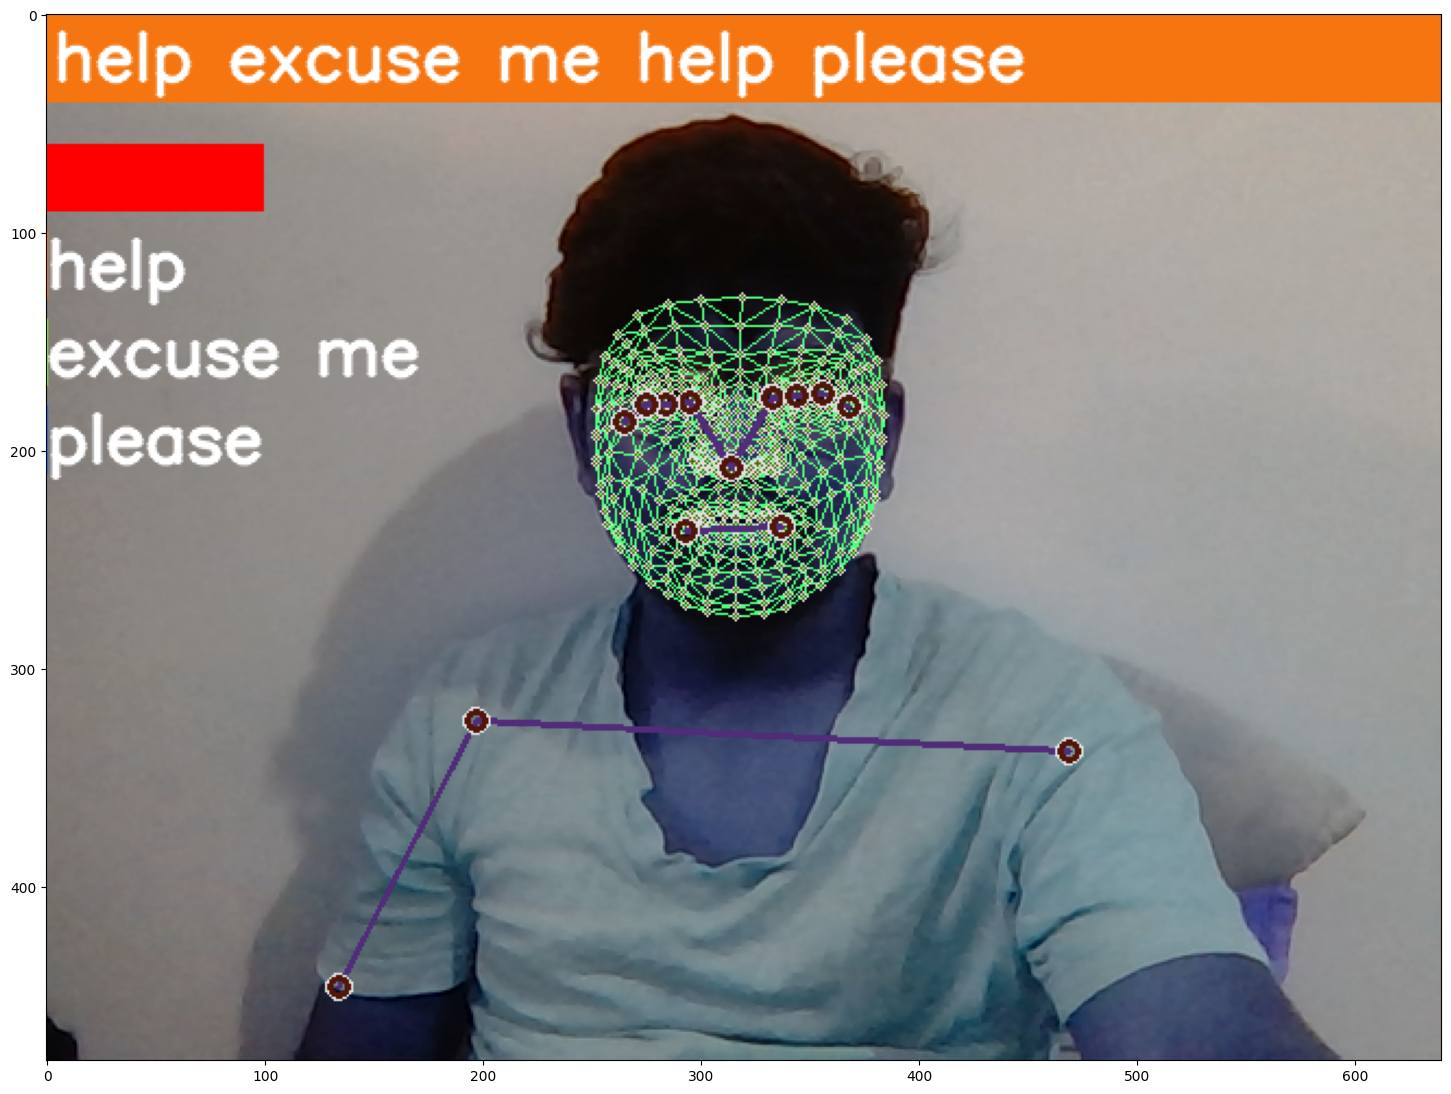

In [136]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))